# Import Package

In [ ]:
import sys
sys.path.append(r"D:\data analysis\code\WBI_analysis")  # 例如 r"C:\Users\YourName\Project"
import AnalysisMethod

In [ ]:
import cv2
import os
import pandas as pd
import bisect
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D 
from matplotlib.patches import Patch
import numpy as np
from scipy.ndimage import label
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from scipy.ndimage import grey_opening,grey_closing
from matplotlib.gridspec import GridSpecFromSubplotSpec
import AnalysisMethod as am
from sklearn.cluster import AgglomerativeClustering
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib as mpl
import warnings
import argparse
from scipy.signal import correlate
from scipy.stats import ttest_1samp
# from statsmodels.stats.multitest import multipletests
from scipy.ndimage import gaussian_filter1d,binary_closing, binary_opening
# from matplotlib.gridspec import GridSpec
warnings.filterwarnings('ignore')
from tifffile import imread
from scipy.stats import sem
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import ttest_rel, shapiro
from scipy.stats import ttest_ind
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib.colors import Normalize
mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 96
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.bbox'] = 'tight'

# PreAnalysis 预处理
+ 行为数据和神经数据分别导入并平滑（平滑使用相同参数）
+ 行为数据
    + 开闭操作
    + 计算并验证前进后退的起始和结束
+ 神经数据
    + 标准化：Z-score
+ 合并行为与神经
    + 将行为数据中标记的前进后退等

## 函数定义

#### 旧函数定义

In [ ]:
def get_start_points(forward_reversal_series):
    # 创建一个 DataFrame，只包含原始列，方便处理
    df = pd.DataFrame({'forward_reversal_series': forward_reversal_series})
#     df['rev_start'] = 0

    # 差分找变化点
    df['diff_qr'] = df['forward_reversal_series'].diff()
#     plt.plot(diff_qr)
#     print(len(df.loc[diff_qr == 1, 'rev_start']), len(df.loc[diff_qr == 1, 'rev_start'])/len(df))
    # 标记起始和结束
    df.loc[:,'rev_start'] = np.nan
    df.loc[df['diff_qr'] == 1, 'rev_start'] = 1
    df.loc[df['diff_qr'] == -2, 'rev_start'] = 2    # 从nan转到reverse
    df.loc[df['diff_qr'] == -1, 'rev_start'] = 3
    df.loc[df['diff_qr'] == -3, 'rev_start'] = 4    # 从nan转到forward
    # 特殊情况处理：开头或结尾就是 1
#     if df['quick_reversal'].iloc[0] == 1:
#         df.loc[df.index[0], 'quick_reversal_point'] = 1
#     if df['quick_reversal'].iloc[-1] == 1:
#         df.loc[df.index[-1], 'quick_reversal_point'] = 2

    return df['rev_start'].values

def Opening_Closing(vector,structure_size_open=10, structure_size_close=5):
    '''利用开操作删除和合并后退
    vector: 一维向量
    structure_size的第一和第二个值分别控制开和闭的大小'''
    # 可视化重定向的位置，找到索引
#     vector = df_PCA_motion.forward.values

    # 将一维向量扩展为二维（例如 1 行或 1 列）
    heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
    print(heatmap_data)
    # Define two colors
    colors = ['blue', 'yellow']
    # Create a ListedColormap
    two_color_cmap = ListedColormap(colors)


#     # 绘制热图
#     plt.figure(figsize=(20, 1))  # 设置热图大小
#     plt.imshow(heatmap_data, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
#     plt.colorbar(label='Value')  # 添加颜色条
#     plt.xticks([])  # 设置x轴刻度
#     plt.yticks([])  # 隐藏y轴刻度
#     plt.title("Before opening")
#     plt.show()

    # Define the size of the structuring element
#     structure_size_open = 10
    # Perform opening
    '''这里opening的效果是合并！'''
    opened_vector = grey_opening(heatmap_data, size=structure_size_open)

    # Perform closing
    '''这里的close的效果是擦除！'''
    vector = grey_closing(opened_vector, size=structure_size_close)

#     plt.figure(figsize=(20, 1))  # 设置热图大小
#     plt.imshow(vector, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
#     plt.colorbar(label='Value')  # 添加颜色条
#     plt.title('Removed small turnings')
#     plt.xticks()  # 设置x轴刻度
#     plt.yticks([])  # 隐藏y轴刻度
#     # plt.title("Heatmap of 1D Vector")
#     plt.show()
    return vector

def plot_custom_timeseries(
    df,
    time_col,
    line_cols=None,
    line_color_by_col=None,
    scatter_col=None,
    colorbar1_col=None,
    colorbar2_col=None,
    nanbar1_col=None,
    vertical_line_col=None,
    triangle_times=None,
    plot_line=None,
    plot_scatter=None,
    plot_colorbar1=None,
    plot_colorbar2=None,
    plot_colorbar3=None,
    plot_vertical_lines=None,
    plot_triangles=None,
    figsize=(20, 4),
    title=None,
    time_range=None
):
    def col_should_plot(col, flag):
        if flag is None:
            return col is not None and col in df.columns
        return flag

    if time_range:
        start, end = time_range
        df = df[(df[time_col] >= start) & (df[time_col] <= end)].reset_index(drop=True)

    draw_bar1 = col_should_plot(colorbar1_col, plot_colorbar1)
    draw_bar2 = col_should_plot(colorbar2_col, plot_colorbar2)
    draw_bar3 = col_should_plot(nanbar1_col, plot_colorbar3)
    num_bars = int(draw_bar1) + int(draw_bar2) + int(draw_bar3)

#     fig, ax_main = plt.subplots(figsize=figsize, constrained_layout=True)
    fig,ax = plt.subplots(figsize=figsize)
    if title:
        ax.set_title(title)
#     if num_bars > 0:
    fig.set_constrained_layout(False)
    gs = GridSpec(len(line_cols)+1, 1, height_ratios=[1.0]*len(line_cols)+[0.3 * num_bars], wspace=0.3, hspace=0.25, figure=fig)
    # 可能画多个折线图
    ax_bar = fig.add_subplot(gs[-1], sharex=ax)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])                  # 去除刻度
    ax.set_yticklabels([])            # 去除刻度标签
    ax.tick_params(axis='y', left=False)  # 去除刻度线
    # Plot line
    i = 0
    for line_col in line_cols:
        ax_main = fig.add_subplot(gs[i])
        if isinstance(line_col, str):
            line_col_list = [line_col]
        else:
            line_col_list = line_col

        for col in line_col_list:
            if line_color_by_col and line_color_by_col in df.columns:
                
                # 分段上色
                segment_time, segment_value, current_color = [], [], None
                handles_drawn = {'red': False, 'blue': False}

                for t, y, c in zip(df[time_col], df[col], df[line_color_by_col]):
                    if current_color is None:
                        current_color = c
                    if c != current_color:
                        if segment_time:
                            color = 'red' if current_color == 1 else 'blue'
                            label = 'reversal' if color == 'red' and not handles_drawn['red'] else None
                            ax_main.plot(segment_time, segment_value, color=color)
                            handles_drawn[color] = True
                        segment_time, segment_value = [t], [y]
                        current_color = c
                    else:
                        segment_time.append(t)
                        segment_value.append(y)
                if segment_time:
                    color = 'red' if current_color == 1 else 'blue'
                    label = 'reversal' if color == 'red' and not handles_drawn['red'] else None
                    ax_main.plot(segment_time, segment_value, color=color)
            else:
                ax_main.plot(df[time_col], df[col])
            if "smoothed_" in col:
                col = col.replace("smoothed_","")
            ax_main.set_ylabel('\n'.join(col.split('_')), rotation=0,labelpad = 15, va='center')
            if time_range:
                ax_main.set_xlim(time_range)
            else:
#                 print(df[time_col].min(), df[time_col].max())
                ax_main.set_xlim(df[time_col].min(), df[time_col].max())
            ax_main.set_xticks([])
            
            # Triangle markers
            if len(triangle_times) and (plot_triangles is None or plot_triangles):
                y_min, y_max = ax_main.get_ylim()
                triangle_y = y_max + 0.05 * (y_max - y_min)
                for t in triangle_times:
                    ax_main.plot(df.loc[t,time_col], triangle_y, marker='v', color='purple', markersize=8)
                    ax_main.axvline(x=df.loc[t,time_col], color='black', linestyle='--', linewidth=1)
                ax_main.set_ylim(y_min, triangle_y + 0.1 * (y_max - y_min))
        i += 1

    # Plot scatter
    if col_should_plot(scatter_col, plot_scatter):
        ax_main.scatter(df[time_col], df[scatter_col], color='r', s=2, label=scatter_col)

    # Vertical lines
    if col_should_plot(vertical_line_col, plot_vertical_lines):
        for vt in df[df[vertical_line_col] == 1][time_col]:
            ax_main.axvline(x=vt, color='green', linestyle='--', linewidth=1)

    

    

    # Colorbar
    handles, labels = ax_main.get_legend_handles_labels()
    if ax_bar:
        bar_data = []
        if draw_bar3:
            nan_mask = df[nanbar1_col].isna().values
            bar_data.append((np.where(nan_mask, 1, 0)[np.newaxis, :], mcolors.ListedColormap(['black', 'red'])))
        if draw_bar2:
            vals2 = df[colorbar2_col].fillna(0).astype(int).values[np.newaxis, :]
            bar_data.append((vals2, mcolors.ListedColormap(['black', 'yellow'])))
        if draw_bar1:
            vals1 = df[colorbar1_col].fillna(0).astype(int).values[np.newaxis, :]
            bar_data.append((vals1, mcolors.ListedColormap(['black', 'yellow', 'red'])))

        bar_height = 1.0 / num_bars
        for i, (vals, cmap) in enumerate(bar_data):
            extent = [df[time_col].iloc[0], df[time_col].iloc[-1], i * bar_height, (i + 1) * bar_height]
            ax_bar.imshow(vals, aspect='auto', cmap=cmap, extent=extent)

        bar_labels = []
        if draw_bar3: bar_labels.append('untrust')
        if draw_bar2: bar_labels.append('reversal(after)')
        if draw_bar1: bar_labels.append('reversal(before)')

        ax_bar.set_yticks([(i + 0.5) / num_bars for i in range(num_bars)])
        ax_bar.set_yticklabels(bar_labels)
        ax_bar.set_ylim(0, 1)
        ax_bar.tick_params(left=False)
        ax_bar.set_xlabel('Time')

        # Legend patch
        patches = []
        if draw_bar1: 
            patches.append(Patch(color='yellow', label='reversal'))
        if draw_bar2: patches.append(Patch(color='red', label='untrusted frames'))
        handles += patches
        labels += [p.get_label() for p in patches]

    if handles:
#         ax_main.legend(handles=handles, labels=labels, loc='upper right')
        ax_main.legend(loc='upper left',handles=handles, labels=labels, bbox_to_anchor=(1.01, 0.85), borderaxespad=0.)

#     ax_main.set_ylabel('Value')
    
#     plt.tight_layout()
    return fig, ax_main


In [ ]:
def label_event_segments(df, start_indices, event_col = "forward_opcl",
                          accept_ab_end = True,
                          output_col='forward_sel'):
    """
    根据开始和结束标记对DataFrame进行段落标注。
    注意这个代码需要匹配对于forward-reverse transition的四种情况的标记语法

    参数：
    - start_flags：开始的标记值列表
    - accept_ab_end: 接收异常结尾
    - output_col：新列的名字
    - debug：是否打印调试信息
    """
    # 初始化输出列
    df[output_col] = 0

    # 获取 end 索引及标签

    end_nor_indices = df[df['rev_start_opcl']==3].index
    end_abnor_indices = df[df['rev_start_opcl']==4].index
    
    rev_end_idx = []
    for s_idx in start_indices:
        nearest_nor_end = end_nor_indices[bisect.bisect_left(end_nor_indices, s_idx)]
        nearest_abnor_end = end_abnor_indices[bisect.bisect_left(end_abnor_indices, s_idx)]
        print('起始index：',s_idx)
#         if not end_candidates:
#             if debug:
#                 print(f'⚠ No end found for start at {s_idx}')
#             continue
        if nearest_abnor_end <= nearest_nor_end:
            print(f'abnormal{nearest_abnor_end} < normal:{nearest_nor_end}')
            # 异常结束
            if accept_ab_end:
                df.loc[s_idx+1:nearest_abnor_end,output_col] = 1
                rev_end_idx.append(nearest_abnor_end)
                print('保存abnormal起始结束：',s_idx, nearest_abnor_end)
            else:
                pass
        else:
            df.loc[s_idx+1:nearest_nor_end,output_col] = 1
            rev_end_idx.append(nearest_nor_end)
            print('保存normal起始结束:', s_idx, nearest_nor_end)
    return df, rev_end_idx

### 函数

#### 可视化

In [ ]:
def visualize_traces(p_f, calcium_intensity,df_vol_time, smooth=True, sigma=0.3,delta_y=1.2):
    # 平滑和可视化
    n_neurons, _ = calcium_intensity.shape
    print(f'shape of calcium_traces {calcium_intensity.shape}')
    t_max = df_vol_time['Vol_Time'].max()
    fig, ax = plt.subplots(figsize=(t_max/100, n_neurons/4))

    if 'mask' in df_vol_time.columns:
        mask = df_vol_time['mask'].values
        time = df_vol_time['Vol_Time'].values
        in_mask = False
        start = None
        for i in range(len(mask)):
            if mask[i] == 1 and not in_mask:
                in_mask = True
                start = time[i]
            elif (mask[i] == 0 or i == len(mask)-1) and in_mask:
                in_mask = False
                end = time[i] if mask[i] == 0 else time[-1]
                ax.axvspan(start, end, color='pink', alpha=0.2)

    for i in range(n_neurons):
        trace = calcium_intensity[i, :]
        if smooth:
            trace = gaussian_filter1d(trace, sigma=sigma)
        plt.plot(df_vol_time['Vol_Time'], trace + i * delta_y,lw=0.5, label=f"Neuron {i}")

    # 设置坐标轴
    plt.xlabel("Time (frames)")
    plt.ylabel("Neuron index")
    desired_ticks = np.arange(0, df_vol_time['Vol_Time'].max(), 30) # 生成一个数组 [10, 30, 50, 70, 90]
    plt.xticks(desired_ticks, rotation=30)
    y_positions = np.arange(0, n_neurons * delta_y, delta_y)
    plt.yticks(y_positions[:n_neurons], np.arange(n_neurons))
    plt.title(f"Calcium Traces (Gaussian smoothed){sigma}")
    plt.grid(True, linestyle='--', color='grey', linewidth=0.35, alpha=0.5)
    plt.savefig(p_f+f'\\Cal_traces_Gaussion{sigma}.png', bbox_inches='tight')
    # plt.show()


## 数据导入
+ 利用行为数据进行behavioral motif分割操作

In [ ]:
p_f_outside = r'Y:\\SZX\\2025_wbi_analysis\\good_WBI\\done'
f_folder = '20241219_0g-ov_05'
p_f = p_f_outside+'\\'+f_folder

# (与荧光对时的)行为数据导入，不需要重新分析处理的
'''激光段的行为数据,帧率为30Hz左右'''
mot_mid_vol = [f for f in os.listdir(p_f) if 'MotionMidlineMatchVol' in f][0]
if 'pkl' in mot_mid_vol:
    df_mot_vol = pd.read_pickle(os.path.join(p_f, mot_mid_vol)).reset_index(drop=True)
else:
    df_mot_vol = pd.read_csv(os.path.join(p_f, mot_mid_vol))

calcium_intensity= np.load(os.path.join(p_f, 'calcium_intensity.npy'))
save_p = p_f.split('calcium_intensity.npy')[0]
print('文件大小:neuron*timestamp',calcium_intensity.shape)

In [ ]:
def signed_norm(row):
    val = row["head_moving"]
    forward = row["forward"]

    if val is None or (isinstance(val, float) and np.isnan(val)):
        return np.nan

    if isinstance(val, str):
        arr = np.fromstring(val.strip("[]"), sep=" ")
    else:
        arr = np.array(val, dtype=float)

    if arr.size == 0:
        return np.nan

    norm = np.linalg.norm(arr)
    # forward==0 正，forward==1 负
    return norm if forward == 0 else -norm

df_mot_vol["head_velocity"] = df_mot_vol.apply(signed_norm, axis=1)
df_mot_vol["head_speed"] = df_mot_vol["head_velocity"].abs()

## 预处理

In [ ]:
# 预处理： 均值滤波器 (box filter)
scale = 1.5
for i in range(calcium_intensity.shape[0]):
    calcium_intensity[i] = (cv2.blur(calcium_intensity[i], (1, 7))*scale)[:,0]
# # 行为数据进行平滑和分割前进后退
# # 对数据进行平滑
# 平滑速度


In [ ]:

window_size = 15
# 计算移动平均值
df_mot_vol['sm_velocity'] = df_mot_vol['head_velocity'].rolling(window=window_size, min_periods=1).mean()
df_mot_vol['sm_speed'] = df_mot_vol['head_speed'].rolling(window=window_size, min_periods=1).mean()
# # 平滑ctx
window_size = 15
# 计算移动平均值
df_mot_vol['sm_CTX'] = df_mot_vol['CTX_left'].rolling(window=window_size, min_periods=1).mean()

In [ ]:
df_mot_vol['sm_ang'] = df_mot_vol['ang_velocity'].rolling(window=window_size, min_periods=1).mean()

## Hierarchical Clustering and Plot Traces
+ hierarchical clutering and sort the neurons
+ correlation matrix sorted by clustering result
+ Align behavior features with neural traces
+ Align PC component with neural traces

### 函数定义

In [ ]:
def draw_calcium_curve(calcium_intensity, smooth_kernel=None, save=True,fig_size=None, scale=1):

    plt.figure(figsize=fig_size)
    num_neurons, num_timepoints = calcium_intensity.shape
    colors = ['orangered', 'blue', 'limegreen', 'purple', 'gold', 'cyan', 'magenta', 'coral', 'skyblue', 'orange']
    import cv2
    for i in range(calcium_intensity.shape[0]):
        color = colors[i % len(colors)]  # 循环使用颜色列表
        if smooth_kernel:
            smooth_line_data = cv2.blur(calcium_intensity[i], (1, 3))*scale
        else:
            line_data = calcium_intensity[i]*scale
        smooth_line_data = cv2.blur(calcium_intensity[i], (1, 7))*scale
        plt.plot(smooth_line_data + i, color=color, linestyle='-', label='A' if i == 0 else "",linewidth=1)  # 只显示第一个标签
        plt.scatter(y=line_data+i,x=np.arange(line_data.shape[0]),color=color, linestyle='-', label='A' if i == 0 else "",s=1)  # 只显示第一个标签
        if i in bound:
            plt.axhline(y=i-0.2, color='k', linestyle='dashdot', linewidth=4, c='r')  # 在y轴索引位置画一条虚线
        # 在每一行的右侧添加纵轴范围标注
        # plt.text(num_timepoints - 5, i + (y_max - y_min) / 2, f'{y_min:.2f} to {y_max:.2f}', 
        #      color=color, fontsize=10, va='center')
    plt.xlabel("Time point",fontsize=20)  # X轴标签
    plt.ylabel("Intensity",fontsize=20)  # Y轴标签
    # 设置 y 轴范围
    plt.ylim(bottom=0-1, top=num_neurons+1)  # 设置 y 轴的最小值为 0，最大值为 num_neurons

    # 每隔 5 个单位标注一个 y ticks
    y_ticks = np.arange(0, num_neurons + 1, 1)  # 生成从 0 到 num_neurons 的刻度，每隔 5 个单位
    plt.yticks(y_ticks,fontsize=20)  # 设置 y 轴刻度
    x_ticks = np.arange(0, num_timepoints + 1, 200)  # 生成从 0 到 num_neurons 的刻度，每隔 5 个单位
    plt.xticks(x_ticks,fontsize=20,rotation=45)  # 设置 y 轴刻度
    plt.tight_layout()
    if save:
        if smooth_kernel:
            plt.savefig(f'{signal_save_path}/cluster_calcium_curve(smooth_{smooth_kernel}).png')
        else:
            plt.savefig(f'{signal_save_path}/cluster_calcium_curve.png')

In [ ]:
def PlotPmdCluster(w_p2m,idx_pmd,idx_m1,bound_pmd,bound_m1,link,aff,vmin,vmax,threshold,xlabel,cmap,level):
    '''
    w_p2m: 数据矩阵，用于绘制热图和聚类分析。
    idx_pmd, idx_m1: 用于对行和列排序的索引。
    bound_pmd, bound_m1: 热图中行和列的边界，用于分区的虚线绘制。
    link, aff: 聚类方法的链接方式和距离度量方式。
    vmin, vmax: 热图的颜色范围。
    threshold: 树状图的颜色阈值。
    xlabel, ylabel: 热图的轴标签。
    cmap: 热图的颜色映射。
    level: 树状图的截断层数。
    '''
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(1,1,1)
    ax.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
    ax.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
    ax.set_xticks([])  # 移除x轴的刻度标记
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    # plt.title(title)
    gs00 = GridSpecFromSubplotSpec(3, 3, subplot_spec=ax.get_subplotspec(), wspace=0.3, hspace=0.02,
                                   width_ratios=[0.2, 6.5, 1], height_ratios=[1, 6.5, 0.2])
    
    # 热图
    ax0 = fig.add_subplot(gs00[1, 1])
    # 树状图在上方
    ax1 = fig.add_subplot(gs00[0, 1])
    # ax2 = fig.add_subplot(gs00[0, 0])
    
    # 聚类并将聚类的结果画在相关性矩阵旁边
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage=link, affinity=aff)
    model = model.fit(w_p2m)
    am.plot_dendrogram(model, truncate_mode="level", p=level, \
                    no_labels=True, orientation='bottom', ax=ax1,color_threshold=threshold)
    ax1.set_xlim(ax1.get_xlim())
    # ax1.set_xlim([0.5,2])
    ax1.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
    ax1.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
    ax1.set_xticks([])  # 移除x轴的刻度标记
    ax1.set_yticks([])
    ax1.invert_yaxis()
    for spine in ax1.spines.values():
        spine.set_visible(False)
    ax_list=list(np.linspace(0,w_p2m.shape[0],24,dtype=int))
    X_sort = w_p2m[idx_pmd][:,idx_m1]
    
    # 重新排序之后画热图
    
#     ax0.set_aspect(1)

    cbar_ax = fig.add_subplot(gs00[1,0])  # [left, bottom, width, height]
    # 设置热图的corlorbar
    ax0=sns.heatmap(X_sort, ax=ax0, cmap=cmap, vmin=vmin, vmax=vmax,cbar=True, cbar_ax = cbar_ax, square=False)
#     cbar=fig.colorbar(ax0.collections[0], cax=cbar_ax)
    cbar_ax.yaxis.set_ticks_position("left")  # 将刻度放到左侧
    cbar_ax.yaxis.set_label_position("left")  # 将标签放到左侧
    ax0.set_xticks(ax_list, ax_list,fontsize=10)
    ax0.set_yticks(ax_list, ax_list,fontsize=10)
    # 逆转y轴以对齐钙信号热图
    ax0.invert_yaxis()
    ax0.set_xlabel(xlabel,fontsize=16)
#     ax0.set_ylabel(ylabel,fontsize=16)
#     ax0.set_xticks([])
#     ax0.set_yticks([])
    print('bound_pwd',bound_pmd)
    
    # 画边界
#     boundary = 0
#     idx_bound=np.zeros(len(bound_pmd)+1)
    for i in bound_pmd:
        ax0.axhline(y=i, color='white', linestyle='--')
    for i in bound_m1:
        ax0.axvline(x=i, color='white', linestyle='--')
        
    # 移除多余的轴（右侧或下方）
    ax_empty = fig.add_subplot(gs00[1, 2])
    ax_empty.axis("off")  # 空白占位，不显示内容
    
    plt.tight_layout()
#     for i in range(len(bound_pmd)-1):
#         boundary += bound_pmd[i]
#         idx_bound[i+1]=boundary
        
#         print('boundary', boundary)
#         print('idx_bound:',idx_bound)
#         # print(boundary)
#         ax0.axhline(y=boundary, color='white', linestyle='--')
#     idx_bound[-1]=400
#     boundary = 0
#     for i in range(len(bound_m1)-1):
#         boundary += bound_m1[i]  
#         # print(boundary)
#         ax0.axvline(x=boundary, color='white', linestyle='--')
#     return idx_bound.astype(int),fig
    return fig

In [ ]:
def calcium_heatmap(calcium_intensity,df, col_draw,  neuron_ids,model,w_p2m, show_id_stride=20, show_vol_stride=10,
                    heatmap_range=(None,0.5),
                    unit_w=0.05, unit_h = 0.2, cal_height_ratio=20, wspace=0.125, hspace = 0.125
                    ,bound_cluster = [],smooth_kernel=None,
                    font_size=90, font_color='black',
                   idx=None,vmin=0,vmax=1,threshold=None,xlabel='',cmap='jet',level=None):
    '''
    calcium_intensity: （神经元个数 x 时间点）
    df： PCA和行为对齐
    col_draw: 需要画图的列名
    unit_w: 单位宽度(对应时间)
    unit_h: 单位高度（对应神经元数量）
    cal_height_ratio : 预期钙信号热图相对运动参数等条图的高度比例
    '''
    # 神经元数量及时间长度
    num_neurons, num_vols = calcium_intensity.shape
    
    
    if ('turn_cor' in col_draw)& ('turn_pc' in col_draw):
        # 两者画在一起
        turn_merge = True
        num_row = len(col_draw)
    else:
        turn_merge = False
        num_row = len(col_draw)+1
    
    height_ratios = [1.5 for i in range(num_row-1)]
    height_ratios.append(cal_height_ratio)
    gs = GridSpec(num_row, 4, height_ratios=height_ratios, width_ratios=[0.3,25,50, 0.3], wspace=wspace, hspace=hspace)
    fig_h = (unit_h*num_neurons)/ cal_height_ratio *  sum(height_ratios)
    fig = plt.figure(figsize=(unit_w*num_vols+unit_h*num_neurons*1.1, fig_h))
    # 热图
    ax0 = fig.add_subplot(gs[-1, 1])
    # 树状图在上方
    ax1 = fig.add_subplot(gs[-4:-1, 1])
    
    
    
    # Override the default linewidth.
    mpl.rcParams['lines.linewidth'] = font_size*0.2
    am.plot_dendrogram(model, truncate_mode="level", p=level, \
                    no_labels=True, orientation='bottom', ax=ax1,color_threshold=threshold,
                   above_threshold_color='blue')
    ax1.set_xlim(ax1.get_xlim())
    # ax1.set_xlim([0.5,2])
    ax1.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
    ax1.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
    ax1.set_xticks([])  # 移除x轴的刻度标记
    ax1.set_yticks([])
    ax1.invert_yaxis()
    for spine in ax1.spines.values():
        spine.set_visible(False)
    ax_list=list(np.linspace(0,w_p2m.shape[0],24,dtype=int))
    X_sort = w_p2m[idx][:,idx]
    
    # 重新排序之后画热图
    
    # 设置热图的corlorbar
    # [left, bottom, width, height]
    cbar_ax = fig.add_axes([0.0, 0.15, 0.01, 0.4])
    ax0=sns.heatmap(X_sort, ax=ax0, cmap=cmap, vmin=vmin, vmax=vmax,cbar=True, cbar_ax = cbar_ax, square=False)
    cbar_ax.yaxis.set_ticks_position("left")  # 将刻度放到左侧
    cbar_ax.yaxis.set_label_position("left")  # 将标签放到左侧
    cbar_ax.tick_params(labelsize=font_size, pad = font_size*0.75)
    cbar_ax.set_ylabel('Correlation', fontsize = font_size*1.25, labelpad = font_size*0.75)
    ax0.set_xticks(ax_list, ax_list,fontsize=font_size)
    ax0.set_yticks(ax_list, ax_list,fontsize=font_size)
    ax0.tick_params(axis = 'x', pad = font_size*0.75)
    ax0.tick_params(axis='y', labelrotation=0,pad = font_size*0.75)  # 将y轴标签设置为水平
    # 逆转y轴以对齐钙信号热图
    ax0.invert_yaxis()
    ax0.set_xlabel(xlabel,fontsize=font_size*1.25, labelpad = font_size*0.75)
    bound_pmd = bound_cluster
    bound_m1 = bound_cluster
    # 画边界
    for i in bound_pmd:
        ax0.axhline(y=i, color='white', linestyle='--')
    for i in bound_m1:
        ax0.axvline(x=i, color='white', linestyle='--')
    
    # 循环画运动参数
    for i, col in enumerate(col_draw):
        # 添加子图
        ax = fig.add_subplot(gs[i, 2])  # 从第一行开始
        vector = df[col].values
        if ('turn' not in col) & ('forward' not in col):
            heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
            im = ax.imshow(heatmap_data, cmap='jet', aspect='auto')  # 绘制热图

            # 调整 colorbar 参数
            cax = fig.add_subplot(gs[i, 3])  # colorbar 放在右侧
            cbar = plt.colorbar(im, cax=cax, fraction=0.5, orientation='vertical', aspect = 3)
            if 'smoothed_' in col:
                col = col.replace('smoothed_', '')
            cbar.ax.set_title(col, fontsize = font_size*0.85, pad = font_size*0.25 )
            cbar.ax.tick_params(labelsize=font_size*0.5, width=5, length=5, pad = font_size*0.25)  # 设置刻度大小和宽度
            # 设置标题和轴
            ax.set_xticks([])  # 隐藏x轴刻度
            ax.set_yticks([])  # 隐藏y轴刻度
        elif ('turn' in col) & (turn_merge==False):
            heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
            # Define two colors
            colors = [ 'grey','#FFC832']
            # Create a ListedColormap
            two_color_cmap = ListedColormap(colors)
            im = ax.imshow(heatmap_data, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
            # 添加颜色条
            cax = fig.add_subplot(gs[i, 3])  # colorbar 放在右侧
            cbar = plt.colorbar(im, cax=cax, fraction=0.5, orientation='vertical', aspect = 3)  # 通过 plt.colorbar 添加颜色条
            cbar.ax.set_title(col, fontsize = font_size*0.85, pad = font_size*0.25 )
            ax.set_xticks([])  # 设置x轴刻度
            ax.set_yticks([])  # 隐藏y轴刻度
        elif 'forward' in col:
            heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
            # Define two colors
            colors = [ 'red','blue']
            # Create a ListedColormap
            two_color_cmap = ListedColormap(colors)
            im = ax.imshow(heatmap_data, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
            # 添加颜色条
            cax = fig.add_subplot(gs[i, 3])  # colorbar 放在右侧
            cbar = plt.colorbar(im, cax=cax, fraction=0.5, orientation='vertical', aspect = 3)  # 通过 plt.colorbar 添加颜色条
            cbar.ax.set_title(col, fontsize = font_size*0.85, pad = font_size*0.25 )
            ax.set_xticks([])  # 设置x轴刻度
            ax.set_yticks([])  # 隐藏y轴刻度

    # 倒数第二行
    if turn_merge:
        ax = fig.add_subplot(gs[-2, 2])  # 第一行
        vector_pc = df['turn_pc'].values
        vector_cor = df['turn_cor'].values

        heatmap_data_pc = vector_pc[np.newaxis, :]
        heatmap_data_cor = vector_cor[np.newaxis, :]

        # --------- PC 层：灰色(0) + 黄色(1)
        color_pc = ['grey', '#FFC832']
        cmap_pc = ListedColormap(color_pc)
        ax.imshow(heatmap_data_pc, cmap=cmap_pc, aspect='auto')

        cax = fig.add_subplot(gs[-2, 3])  # colorbar 放在右侧
        cbar = plt.colorbar(im, cax=cax, fraction=0.5, orientation='vertical', aspect = 3)
        cbar.ax.set_title('coiling/turn', fontsize = font_size*0.85, pad = font_size*0.25 )
        cbar.ax.tick_params(labelsize=font_size*0.5, width=5, length=5, pad = font_size*0.25)

        # 去掉坐标
        ax.set_xticks([])
        ax.set_yticks([])

    # 绘制钙信号热力图 
    ax = fig.add_subplot(gs[-1, 2])  # 最后一行
    heatmap=sns.heatmap(calcium_intensity, vmin=heatmap_range[0], vmax=heatmap_range[1],
                        xticklabels=np.arange(num_vols)[::show_vol_stride],
                        yticklabels=neuron_ids[::show_id_stride],cbar=False,cmap='jet', ax=ax)
    
    cax = fig.add_axes([0.9, 0.15, 0.01, 0.4]) # [left, bottom, width, height]
#     cax = fig.add_subplot(gs[-1, 1])  # colorbar 放在右侧
    text_str = 'ΔR/R0'
    colorbar = plt.colorbar(heatmap.collections[0],cax=cax)
    colorbar.ax.tick_params(labelsize=font_size, pad = font_size*0.75)
    colorbar.set_label(text_str, fontsize = font_size*1.25, labelpad = font_size*0.75)
    
    # # 竖直白线根据轨迹分区
    # if len(start_indices):
    #     x_sticks = start_indices[1:-1]
    #     for x in x_sticks:
    #         ax.axvline(x=x, color='white', linestyle='--', linewidth=font_size*0.12)  # Adjust color and linestyle as needed
    
    # 横向根据聚类结果分块
    if len(bound_cluster):
        for i in bound_cluster:
            ax.axhline(y=i, color='white', linestyle='--', linewidth=font_size*0.12)
    
    ax.set_yticks(ticks=np.arange(0, num_neurons, show_id_stride), labels=neuron_ids[::show_id_stride],fontsize=font_size, 
                  color=font_color)
#     ax.set_xticks(ticks=np.arange(0, num_vols, show_vol_stride), labels=np.arange(num_vols)[::show_vol_stride],fontsize=font_size, rotation=45, color=font_color)
    ax.set_xticks(ticks=np.arange(0, num_vols, show_vol_stride), labels=df.Vol_Time.astype(int).values[::show_vol_stride],
                  fontsize=font_size, rotation=0, color=font_color)
    ax.tick_params(pad = font_size*0.75)
    #     ax.set_xticks(ticks = df.Vol_Time
    # plt.xticks(ticks=np.arange(0, num_vols, show_vol_stride), labels=np.arange(0,1300,100),fontsize=font_size, rotation=45, color=font_color)
    # plt.title('Calcium activity traces (ΔR/R0) Heatmap',fontsize=font_size,)
    ax.set_xlabel('Time(s)',fontsize=font_size*1.25, color=font_color, labelpad = font_size*0.75)
#     ax.set_ylabel('Neuron Index',fontsize=font_size*1.25,color=font_color, labelpad = font_size*0.75)
    # plt.axis('off')
    # plt.gca().spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # 设置y轴的刻度位置，使其从顶部开始，因为神经元通常从顶部向下绘制
    ax.invert_yaxis()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
#     ax.gca().invert_yaxis()
#     plt.subplots_adjust(left=0.125, bottom=0.1, right=0.1, top=0.1, wspace=0.2, hspace=0.35)
    # plt.show()
    if smooth_kernel:
        plt.savefig(f'{signal_save_path}/cluster_calcium_heatmap(smooth_{smooth_kernel}).png', transparent=False,dpi=100)
    else:
        plt.savefig(f'{signal_save_path}/cluster_calcium_heatmap.png', transparent=False,dpi=100)
    
    # 调整布局，确保图例与子图不重叠
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.7, hspace=0.1)  # bottom 参数调整整个图形的底部边距
    plt.tight_layout()
    
#     ax.legend(fontsize = fs*0.75, bbox_to_anchor = (1.02,1), markerscale=3)
    if smooth_kernel:
        plt.savefig(f'{signal_save_path}/Segmented_Traj(smooth_{smooth_kernel}).png', transparent=False,dpi=100)
    else:
        plt.savefig(f'{signal_save_path}/Segmented_Traj.png', transparent=False,dpi=100)

### 画图并排序

In [ ]:
# 定义图片保存文件夹路径
folder_path = os.path.join(p_f, 'Figs')
# 检查文件夹是否存在
if not os.path.exists(folder_path):
    os.makedirs(folder_path)  # 创建文件夹
    print(f"文件夹 '{folder_path}' 已创建！")
else:
    print(f"文件夹 '{folder_path}' 已存在！")

# 定义全局变量
#     global signal_save_path, idx, bound

signal_save_path = folder_path

choose_index = 0
thresh = 5
links=['ward','average','average','complete']
affs=['euclidean','cosine','cityblock','cosine']
vmin=-0.5
vmax=1
smooth_kernel = 10
print('calcium_intensity.shape',calcium_intensity.shape)

# 使用 np.corrcoef(calcium_intensity) 计算神经元钙信号的相关性矩阵
# 聚类：使用 am.cluster 和指定的链接方式 (link=links[choose_index]) 
# 和距离度量 (aff=affs[choose_index]) 对相关性矩阵进行聚类。
idx=am.cluster(np.corrcoef(calcium_intensity),link=links[choose_index],aff=affs[choose_index])
# idx为聚类之后的索引
bound=np.cumsum(am.GetBound(np.corrcoef(calcium_intensity),link=links[choose_index],aff=affs[choose_index],
                            threshold=thresh).astype(int))
# 调用 am.GetBound 计算矩阵分区的边界（bound），通过 np.cumsum 累积求和获取完整的边界数组
print('边界', bound)

calcium_intensity = calcium_intensity[idx]
calcium_intensity_smd = calcium_intensity.copy()
# 平滑数据
if smooth_kernel:
    for i,k in enumerate(calcium_intensity_smd):
        calcium_intensity_smd[i] = cv2.blur(k,(1,smooth_kernel))[:,0]
# 计算相关性矩阵
w_p2m = np.corrcoef(calcium_intensity_smd)

# 聚类并将聚类的结果画在相关性矩阵旁边
link = links[choose_index]
aff = affs[choose_index]
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage=link, affinity=aff)
model = model.fit(w_p2m)
fig_h = int(10*round(calcium_intensity.shape[0]/10))
fig_w = int(0.7*round(calcium_intensity.shape[1]/100))
#     draw_calcium_curve(calcium_intensity,smooth_kernel=None,fig_size=(fig_w,fig_h),scale=1.5)

font_size = 100

'''输入事件开始index列表'''
neuron_ids = np.arange(calcium_intensity.shape[0])
col_draw = ['sm_velocity','sm_speed', 'sm_ang', 'sm_CTX','curvature', 'forward','turn_pc','turn_cor']

calcium_heatmap(calcium_intensity,df_mot_vol, col_draw,  neuron_ids,model,w_p2m, show_id_stride=10,
                show_vol_stride=500, heatmap_range=(0,0.6),wspace=0.06, hspace=0.2,bound_cluster=bound,
                unit_w=0.03, unit_h = 0.8, cal_height_ratio=30, smooth_kernel=smooth_kernel,
                font_size=font_size, font_color='black', idx = idx, vmin = vmin, vmax = vmax, threshold=thresh, xlabel='Neuron Index',level=35)
'''注意这里是通过上一步排序后的钙信号数据！'''
calcium_intensity_sort = calcium_intensity.copy()

## 分组可视化

### 离散变量

In [ ]:
def plot_binary_background(ax, df, column, color='blue', alpha=0.3, time_col='Vol_Time'):
    """
    在图中为 df[column] 为 1 的连续段绘制背景色。
    
    参数：
        ax: matplotlib.axes 对象
        df: 包含数据的 DataFrame
        column: 需要绘制背景的二值列名
        color: 背景颜色
        alpha: 透明度
        time_col: 时间列名
    """
    if column not in df.columns:
        return

    values = df[column].values
    in_segment = False
    start = None

    for i in range(len(values)):
        if values[i] == 1 and not in_segment:
            in_segment = True
            start = df[time_col].iloc[i]
        elif (values[i] == 0 or i == len(values)-1) and in_segment:
            in_segment = False
            end = df[time_col].iloc[i] if values[i] == 0 else df[time_col].iloc[-1]
            ax.axvspan(start, end, color=color, alpha=alpha)


In [ ]:
def plot_motion_calcium(p_f,calcium_block, df_vol_time,t_max, col_name,col_color, n_block, block_name, smooth,delta_y, sigma):
    '''
    保存单个block,单组col的图片在指定文件夹
    调用: plot_binary_background
    '''
    fig, ax = plt.subplots(figsize=(t_max/100, n_block/4))
    # 画背景
    plot_binary_background(ax, df_vol_time, 'mask', color='black', alpha=0.5, time_col='Vol_Time')
    for i,c in enumerate(col_name):
        # reversal
        plot_binary_background(ax, df_vol_time,c , color=col_color[i], alpha=0.1, time_col='Vol_Time')
    j = 0
    for k,value in calcium_block.items():
        trace = value
        if smooth:
            trace = gaussian_filter1d(trace, sigma=sigma)
        plt.plot(df_vol_time['Vol_Time'], trace + j * delta_y,lw=0.5, label=f"Neuron {k}")
        j += 1
    # 设置坐标轴
    plt.xlabel("Time (s)")
    plt.ylabel("Neuron index")
    desired_ticks = np.arange(0, df_vol_time['Vol_Time'].max(), 30) # 生成一个数组 [10, 30, 50, 70, 90]
    plt.xticks(desired_ticks, rotation=30, fontsize = 10)
    y_positions = np.arange(0, n_block * delta_y, delta_y)
    plt.yticks(y_positions[:n_block], calcium_block.keys(),fontsize=10)
    plt.title(block_name+f"smthed:{sigma}_{'-'.join(col_name)}")
    plt.grid(True, linestyle='--', color='grey', linewidth=0.35, alpha=0.5)
    plt.savefig(p_f+'\\'+block_name+f"smthed{sigma}_{'-'.join(col_name)}.png", bbox_inches='tight')

In [ ]:
def block_visualize_traces(p_f, calcium_dict,df, bound, smooth=True, sigma=0.3,delta_y=1.2):
    '''
    对于单个文件,可视化函数内指定的几种离散变量在不同block的神经元上，神经元数据装在dict中
    调用,plot_motion_calcium()
    '''
    # 平滑和可视化
    n_neurons, _ = calcium_intensity.shape
    print(f'shape of calcium_traces {calcium_intensity.shape}')
    t_max = df['Vol_Time'].max()
    print('分组是否和神经元数量相同：',bound.max()==n_neurons)
    bound = [0] + bound
    # 每个bound区间生成一张图
    for i in range(len(bound)):
        if i==0:
            block_idx = np.arange(0,bound[i])
            calcium_block = {list(calcium_dict.keys())[i]: list(calcium_dict.values())[i] for i in block_idx}
            block_name = f'0-{bound[i]}'
        else:
            block_idx = np.arange(bound[i-1],bound[i])
            calcium_block = {list(calcium_dict.keys())[i]: list(calcium_dict.values())[i] for i in block_idx}
            block_name = f'{bound[i-1]}-{bound[i]}'
        n_block = len(calcium_block)
        plot_motion_calcium(p_f,calcium_block, df,t_max, ['forward'],["#324DFF"],n_block, block_name, smooth,delta_y, sigma)
        plot_motion_calcium(p_f,calcium_block, df,t_max, ['turn_pc','turn_cor'],["#FFDD32", "#FF8132"],n_block, block_name, smooth,delta_y, sigma)
        plot_motion_calcium(p_f,calcium_block, df,t_max, ['forward','turn_cor'],["#324DFF", "#FF8132"],n_block, block_name, smooth,delta_y, sigma)
        

In [ ]:
print('分组:'+bound)
calcium_dict = {i: calcium_intensity_sort[i] for i in range(len(calcium_intensity_sort))}
block_visualize_traces(p_f, calcium_dict,df_mot_vol, bound, smooth=True, sigma=0.3,delta_y=1.2)

### 连续变量

#### 连续运动变量高亮背景：神经元traces可视化by blocks

In [ ]:
def plot_continuous_background(ax, df, column, cmap='bwr', alpha=0.3, time_col='Vol_Time'):
    """
    在图中根据连续变量绘制背景色，每一小段用 colormap 映射。

    参数：
        ax: matplotlib.axes 对象
        df: 包含数据的 DataFrame
        column: 需要绘制背景的连续变量列名
        cmap: colormap 名称或对象 (如 'viridis', 'plasma')
        alpha: 透明度
        time_col: 时间列名
    """
    if column not in df.columns:
        return
    
    values = df[column].values
    times = df[time_col].values

    # 创建 colormap
    norm = Normalize(vmin=np.nanmin(values), vmax=np.nanmax(values))
    cmap = cm.get_cmap(cmap)

    # 遍历相邻区间
    for i in range(len(values)-1):
        if np.isnan(values[i]) or np.isnan(values[i+1]):
            continue  # 跳过 NaN
        start, end = times[i], times[i+1]
        color = cmap(norm(values[i]))
        ax.axvspan(start, end, color=color, alpha=alpha)

In [ ]:
def plot_con_motion_calcium(p_f,calcium_block, df_vol_time,t_max, col_name,col_color, n_block, block_name, smooth,delta_y, sigma):
    '''
    保存单个block,单组col的图片在指定文件夹
    调用: plot_binary_background
    '''
    fig, ax = plt.subplots(figsize=(t_max/100, n_block/4))
    # 画背景
    plot_binary_background(ax, df_vol_time, 'mask', color='black', alpha=0.5, time_col='Vol_Time')
    for i,c in enumerate(col_name):
        # reversal
        plot_continuous_background(ax, df_vol_time,c , cmap=col_color[i], alpha=0.1, time_col='Vol_Time')
    j = 0
    for k,value in calcium_block.items():
        trace = value
        if smooth:
            trace = gaussian_filter1d(trace, sigma=sigma)
        plt.plot(df_vol_time['Vol_Time'], trace + j * delta_y,lw=0.5, label=f"Neuron {k}")
        j += 1
    # 设置坐标轴
    plt.xlabel("Time (s)")
    plt.ylabel("Neuron index")
    desired_ticks = np.arange(0, df_vol_time['Vol_Time'].max(), 30) # 生成一个数组 [10, 30, 50, 70, 90]
    plt.xticks(desired_ticks, rotation=30, fontsize = 10)
    y_positions = np.arange(0, n_block * delta_y, delta_y)
    plt.yticks(y_positions[:n_block], calcium_block.keys(),fontsize=10)
    plt.title(block_name+f"smthed:{sigma}_{'-'.join(col_name)}")
    plt.grid(True, linestyle='--', color='grey', linewidth=0.35, alpha=0.5)
    plt.savefig(p_f+'\\'+block_name+f"smthed{sigma}_{'-'.join(col_name)}.png", bbox_inches='tight')

In [ ]:
def block_visualize_con_traces(p_f, calcium_dict,df, bound, smooth=True, sigma=0.3,delta_y=1.2):
    '''
    对于单个文件,可视化函数内指定的几种离散变量在不同block的神经元上，神经元数据装在dict中
    调用,plot_motion_calcium()
    '''
    # 平滑和可视化
    n_neurons, _ = calcium_intensity.shape
    print(f'shape of calcium_traces {calcium_intensity.shape}')
    t_max = df['Vol_Time'].max()
    print('分组是否和神经元数量相同：',bound.max()==n_neurons)
    bound = [0] + bound
    # 每个bound区间生成一张图
    for i in range(len(bound)):
        if i==0:
            block_idx = np.arange(0,bound[i])
            calcium_block = {list(calcium_dict.keys())[i]: list(calcium_dict.values())[i] for i in block_idx}
            block_name = f'0-{bound[i]}'
        else:
            block_idx = np.arange(bound[i-1],bound[i])
            calcium_block = {list(calcium_dict.keys())[i]: list(calcium_dict.values())[i] for i in block_idx}
            block_name = f'{bound[i-1]}-{bound[i]}'
        n_block = len(calcium_block)
        plot_con_motion_calcium(p_f,calcium_block, df,t_max, ['sm_CTX'],['bwr'],n_block, block_name, smooth,delta_y, sigma)
        plot_con_motion_calcium(p_f,calcium_block, df,t_max, ['sm_velocity'],['bwr'],n_block, block_name, smooth,delta_y, sigma)
        plot_con_motion_calcium(p_f,calcium_block, df,t_max, ['sm_speed'],['bwr'],n_block, block_name, smooth,delta_y, sigma)
        plot_con_motion_calcium(p_f,calcium_block, df,t_max, ['sm_ang'],['bwr'],n_block, block_name, smooth,delta_y, sigma)
        plot_con_motion_calcium(p_f,calcium_block, df,t_max, ['curvature'],['bwr'],n_block, block_name, smooth,delta_y, sigma)
        

In [ ]:
calcium_dict = {i: calcium_intensity_sort[i] for i in range(len(calcium_intensity_sort))}
block_visualize_con_traces(p_f, calcium_dict,df_mot_vol, bound, smooth=True, sigma=0.3,delta_y=1.2)

#### 多种运动参数折线图

In [ ]:
def plot_lines_neural_activity(df_mot, n_col_ls,hl_cols = ["forward"],hl_color=['lightgrey'], num_bins=5, title="", color_map='inferno',
                               fs=25, x_bin=0.2, time_range_sel=[],axis_invisible = False,
                               color="#1524CA", x_label='', y_label='',sigma = 5,
                               strip_color='#9AC9DB', p_value=None, r_value=None, p_f=None):
    
    '''
    如果需要高亮事件背景
    hl_col = 'forward_sel'
    '''
    # 打印时间范围和裁剪时间
    time_range = [df_mot.Vol_Time.min(), df_mot.Vol_Time.max()]
    print(f'总的时间范围：{time_range}')
    if len(time_range_sel):
        df = df_mot[(df_mot["Vol_Time"]>=time_range_sel[0])&(df_mot["Vol_Time"]<=time_range_sel[1])]
    else:
        df = df_mot.copy()
    n_row = len(n_col_ls)

    fig, ax = plt.subplots(figsize = (10, 1.5*n_row), sharex=True)
    fig.suptitle(title, fontsize=fs)
    fig.set_constrained_layout(False)
    # gs = GridSpec(n_row, 1, height_ratios=[1.5]*n_row, wspace=0.3, hspace=0, figure=fig)
    # 可能画多个折线图
    gs = fig.add_gridspec(n_row, 1, hspace=0.2)

    for i, n_col in enumerate(n_col_ls):
        ax_beh = fig.add_subplot(gs[i])  # 每个神经元一个子图
        beh_trace = df[n_col].values
        ax_beh.plot(df['Vol_Time'], beh_trace, lw = 2,color=color)
        ylabel = n_col.split('sm_')[1] if 'sm_' in n_col else n_col
        ax_beh.set_ylabel(ylabel)
        ax_beh.spines['top'].set_visible(False)
        ax_beh.spines['right'].set_visible(False)

        # 画高亮矩形
        if len(hl_cols):
            for j, hl_col in enumerate(hl_cols):
                mask = df[hl_col].values == 1
                # 将值为1的部分高亮
                indices = np.where(mask)[0]
                if len(indices) > 0:
                    splits = np.where(np.diff(indices) != 1)[0] + 1
                    intervals = np.split(indices, splits)
                    for interval in intervals:
                        start_idx, end_idx = interval[0], interval[-1]
                        start_time, end_time = df['Vol_Time'].iloc[start_idx], df['Vol_Time'].iloc[end_idx]
                        ax_beh.axvspan(start_time, end_time, color=hl_color[j], alpha=0.5)

        if i < n_row-1:
            ax_beh.set_xticklabels([])
        else:
            ax_last = ax_beh  # 假设这是最后一个子图
            print("进入")
    xticks = ax_last.get_xticks()
    xticklabels = [item.get_text() for item in ax_last.get_xticklabels()]
    ax_last.set_xticks(xticks)                  # 设置刻度位置
    ax_last.set_xticklabels(xticklabels)        # 设置刻度标签
    ax_last.set_xlabel('Time(s)')
    ax.axis('off')
    
    plt.show()

In [ ]:
plot_lines_neural_activity(df_mot_vol, ["sm_velocity",'sm_speed','sm_ang','curvature','sm_CTX'],
                           hl_cols = ["turn_pc",'turn_cor'],hl_color=["#F4F78F", "#F3573C"], title='Highlighted by Omega turn')

## PCA
### 重新排序后的神经序列进行PCA

In [ ]:
# # PCA
# cov = np.cov(calcium_intensity_sort)
# ev,evec = np.linalg.eig(cov)
# sort_idx=np.argsort(ev)[::-1]
# ev=ev[sort_idx]
# evec=evec[:,sort_idx]
# expr = np.sum(ev[:2])/np.sum(ev)
# xn= calcium_intensity.T @ evec.real

# # 创建列名
# column_names = [f"PC{i+1}" for i in range(xn.shape[1])]
# # PCA结果转为 DataFrame
# df_PCA = pd.DataFrame(xn, columns=column_names)

# # 合并数据
# df_PCA_motion = pd.concat([df_PCA, df_mot_vol_for], axis=1)

In [ ]:
# # 对数据进行平滑
# # 平滑速度
# window_size = 15
# # 计算移动平均值
# df_PCA_motion['smoothed_speed'] = df_PCA_motion['speed'].rolling(window=window_size, min_periods=1).mean()
# # 平滑角速度
# window_size = 15
# # 计算移动平均值
# df_PCA_motion['smoothed_agl_speed'] = df_PCA_motion['agl_speed'].rolling(window=window_size, min_periods=1).mean()
# # 平滑ctx
# window_size = 15
# # 计算移动平均值
# df_PCA_motion['smoothed_CTX'] = df_PCA_motion['CTX_left'].rolling(window=window_size, min_periods=1).mean()
# # 平滑PC1和PC2
# df_PCA_motion['smoothed_PC1'] = df_PCA_motion['PC1'].rolling(window=window_size, min_periods=1).mean()
# df_PCA_motion['smoothed_PC2'] = df_PCA_motion['PC2'].rolling(window=window_size, min_periods=1).mean()

# # 平滑angle_m
# df_PCA_motion['smoothed_angle_m'] = df_PCA_motion['angle_m'].rolling(window=window_size, min_periods=1).mean()

# # 根据角速度分隔前进后退状态
# agl_threshold = 100
# df_PCA_motion.loc[:,'forward'] = 0
# df_PCA_motion.loc[df_PCA_motion['angle_m']>=agl_threshold,'forward'] = 1
# df_PCA_motion.loc[df_PCA_motion['angle_m'].isna(),'forward'] = 3
# # df_PCA_motion.loc[df_PCA_motion['choose_frame']!=1,'forward'] = 3
# label_rev = get_start_points(df_PCA_motion['forward'].values)
# df_PCA_motion['rev_start'] = label_rev

## 将神经数据与行为数据合并
+ **注意这里的calcium_intensity可能已经通过上一步完成了排序**
+ 并且行为数据包含所有处理列(通过Nearest_Time从高帧率运动数据中合并)

#### 数据合并

In [ ]:
# idx 是上一步的排序

calcium_intensity_sort_T = calcium_intensity_sort.T
# 创建列名
col_neuron_names = [f"neuron{i+1}" for i in range(calcium_intensity_sort_T.shape[1])]
df_calcium = pd.DataFrame(calcium_intensity_sort_T, columns=col_neuron_names)
# 按照行索引合并
df_cal_motion = pd.concat([df_calcium, df_mot_vol], axis=1)

#### 导数计算

In [ ]:
# 计算神经活动的导数
def compute_dF_dt(df_calcium, frame_rate=3.3,sigma_sec = 2.3):
    """
    计算每个神经元钙信号的时间导数，使用高斯导数核估计（sigma=2.3s）
    
    参数:
        df_calcium: DataFrame，每列是一个神经元的钙信号时间序列
        frame_rate: 采样频率（Hz），默认是3
    返回:
        df_derivative: 新的DataFrame，包含每个神经元的'dF/dt'列
    """
      # 秒
    sigma_frames = int(sigma_sec * frame_rate)

    df_derivative = df_calcium.copy()
    
    for col in df_derivative.columns:
        # 找出包含神经活动的列
        if col.startswith('neuron'):
            signal = df_calcium[col].values
            # 忽略NaN的影响，用fillna
            signal_clean = np.nan_to_num(signal, nan=np.nanmean(signal))
            derivative = gaussian_filter1d(signal_clean, sigma=sigma_frames, order=1, mode='nearest')
            df_derivative.loc[:,'neuron_dev' + col[6:]] = derivative

    return df_derivative
df_cal_motion = compute_dF_dt(df_cal_motion, frame_rate=3.3,sigma_sec = 2.3)

#### PCA结果和df_cal_motion合并

In [ ]:
# df_cal_motion_PCA = pd.concat([df_cal_motion, df_PCA], axis=1)

## Event Triggered Average
提取出事件节点后，可以可视化出ETA

### 神经-离散行为变量

#### 函数定义

In [ ]:
# 神经-行为 ETA
def plot_event_aligned_traces_combined(calcium_df, event_indices_ls, sel_neuron_idx,
                                       pre_window=30, post_window=60,sort_by='pre'
                                       ,sort_window=None,  frame_interval=1.0,test_window = 20,
                                       heatmap_range = (0,0.6),
                                       cmap='jet', unify_yaxis=True, save_path=None, event_ls=[]):
    """
    将所有神经元的事件对齐热图和均值曲线绘制在一张大图中。
    每组图：热图（6列）+ colorbar（1列）+ 均值曲线 + 空白行。
    event_indices_ls: 事件列表，第一维为一个事件，第二维为事件索引
    event_ls: 事件名称列表，应该与event_indices_ls第一个维度对应
    sort_by = 'pre'  # or 'post'
    sort_window = 10  # 排序窗口大小：多少帧
    test_window = 10 # 显著性检验窗口大小
    """

    if isinstance(calcium_df, np.ndarray):
        calcium_df = pd.DataFrame(calcium_df)

    # 时间轴定义
    time_axis = np.round(np.arange(-pre_window, post_window + 1) * frame_interval, 2)
    # 时间轴上选择7个等间距点，确定刻度位置
    xticks = np.linspace(0, len(time_axis) - 1, 7).astype(int)
    xtick_lbls = time_axis[xticks]
    
    # 统一 y 轴范围
    ymin = ymax = None
#     if unify_yaxis and all_means:
#         ymin = np.nanmin(all_means)*0.5
#         ymax = np.nanmax(all_means)*1.1
    
    # 收集事件对齐数据并作图
    if not len(sel_neuron_idx):
        # 打印所有神经元的结果
        sel_neuron_idx = [col.strip('neuron') for col in calcium_df.columns if 'neuron' in col]
    for n in sel_neuron_idx:
        df_n = calcium_df.loc[:,"neuron"+str(n)]
        
        # 对于单个神经元，生成一个列表，每个元素是一个event的traces
        arr = []  # 放入所有事件的trace
        for event_indices in event_indices_ls:
            traces = []
            print(event_indices)
            for evt in event_indices:
                # evt:时间发生的行index
                # start和end找到头和尾的index
                start_idx = evt - pre_window
                end_idx = evt + post_window
                if start_idx >= df_n.index[0] and end_idx <= df_n.index[-1]:
                    trace = df_n.loc[start_idx:end_idx].values
                    traces.append(trace)
                else:
                    print(f'神经元{n}在开始索引为{evt}事件前后window超出范围')
            if len(traces)>1:
                # 只有事件数量超过2次才保留
                arr_1 = np.array(traces)
                print(f'神经元{n}的事件相关活动对齐矩阵大小为(事次*timestamp){arr_1.shape}')
            else:
                print('足够计算的事件数量不足')

            # 排序
            if sort_by == 'pre':
                if not sort_window:
                    sort_window = pre_window
                print(f'根据时间发生前{pre_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window - sort_window: pre_window], axis=1)
            elif sort_by == 'post':
                if not sort_window:
                    sort_window = post_window
                print(f'根据时间发生后{post_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window: pre_window + sort_window], axis=1)
                sorted_indices = np.argsort(-sort_vals)  # 高到低
                arr_1 = arr_1[sorted_indices]  # 重新排序
            elif sort_by==None:
                pass
            arr.append(arr_1)


        # 对每个神经元画图
        fig = plt.figure(figsize=(4, 6*len(event_idx_ls)))  # 每个 neuron 高度小一点
        gs = GridSpec(nrows=8*len(event_idx_ls), ncols=7,  # 每个神经元占3行（热图、线图、空白）
           height_ratios=[3,3,3,3,3,1,1,1]*len(event_idx_ls),
           width_ratios=[1, 1, 1, 1, 1, 1, 0.1],  # 第7列窄一些用于 colorbar
           hspace=0.1)
        for i,  arr_i in enumerate(arr):
            row_base = i*8

            ax_h = fig.add_subplot(gs[row_base:row_base+3, 0:6])     # 热图：3行高
            ax_cb = fig.add_subplot(gs[row_base:row_base+3, 6])      # colorbar：3行高，0.1列
            ax_m = fig.add_subplot(gs[row_base+3:row_base+5, 0:6])   # 均值线图：2行高
            ax_blank = fig.add_subplot(gs[row_base+5:row_base+8, 0:6])  # 空白：3行
            ax_blank.axis('off')

            # 热图
            sns.heatmap(arr_i, cmap=cmap, ax=ax_h, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb,vmin=heatmap_range[0],vmax=heatmap_range[1])
            ax_h.axvline(pre_window, color='red', ls='--')
            ax_h.set_ylabel('Events')
            ax_h.set_xlabel('')
            ax_h.set_title(f'Neuron {n}', fontsize=12)

            # 均值线图，sns绘图
            df_long = pd.DataFrame(arr_i, columns=time_axis)
            df_long['Trial'] = np.arange(len(df_long))  # 每一行为一个trial
            # 宽表格转为长表格，原本每个时间点为一列，改成合并为Time列，另外每一个element的活动值转为Activity列值
            df_long = df_long.melt(id_vars='Trial', var_name='Time', value_name='Activity')

            sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
                 ci='sd', color='grey', label='Mean ± STD', alpha=0.3)
            sns.set_style('white')  # 设置白色背景
            ax_m.set_facecolor("white")  # 背景白色
            ax_m.axvline(0, color='red', ls='--')

            if ymin is not None and ymax is not None:
                ax_m.set_ylim(ymin, ymax)
            # 避免 x 轴范围包含 nan
            mean_trace = np.mean(arr_i, axis = 0)
            x_valid = ~np.isnan(time_axis) & ~np.isnan(mean_trace)
            if x_valid.any():
                ax_m.set_xlim(time_axis[x_valid][0], time_axis[x_valid][-1])
            ax_m.set_xlabel(f'Time (s){event_ls[i]} at t=0')
            ax_m.set_ylabel('Mean activity')
            ax_m.legend(loc='upper right', fontsize=8)

            # 加入配对t检验，结果显示在曲线上方
            # 提取事件前后的平均值（每行是一个 trial 的平均）
            pre_vals = np.nanmean(arr_i[:, pre_window - test_window : pre_window], axis=1)
            post_vals = np.nanmean(arr_i[:, pre_window : pre_window + test_window], axis=1)

            # 进行配对 t 检验
            t_stat, p_val = ttest_rel(post_vals, pre_vals, nan_policy='omit')

            # 显著性标记（可自定义阈值）
            if p_val < 0.001:
                sig_label = '***'
            elif p_val < 0.01:
                sig_label = '**'
            elif p_val < 0.05:
                sig_label = '*'
            else:
                sig_label = 'n.s.'

            # 将显著性结果写在均值图中间上方
            # 坐标轴右上角（与 legend 靠近）
            x_max = time_axis[x_valid][-1] if x_valid.any() else time_axis[-1]
            y_mean = np.nanmean(df_long['Activity'])

            ax_m.text(x_max*0.95, y_mean, f'p = {p_val:.3g} ({sig_label})',
                      ha='right', va='bottom', fontsize=9, color='black')

        plt.tight_layout()

        if save_path:
            os.makedirs(save_path, exist_ok=True)
            event_list_joined = ''.join(event_ls)
            out_path = os.path.join(save_path, f'Neuron{n}Alg{event_list_joined}.png')
            plt.savefig(out_path, dpi=150)
            plt.show()
            plt.close()
        else:
            plt.show()
    

In [ ]:
neu_cols = [col for col in df_cal_motion.columns if 'neuron' in col]
df_neuron = df_cal_motion.loc[:,neu_cols]

In [ ]:
p_save = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\NeuroAlignReverse3swin'
plot_event_aligned_traces_combined(
    df_cal_motion,
    event_indices_ls=[rec_start_vol_idx],
    sel_neuron_idx=[73,74,75,76],
    heatmap_range=(0,0.6),
    pre_window=40,
    post_window=70,
    test_window=40,   # 检验的window取3s
    frame_interval=0.3,
    save_path=p_save,
    sort_by = None,
    event_ls=['reverse start']
)

### 感觉输入-行为-神经
event前后指定时间窗的CTX的均值的差进行排序，如果差为正值，认为是up gradient->down gradient，如果差为负值，则认为是down-up gradient
+ 画出排序后的Event triggered ctx热图
+ 以对应的顺序画出calcium activity reponse traces热图
+ event triggered average
+ 根据二分类（down-up or up-down）分别画出eta

In [ ]:
# 神经-行为 ETA
# 根据CTX将神经活动进行排序，输出ΔCTX排序后的图
def plot_event_aligned_ctx_and_response(calcium_df, event_indices_ls, sel_neuron_idx,
                                       pre_window=30, post_window=60,sort_by='ctx', ctx_col = 'smoothed_CTX',
                                       sort_window=None,ctx_sort_window=10,  frame_interval=1.0,test_window = 20,
                                       cmap='jet', unify_yaxis=True, save_path=None, event_ls=[], fs=20):
    """
    将所有神经元的事件对齐热图和均值曲线绘制在一张大图中。
    每组图：热图（6列）+ colorbar（1列）+ 均值曲线 + 空白行。
    event_indices_ls: 事件列表，第一维为一个事件，第二维为事件索引
    event_ls: 事件名称列表，应该与event_indices_ls第一个维度对应
    ctx_col = 'smoothed_CTX'
    sort_by = 'pre'  # or 'post'or 'ctx'
    sort_window = 10  # 如果按照活动排序：排序窗口大小：多少帧
    ctx_sort_window = 10 # 按照CTX变化幅度排序
    test_window = 10 # 显著性检验窗口大小
    """

    if isinstance(calcium_df, np.ndarray):
        calcium_df = pd.DataFrame(calcium_df)

    # 时间轴定义
    time_axis = np.round(np.arange(-pre_window, post_window + 1) * frame_interval, 2)
    # 时间轴上选择7个等间距点，确定刻度位置
    xticks = np.linspace(0, len(time_axis) - 1, 7).astype(int)
    xtick_lbls = time_axis[xticks]
    
    # 统一 y 轴范围
    ymin = ymax = None
#     if unify_yaxis and all_means:
#         ymin = np.nanmin(all_means)*0.5
#         ymax = np.nanmax(all_means)*1.1
    if not len(sel_neuron_idx):
        # 打印所有神经元的结果
        sel_neuron_idx = [col.strip('neuron') for col in calcium_df.columns if 'neuron' in col]
    
    for n in sel_neuron_idx:
        df_n = calcium_df.loc[:,"neuron"+str(n)]
        df_ctx = calcium_df[ctx_col]
        
        # 对于单个神经元，生成一个列表，每个元素是一个event的traces
        arr = []  # 放入所有事件的trace
        ctx_arr = []  # ctx traces
        for event_indices in event_indices_ls:
            traces,ctx_traces = [],[]
            for evt in event_indices:
                # evt:时间发生的行index
                # start和end找到头和尾的index
                start_idx = evt - pre_window
                end_idx = evt + post_window
                if start_idx >= df_n.index[0] and end_idx <= df_n.index[-1]:
                    trace = df_n.loc[start_idx:end_idx].values
                    traces.append(trace)
                    ctx_traces.append(df_ctx.iloc[start_idx:end_idx + 1].values)
                else:
                    print(f'神经元{n}在开始索引为{evt}事件前后window超出范围')
            if len(traces)>1:
                # 只有事件数量超过2次才保留
                arr_1 = np.array(traces)
                ctx_a = np.array(ctx_traces)
                print(f'神经元{n}的事件相关活动对齐矩阵大小为(事次*timestamp){arr_1.shape}')
            else:
                print('足够计算的事件数量不足')

            # 排序
            if sort_by == 'pre':
                if not sort_window:
                    sort_window = pre_window
                print(f'根据时间发生前{pre_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window - sort_window: pre_window], axis=1)
            elif sort_by == 'post':
                if not sort_window:
                    sort_window = post_window
                print(f'根据时间发生后{post_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window: pre_window + sort_window], axis=1)
            elif sort_by == 'ctx':
                pre = pre_window - ctx_sort_window
                post = pre_window
                print('根据ctx变化值排序')
                sort_vals = np.nanmean(ctx_a[:, post:post + ctx_sort_window], axis=1) - \
                           np.nanmean(ctx_a[:, pre:pre + ctx_sort_window], axis=1)

            sorted_indices = np.argsort(-sort_vals)  # 高到低排序
            arr_1 = arr_1[sorted_indices]
            ctx_a = ctx_a[sorted_indices]
            arr.append(arr_1)
            ctx_arr.append(ctx_a)


        # 对每个神经元画图
        fig = plt.figure(figsize=(6, 6*len(event_idx_ls)))  # 每个 neuron 高度小一点
        gs = GridSpec(nrows=8*len(event_idx_ls), ncols=8,  # 每个神经元占3行（热图、线图、空白）
           height_ratios=[3,3,3,3,3,1,1,1]*len(event_idx_ls),
           width_ratios=[0.1, 1,1, 1, 1, 1, 1, 0.1],  # 第7列窄一些用于 colorbar
           hspace=0.1, wspace=0.2)
        for i,  arr_i in enumerate(arr):
            row_base = i*8
            ax_ctx = fig.add_subplot(gs[row_base:row_base+3, 1:4])   # ctx热图
            ax_cb_ctx = fig.add_subplot(gs[row_base:row_base+3, 0])
            ax_h = fig.add_subplot(gs[row_base:row_base+3, 4:7])     # 热图：3行高
            ax_cb = fig.add_subplot(gs[row_base:row_base+3, 7])      # colorbar：3行高，0.1列
            ax_m = fig.add_subplot(gs[row_base+3:row_base+5, 4:7])   # 均值线图：2行高
            ax_blank = fig.add_subplot(gs[row_base+5:row_base+8, 0:7])  # 空白：3行
            ax_blank.axis('off')
            
            # 热图：ctx
            sns.heatmap(ctx_arr[i], cmap='RdBu', ax=ax_ctx, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb_ctx, vmin=np.nanmin(ctx_arr[i]), vmax=np.nanmax(ctx_arr[i]))
            ax_ctx.axvline(pre_window, color='white', ls='--')
#             ax_ctx.set_ylabel('Events')
            ax_ctx.set_title('CTX_left',fontsize =fs)
            ax_cb_ctx.yaxis.set_ticks_position('left')
            ax_cb_ctx.yaxis.set_label_position('left')
            # 热图：钙信号
            sns.heatmap(arr_i, cmap=cmap, ax=ax_h, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb,
                        vmin=np.nanmin(arr_i), vmax=np.nanmax(arr_i))
            ax_h.axvline(pre_window, color='white', ls='--')
            ax_cb.set_ylabel("ΔR/R", fontsize=fs*0.85)
#             ax_h.set_ylabel([])
            ax_h.set_xlabel('')
            ax_h.set_title(f'Neuron {n}', fontsize =fs)

            # 均值线图，sns绘图
            df_long = pd.DataFrame(arr_i, columns=time_axis)
            df_long['Trial'] = np.arange(len(df_long))  # 每一行为一个trial
            # 宽表格转为长表格，原本每个时间点为一列，改成合并为Time列，另外每一个element的活动值转为Activity列值
            df_long = df_long.melt(id_vars='Trial', var_name='Time', value_name='Activity')

#             sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
#                  ci='sd', color='grey', label='Mean ± STD', alpha=0.3)
            sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
                 ci='sd', color='grey', alpha=0.3)
            sns.set_style('white')  # 设置白色背景
            ax_m.set_facecolor("white")  # 背景白色
            ax_m.axvline(0, color='red', ls='--')

            if ymin is not None and ymax is not None:
                ax_m.set_ylim(ymin, ymax)
            # 避免 x 轴范围包含 nan
            mean_trace = np.mean(arr_i, axis = 0)
            x_valid = ~np.isnan(time_axis) & ~np.isnan(mean_trace)
            if x_valid.any():
                ax_m.set_xlim(time_axis[x_valid][0], time_axis[x_valid][-1])
            ax_m.set_xlabel(f'Time (s){event_ls[i]} at t=0',fontsize =fs*0.85)
            ax_m.set_ylabel('ΔR/R',fontsize =fs*0.85)
            ax_m.yaxis.tick_right()           # 把 y 轴的刻度移到右边
            ax_m.yaxis.set_label_position("right")  # 把 y 轴标签也移到右边
            ax_m.axvline(0, color='red', ls='--')
            ax_m.spines['left'].set_visible(False)
            ax_m.spines['right'].set_visible(False)

#             ax_m.legend(loc='upper right', fontsize=8)

            # 加入配对t检验，结果显示在曲线上方
            # 提取事件前后的平均值（每行是一个 trial 的平均）
            pre_vals = np.nanmean(arr_i[:, pre_window - test_window : pre_window], axis=1)
            post_vals = np.nanmean(arr_i[:, pre_window : pre_window + test_window], axis=1)

            # 进行配对 t 检验
            t_stat, p_val = ttest_rel(post_vals, pre_vals, nan_policy='omit')

            # 显著性标记（可自定义阈值）
            if p_val < 0.001:
                sig_label = '***'
            elif p_val < 0.01:
                sig_label = '**'
            elif p_val < 0.05:
                sig_label = '*'
            else:
                sig_label = 'n.s.'

            # 将显著性结果写在均值图中间上方
            # 坐标轴右上角（与 legend 靠近）
            x_max = time_axis[x_valid][-1] if x_valid.any() else time_axis[-1]
            y_mean = np.nanmean(df_long['Activity'])

            ax_m.text(x_max*0.95, y_mean, f'p = {p_val:.3g} ({sig_label})',
                      ha='right', va='bottom', fontsize=9, color='black')

        plt.tight_layout()

        if save_path:
            os.makedirs(save_path, exist_ok=True)
            event_list_joined = ''.join(event_ls)
            out_path = os.path.join(save_path, f'NeuronCTX{n}Alg{event_list_joined}.png')
            plt.savefig(out_path, dpi=150)
            plt.show()
            plt.close()
        else:
            plt.show()
    

In [ ]:
p_save = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\NeuroAlignReverse3swin'
plot_event_aligned_ctx_and_response(
    df_cal_motion,
    event_indices_ls=ls_event_indices,
    sel_neuron_idx=[],
    sort_by='ctx',
    ctx_col='smoothed_CTX',
    pre_window=35,
    post_window=35,
    test_window=20,   # 检验的window取3s
    frame_interval=0.3,
    ctx_sort_window  = 10,
    save_path=p_save,
    event_ls=['reverse start', 'reverse end'],
    fs = 15
)

In [ ]:
# 神经-行为 ETA
# 根据CTX将神经活动进行排序，输出ΔCTX排序后的图
# 对up gradient和down gradient进行分类检验和可视化
def plot_event_aligned_sep_ctx(calcium_df, event_indices_ls, sel_neuron_idx,
                                       pre_window=30, post_window=60,sort_by='ctx', ctx_col = 'smoothed_CTX',
                                       sort_window=None,ctx_sort_window=10,  frame_interval=1.0,test_window = 20,
                                       cmap='jet', unify_yaxis=True, save_path=None, event_ls=[], fs=20):
    """
    将所有神经元的事件对齐热图和均值曲线绘制在一张大图中。
    每组图：热图（6列）+ colorbar（1列）+ 均值曲线 + 空白行。
    event_indices_ls: 事件列表，第一维为一个事件，第二维为事件索引
    event_ls: 事件名称列表，应该与event_indices_ls第一个维度对应
    ctx_col = 'smoothed_CTX'
    sort_by = 'pre'  # or 'post'or 'ctx'
    sort_window = 10  # 如果按照活动排序：排序窗口大小：多少帧
    ctx_sort_window = 10 # 按照CTX变化幅度排序
    test_window = 10 # 显著性检验窗口大小
    """

    if isinstance(calcium_df, np.ndarray):
        calcium_df = pd.DataFrame(calcium_df)

    # 时间轴定义
    time_axis = np.round(np.arange(-pre_window, post_window + 1) * frame_interval, 2)
    # 时间轴上选择7个等间距点，确定刻度位置
    xticks = np.linspace(0, len(time_axis) - 1, 7).astype(int)
    xtick_lbls = time_axis[xticks]
    
    # 统一 y 轴范围
    ymin = ymax = None
#     if unify_yaxis and all_means:
#         ymin = np.nanmin(all_means)*0.5
#         ymax = np.nanmax(all_means)*1.1
    if not len(sel_neuron_idx):
        # 打印所有神经元的结果
        sel_neuron_idx = [col.strip('neuron') for col in calcium_df.columns if 'neuron' in col]
    
    for n in sel_neuron_idx:
        df_n = calcium_df.loc[:,"neuron"+str(n)]
        df_ctx = calcium_df[ctx_col]
        
        # 对于单个神经元，生成一个列表，每个元素是一个event的traces
        arr = []  # 放入所有事件的trace
        ctx_arr = []  # ctx traces
        for event_indices in event_indices_ls:
            traces,ctx_traces = [],[]
            for evt in event_indices:
                # evt:时间发生的行index
                # start和end找到头和尾的index
                start_idx = evt - pre_window
                end_idx = evt + post_window
                if start_idx >= df_n.index[0] and end_idx <= df_n.index[-1]:
                    trace = df_n.loc[start_idx:end_idx].values
                    traces.append(trace)
                    ctx_traces.append(df_ctx.iloc[start_idx:end_idx + 1].values)
                else:
                    print(f'神经元{n}在开始索引为{evt}事件前后window超出范围')
            if len(traces)>1:
                # 只有事件数量超过2次才保留
                arr_1 = np.array(traces)
                ctx_a = np.array(ctx_traces)
                print(f'神经元{n}的事件相关活动对齐矩阵大小为(事次*timestamp){arr_1.shape}')
            else:
                print('足够计算的事件数量不足')

            # 排序
            if sort_by == 'pre':
                if not sort_window:
                    sort_window = pre_window
                print(f'根据时间发生前{pre_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window - sort_window: pre_window], axis=1)
            elif sort_by == 'post':
                if not sort_window:
                    sort_window = post_window
                print(f'根据时间发生后{post_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window: pre_window + sort_window], axis=1)
            elif sort_by == 'ctx':
                pre = pre_window - ctx_sort_window
                post = pre_window
                print('根据ctx变化值排序')
                sort_vals = np.nanmean(ctx_a[:, post:post + ctx_sort_window], axis=1) - \
                           np.nanmean(ctx_a[:, pre:pre + ctx_sort_window], axis=1)

            sorted_indices = np.argsort(-sort_vals)  # 高到低排序
            arr_1 = arr_1[sorted_indices]
            ctx_a = ctx_a[sorted_indices]
            arr.append(arr_1)
            ctx_arr.append(ctx_a)


        # 对每个神经元画图
#         fig = plt.figure(figsize=(8, 7.5*len(event_idx_ls)))  # 每个 neuron 高度小一点
#         gs = GridSpec(nrows=8*len(event_idx_ls), ncols=8,  # 每个神经元占3行（热图、线图、空白）
#            height_ratios=[3,3,3,3,7,3,3,1]*len(event_idx_ls),
#            width_ratios=[0.1, 1,1, 1, 1, 1, 1, 0.1],  # 第7列窄一些用于 colorbar
#            hspace=0.8, wspace=0.2)
        nrows_per_event = 8
        total_events = len(event_idx_ls)
        fig_height_per_event = 7  # 或你可以设为 7、7.5 等调试效果
        fig = plt.figure(figsize=(8, fig_height_per_event * total_events))
        height_ratios = []
        for _ in range(total_events):
            height_ratios.extend([3, 3, 3, 3, 7, 3, 3, 1])  # 或你根据需要改比例
        gs = GridSpec(
                nrows=nrows_per_event * total_events,
                ncols=8,
                height_ratios=height_ratios,
                width_ratios=[0.1, 1, 1, 1, 1, 1, 1, 0.1],
                hspace=0.8,
                wspace=0.2
            )

        for i,  arr_i in enumerate(arr):
            row_base = i*6
            ax_ctx = fig.add_subplot(gs[row_base:row_base+3, 1:4])   # ctx热图
            ax_cb_ctx = fig.add_subplot(gs[row_base:row_base+3, 0])
            ax_h = fig.add_subplot(gs[row_base:row_base+3, 4:7])     # 热图：3行高
            ax_cb = fig.add_subplot(gs[row_base:row_base+3, 7])      # colorbar：3行高，0.1列
            ax_m = fig.add_subplot(gs[row_base+3:row_base+5, 4:7])   # 均值线图：2行高
            ax_delta = fig.add_subplot(gs[row_base + 3:row_base + 5, 1:4]) # 根据ctx作分组均值线图
            ax_blank = fig.add_subplot(gs[row_base+5:row_base+8, 0:7])  # 空白：3行
            ax_blank.axis('off')
            
            # 热图：ctx
            sns.heatmap(ctx_arr[i], cmap='RdBu_r', ax=ax_ctx, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb_ctx, vmin=np.nanmin(ctx_arr[i]), vmax=np.nanmax(ctx_arr[i]))
            ax_ctx.axvline(pre_window, color='white', ls='--', lw=2)
#             ax_ctx.set_ylabel('Events')
            ax_ctx.set_title('CTX_left',fontsize =fs)
            ax_cb_ctx.yaxis.set_ticks_position('left')
            ax_cb_ctx.yaxis.set_label_position('left')
            # 热图：钙信号
            sns.heatmap(arr_i, cmap=cmap, ax=ax_h, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb,
                        vmin=np.nanmin(arr_i), vmax=np.nanmax(arr_i))
            ax_h.axvline(pre_window, color='white', ls='--', lw=2)
            ax_cb.set_ylabel("ΔR/R", fontsize=fs*0.85)
#             ax_h.set_ylabel([])
            ax_h.set_xlabel('')
            ax_h.set_title(f'Neuron {n}', fontsize =fs)
            
            # 均值线图，sns绘图
            df_long = pd.DataFrame(arr_i, columns=time_axis)
            df_long['Trial'] = np.arange(len(df_long))  # 每一行为一个trial
            # 宽表格转为长表格，原本每个时间点为一列，改成合并为Time列，另外每一个element的活动值转为Activity列值
            df_long = df_long.melt(id_vars='Trial', var_name='Time', value_name='Activity')

#             sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
#                  ci='sd', color='grey', label='Mean ± STD', alpha=0.3)
            sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
                 ci='sd', color='grey', alpha=0.3, lw=2)
            sns.set_style('white')  # 设置白色背景
            ax_m.set_facecolor("white")  # 背景白色
            ax_m.axvline(0, color='k', ls='--', lw=2)
            ax_m.set_title('ETA', fontsize = fs)
            if ymin is not None and ymax is not None:
                ax_m.set_ylim(ymin, ymax)
            # 避免 x 轴范围包含 nan
            mean_trace = np.mean(arr_i, axis = 0)
            x_valid = ~np.isnan(time_axis) & ~np.isnan(mean_trace)
            if x_valid.any():
                ax_m.set_xlim(time_axis[x_valid][0], time_axis[x_valid][-1])
            ax_m.set_xlabel(f'Time (s){event_ls[i]} at t=0',fontsize =fs*0.85)
            ax_m.set_ylabel('ΔR/R',fontsize =fs*0.85)
            ax_m.yaxis.tick_right()           # 把 y 轴的刻度移到右边
            ax_m.yaxis.set_label_position("right")  # 把 y 轴标签也移到右边
            ax_m.axvline(0, color='red', ls='--', lw=2)
            ax_m.spines['left'].set_visible(False)
            ax_m.spines['right'].set_visible(False)

#             ax_m.legend(loc='upper right', fontsize=8)

            # 加入配对t检验，结果显示在曲线上方
            # 提取事件前后的平均值（每行是一个 trial 的平均）
            pre_vals = np.nanmean(arr_i[:, pre_window - test_window : pre_window], axis=1)
            post_vals = np.nanmean(arr_i[:, pre_window : pre_window + test_window], axis=1)

            # 进行配对 t 检验
            t_stat, p_val = ttest_rel(post_vals, pre_vals, nan_policy='omit')

            # 显著性标记（可自定义阈值）
            if p_val < 0.001:
                sig_label = '***'
            elif p_val < 0.01:
                sig_label = '**'
            elif p_val < 0.05:
                sig_label = '*'
            else:
                sig_label = 'n.s.'

            # 将显著性结果写在均值图中间上方
            # 坐标轴右上角（与 legend 靠近）
            x_max = time_axis[x_valid][-1] if x_valid.any() else time_axis[-1]
            y_mean = np.nanmean(df_long['Activity'])

            ax_m.text(x_max*0.95, y_mean, f'p = {p_val:.3g} ({sig_label})',
                      ha='right', va='bottom', fontsize=9, color='black')
            
            # 分组均值线图
            ctx_i = ctx_arr[i]
            pre = pre_window - ctx_sort_window
            post = pre_window
            # 计算CTX_left后-前
            ctx_diff = np.nanmean(ctx_i[:, post:post + ctx_sort_window], axis=1) - \
                       np.nanmean(ctx_i[:, pre:pre + ctx_sort_window], axis=1)
            positive_idx = ctx_diff > 0
            negative_idx = ctx_diff < 0
            
            
            
            for mask, color, label in zip([positive_idx, negative_idx],
                                          ['red', 'blue'],
                                          ['up-down', 'down-up']):
                if np.any(mask):
                    traces = arr_i[mask]
                    mean = np.nanmean(traces, axis=0)
                    error = sem(traces, axis=0, nan_policy='omit')
                    ax_delta.plot(time_axis, mean, label=label, color=color, lw=2)
                    ax_delta.fill_between(time_axis, mean - error, mean + error,
                                          color=color, alpha=0.3)
            
            # 对两组分别进行配对t检验,并在图上标记
            ctx_pos_i = arr_i[positive_idx,:]
            ctx_neg_i = arr_i[negative_idx,:]
            pos_pre_vals = np.nanmean(ctx_pos_i[:, pre_window - test_window : pre_window], axis=1)
            pos_post_vals = np.nanmean(ctx_pos_i[:, pre_window : pre_window + test_window], axis=1)
            t_stat_pos, p_val_pos = ttest_rel(pos_pre_vals, pos_post_vals, nan_policy='omit')
            pos_sig = '***' if p_val_pos < 0.001 else '**' if p_val_pos < 0.01 else '*' if p_val_pos < 0.05 else 'n.s.'
            y_mean = np.nanmean(arr_i[positive_idx, post:post + ctx_sort_window])
            ax_delta.text(x_max*0.95, y_mean, f'p = {p_val_pos:.3g} ({pos_sig})',
                ha='right', va='top', color='red', fontsize=fs*0.5)
            
            neg_pre_vals = np.nanmean(ctx_neg_i[:, pre_window - test_window : pre_window], axis=1)
            neg_post_vals = np.nanmean(ctx_neg_i[:, pre_window : pre_window + test_window], axis=1)
            t_stat_neg, p_val_neg = ttest_rel(neg_pre_vals, neg_post_vals, nan_policy='omit')
            neg_sig = '***' if p_val_neg < 0.001 else '**' if p_val_neg < 0.01 else '*' if p_val_neg < 0.05 else 'n.s.'
            y_mean = np.nanmean(arr_i[negative_idx, post:post + ctx_sort_window])
            ax_delta.text(x_max*0.95, y_mean, f'p = {p_val_neg:.3g} ({neg_sig})',
                ha='right', va='top', color='blue', fontsize=fs*0.5)
                    
            
            
            ax_delta.axvline(0, color='k', ls='--', lw=2)
            ax_delta.set_title('ΔCTX Split ETA', fontsize = fs)
            ax_delta.legend(fontsize=fs*0.5, loc = 'upper right')
            ax_delta.spines['left'].set_visible(False)
            ax_delta.spines['right'].set_visible(False)
        plt.tight_layout()

        if save_path:
            os.makedirs(save_path, exist_ok=True)
            event_list_joined = ''.join(event_ls)
            out_path = os.path.join(save_path, f'NeuronSepCTX{n}Alg{event_list_joined}.png')
            plt.savefig(out_path, dpi=150)
            plt.show()
            plt.close()
        else:
            plt.show()
    

In [ ]:
ls_event_indices = []
ls_event_indices.append(rev_start_vol_idx)
ls_event_indices.append(rev_end_vol_idx)

In [ ]:

p_save = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\NeuroAligSepCTX'
plot_event_aligned_sep_ctx(
    df_cal_motion,
    event_indices_ls=ls_event_indices,
    sel_neuron_idx=[],
    sort_by='ctx',
    ctx_col='smoothed_CTX',
    pre_window=35,
    post_window=35,
    test_window=20,   # 检验的window取3s
    frame_interval=0.3,
    ctx_sort_window  = 10,
    save_path=p_save,
    event_ls=['reverse start', 'reverse end'],
    fs = 15
)

In [ ]:
# 配对t检验，FDR校正
def correct_p_eta_paired_t(calcium_df, event_indices_ls, sel_neuron_idx,
                           pre_window=30, post_window=60, ctx_col='smoothed_CTX',
                            ctx_sort_window=10, test_window=20,
                           ctx_threshold=0.5):
    if isinstance(calcium_df, np.ndarray):
        calcium_df = pd.DataFrame(calcium_df)


    if not len(sel_neuron_idx):
        # 打印所有神经元的结果
        sel_neuron_idx = [col.strip('neuron') for col in calcium_df.columns if 'neuron' in col]

    # 对每个神经元都计算p值后统一校正
    neuron_data_list = []  # 保存每个神经元绘图需要的数据
    #     raw_pvals = []         # 所有神经元原始p值
    #     neuron_names = []      # 对应神经元编号

    for n in sel_neuron_idx:
        df_n = calcium_df.loc[:, "neuron" + str(n)]
        df_ctx = calcium_df[ctx_col]

        # 对于单个神经元，生成一个列表，每个元素是一个event的traces
        arr = []  # 放入所有事件的trace
        ctx_arr = []  # ctx traces
        for j, event_indices in enumerate(event_indices_ls):
            traces, ctx_traces = [], []
            for evt in event_indices:
                # evt:时间发生的行index
                # start和end找到头和尾的index
                start_idx = evt - pre_window
                end_idx = evt + post_window
                if start_idx >= df_n.index[0] and end_idx <= df_n.index[-1]:
                    trace = df_n.loc[start_idx:end_idx].values
                    traces.append(trace)
                    ctx_traces.append(df_ctx.iloc[start_idx:end_idx + 1].values)
                else:
                    print(f'神经元{n}在开始索引为{evt}事件前后window超出范围')
            if len(traces) > 1:
                # 只有事件数量超过2次才保留
                # 对于每个神经元，每个事件的活动矩阵
                arr_1 = np.array(traces)
                ctx_a = np.array(ctx_traces)
#                 print(f'神经元{n}的事件相关活动对齐矩阵大小为(事次*timestamp){arr_1.shape}')

            # 根据CTX分组进行配对t检验
            pre = pre_window - ctx_sort_window
            post = pre_window
            # 计算CTX_left后-前
            ctx_diff = np.nanmean(ctx_a[:, post:post + ctx_sort_window], axis=1) - \
                       np.nanmean(ctx_a[:, pre:pre + ctx_sort_window], axis=1)
            # 选择前后阈值差距大的事件进行下一步分析
            positive_idx = ctx_diff > ctx_threshold
            negative_idx = ctx_diff < -ctx_threshold
            if n==0:
                print(f'满足条件的正ctx变化的事件数量:{len(positive_idx)}')
            
                print(f'满足条件的负ctx变化的事件数量:{len(negative_idx)}')
            ctx_pos_i = arr_1[positive_idx, :]
            ctx_neg_i = arr_1[negative_idx, :]
            pos_pre_vals = np.nanmean(ctx_pos_i[:, pre_window - test_window: pre_window], axis=1)
            pos_post_vals = np.nanmean(ctx_pos_i[:, pre_window: pre_window + test_window], axis=1)
            t_stat_pos, p_val_pos = ttest_rel(pos_pre_vals, pos_post_vals, nan_policy='omit')
            # 第一次加入
            #             raw_pvals.append(p_val_pos)
            neuron_data_list.append({
                'n': n,
                'i': j,
                'p_val': p_val_pos,
                'test_type': 'pos_ctx'
            })
            neg_pre_vals = np.nanmean(ctx_neg_i[:, pre_window - test_window: pre_window], axis=1)
            neg_post_vals = np.nanmean(ctx_neg_i[:, pre_window: pre_window + test_window], axis=1)
            t_stat_neg, p_val_neg = ttest_rel(neg_pre_vals, neg_post_vals, nan_policy='omit')
            # 第二次加入
            #             raw_pvals.append(p_val_neg)
            neuron_data_list.append({
                'n': n,
                'i': j,
                'p_val': p_val_neg,
                'test_type': 'neg_ctx'
            })
            # 不分组数据进行配对t检验
            pre_vals = np.nanmean(arr_1[:, pre_window - test_window: pre_window], axis=1)
            post_vals = np.nanmean(arr_1[:, pre_window: pre_window + test_window], axis=1)
            t_stat, p_val = ttest_rel(post_vals, pre_vals, nan_policy='omit')
            # 第三次加入
            #             raw_pvals.append(p_val)

            neuron_data_list.append({
                'n': n,
                'i': j,
                'p_val': p_val,
                'test_type': 'all'
            })
    df_neu_p = pd.DataFrame(neuron_data_list)
    raw_pvals = df_neu_p.p_val.values
    corrected_pvals = np.full_like(raw_pvals, np.nan)
    mask = ~np.isnan(raw_pvals)
    if np.any(mask):
        _, pvals_corr, _, _ = multipletests(raw_pvals[mask], method='fdr_bh')
    corrected_pvals[mask] = pvals_corr
    df_neu_p['p_val_fdr'] = corrected_pvals

    return df_neu_p

In [ ]:
# 神经-行为 ETA
# 根据CTX将神经活动进行排序，输出ΔCTX排序后的图
# 对up gradient和down gradient进行分类检验和可视化
# 增加CTX-threshold筛选
# 全局校正p值
def plot_event_aligned_sep_ctx_correct(calcium_df, event_indices_ls, sel_neuron_idx,
                                       pre_window=30, post_window=60,sort_by='ctx', ctx_col = 'smoothed_CTX',
                                       sort_window=None,ctx_sort_window=10,  frame_interval=1.0,test_window = 20,
                                       ctx_threshold = 0.5,
                                       cmap='jet', unify_yaxis=True, save_path=None, event_ls=[], fs=20):
    """
    将所有神经元的事件对齐热图和均值曲线绘制在一张大图中。根据CTX进行区分，多重比较校正
    每组图：热图（6列）+ colorbar（1列）+ 均值曲线 + 空白行。
    event_indices_ls: 事件列表，第一维为一个事件，第二维为事件索引
    event_ls: 事件名称列表，应该与event_indices_ls第一个维度对应
    ctx_col = 'smoothed_CTX'
    sort_by = 'pre'  # or 'post'or 'ctx'
    sort_window = 10  # 如果按照活动排序：排序窗口大小：多少帧
    ctx_sort_window = 10 # 按照CTX变化幅度排序（不仅用于排序，还用于计算前后CTX的差值，以及统计检验）
    test_window = 10 # 显著性检验窗口大小
    """
    def sig_sign(p_val):
        # 显著性标记（可自定义阈值）
        if p_val < 0.001:
            sig_label = '***'
        elif p_val < 0.01:
            sig_label = '**'
        elif p_val < 0.05:
            sig_label = '*'
        else:
            sig_label = 'n.s.'
        return sig_label

    if isinstance(calcium_df, np.ndarray):
        calcium_df = pd.DataFrame(calcium_df)

    # 时间轴定义
    time_axis = np.round(np.arange(-pre_window, post_window + 1) * frame_interval, 2)
    # 时间轴上选择7个等间距点，确定刻度位置
    xticks = np.linspace(0, len(time_axis) - 1, 7).astype(int)
    xtick_lbls = time_axis[xticks]
    
    # 统一 y 轴范围
    ymin = ymax = None
#     if unify_yaxis and all_means:
#         ymin = np.nanmin(all_means)*0.5
#         ymax = np.nanmax(all_means)*1.1

    if not len(sel_neuron_idx):
        # 打印所有神经元的结果
        sel_neuron_idx = [col.strip('neuron') for col in calcium_df.columns if 'neuron' in col]
    
    # 求统一校正后的p值
    df_neu_p_cor = correct_p_eta_paired_t(calcium_df, event_indices_ls, sel_neuron_idx,
                           pre_window, post_window, ctx_col,
                            ctx_sort_window, test_window,
                           ctx_threshold)
            
    for n in sel_neuron_idx:
        df_n = calcium_df.loc[:,"neuron"+str(n)]
        df_ctx = calcium_df[ctx_col]
        
        # 对于单个神经元，生成一个列表，每个元素是一个event的traces
        arr = []  # 放入所有事件的trace
        ctx_arr = []  # ctx traces
        for event_indices in event_indices_ls:
            traces,ctx_traces = [],[]
            for evt in event_indices:
                # evt:时间发生的行index
                # start和end找到头和尾的index
                start_idx = evt - pre_window
                end_idx = evt + post_window
                if start_idx >= df_n.index[0] and end_idx <= df_n.index[-1]:
                    trace = df_n.loc[start_idx:end_idx].values
                    traces.append(trace)
                    ctx_traces.append(df_ctx.iloc[start_idx:end_idx + 1].values)
                else:
                    print(f'神经元{n}在开始索引为{evt}事件前后window超出范围')
            if len(traces)>1:
                # 只有事件数量超过2次才保留
                arr_1 = np.array(traces)
                ctx_a = np.array(ctx_traces)
                print(f'神经元{n}的事件相关活动对齐矩阵大小为(事次*timestamp){arr_1.shape}')
            else:
                print('足够计算的事件数量不足')

            # 排序
            if sort_by == 'pre':
                if not sort_window:
                    sort_window = pre_window
                print(f'根据时间发生前{pre_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window - sort_window: pre_window], axis=1)
            elif sort_by == 'post':
                if not sort_window:
                    sort_window = post_window
                print(f'根据时间发生后{post_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window: pre_window + sort_window], axis=1)
            elif sort_by == 'ctx':
                pre = pre_window - ctx_sort_window
                post = pre_window
                print('根据ctx变化值排序')
                sort_vals = np.nanmean(ctx_a[:, post:post + ctx_sort_window], axis=1) - \
                           np.nanmean(ctx_a[:, pre:pre + ctx_sort_window], axis=1)

            sorted_indices = np.argsort(-sort_vals)  # 高到低排序
            arr_1 = arr_1[sorted_indices]
            ctx_a = ctx_a[sorted_indices]
            arr.append(arr_1)
            ctx_arr.append(ctx_a)

        nrows_per_event = 8
        total_events = len(event_idx_ls)
        fig_height_per_event = 7  # 或你可以设为 7、7.5 等调试效果
        fig = plt.figure(figsize=(8, fig_height_per_event * total_events))
        height_ratios = []
        for _ in range(total_events):
            height_ratios.extend([3, 3, 3, 3, 7, 3, 3, 1])  # 或你根据需要改比例
        gs = GridSpec(
                nrows=nrows_per_event * total_events,
                ncols=8,
                height_ratios=height_ratios,
                width_ratios=[0.1, 1, 1, 1, 1, 1, 1, 0.1],
                hspace=0.8,
                wspace=0.2
            )

        for i,  arr_i in enumerate(arr):
            # 对于每一个事件
            row_base = i*6
            ax_ctx = fig.add_subplot(gs[row_base:row_base+3, 1:4])   # ctx热图
            ax_cb_ctx = fig.add_subplot(gs[row_base:row_base+3, 0])
            ax_h = fig.add_subplot(gs[row_base:row_base+3, 4:7])     # 热图：3行高
            ax_cb = fig.add_subplot(gs[row_base:row_base+3, 7])      # colorbar：3行高，0.1列
            ax_m = fig.add_subplot(gs[row_base+3:row_base+5, 4:7])   # 均值线图：2行高
            ax_delta = fig.add_subplot(gs[row_base + 3:row_base + 5, 1:4]) # 根据ctx作分组均值线图
            ax_blank = fig.add_subplot(gs[row_base+5:row_base+8, 0:7])  # 空白：3行
            ax_blank.axis('off')
            
            # 分组均值线图
            ctx_i = ctx_arr[i]
            pre = pre_window - ctx_sort_window
            post = pre_window
            # 计算CTX_left后-前
            ctx_diff = np.nanmean(ctx_i[:, post:post + ctx_sort_window], axis=1) - \
                       np.nanmean(ctx_i[:, pre:pre + ctx_sort_window], axis=1)
            positive_idx = ctx_diff > ctx_threshold
            negative_idx = ctx_diff < -ctx_threshold
            ctx_i_sel = np.append(ctx_i[positive_idx],ctx_i[negative_idx],axis=0)
            arr_i_sel = np.append(arr_i[positive_idx],arr_i[negative_idx],axis=0)
            
            # 热图：ctx
            sns.heatmap(ctx_i_sel, cmap='RdBu_r', ax=ax_ctx, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb_ctx, vmin=np.nanmin(ctx_arr[i]), vmax=np.nanmax(ctx_arr[i]))
            ax_ctx.axvline(pre_window, color='white', ls='--', lw=2)
#             区分两种情况画一条线
            pos_idx = len(ctx_i[positive_idx])
            ax_ctx.axhline(pos_idx, color="white", ls='-', lw=4)
#             ax_ctx.set_ylabel('Events')
            ax_ctx.set_title('CTX_left',fontsize =fs)
            ax_cb_ctx.yaxis.set_ticks_position('left')
            ax_cb_ctx.yaxis.set_label_position('left')
            # 热图：钙信号
            sns.heatmap(arr_i_sel, cmap=cmap, ax=ax_h, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb,
                        vmin=np.nanmin(arr_i), vmax=np.nanmax(arr_i))
            ax_h.axvline(pre_window, color='white', ls='--', lw=2)
            ax_h.axhline(pos_idx, color="white", ls='-', lw=4)
            ax_cb.set_ylabel("ΔR/R", fontsize=fs*0.85)
#             ax_h.set_ylabel([])
            ax_h.set_xlabel('')
            ax_h.set_title(f'Neuron {n}', fontsize =fs)
            
            # 均值线图，sns绘图
            df_long = pd.DataFrame(arr_i, columns=time_axis)
            df_long['Trial'] = np.arange(len(df_long))  # 每一行为一个trial
            # 宽表格转为长表格，原本每个时间点为一列，改成合并为Time列，另外每一个element的活动值转为Activity列值
            df_long = df_long.melt(id_vars='Trial', var_name='Time', value_name='Activity')

#             sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
#                  ci='sd', color='grey', label='Mean ± STD', alpha=0.3)
            sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
                 ci='sd', color='grey', alpha=0.3, lw=2)
            sns.set_style('white')  # 设置白色背景
            ax_m.set_facecolor("white")  # 背景白色
            ax_m.axvline(0, color='k', ls='--', lw=2)
            ax_m.set_title('ETA', fontsize = fs)
            if ymin is not None and ymax is not None:
                ax_m.set_ylim(ymin, ymax)
            # 避免 x 轴范围包含 nan
            mean_trace = np.mean(arr_i, axis = 0)
            x_valid = ~np.isnan(time_axis) & ~np.isnan(mean_trace)
            if x_valid.any():
                ax_m.set_xlim(time_axis[x_valid][0], time_axis[x_valid][-1])
            ax_m.set_xlabel(f'Time (s){event_ls[i]} at t=0',fontsize =fs*0.85)
            ax_m.set_ylabel('ΔR/R',fontsize =fs*0.85)
            ax_m.yaxis.tick_right()           # 把 y 轴的刻度移到右边
            ax_m.yaxis.set_label_position("right")  # 把 y 轴标签也移到右边
            ax_m.axvline(0, color='red', ls='--', lw=2)
            ax_m.spines['left'].set_visible(False)
            ax_m.spines['right'].set_visible(False)

#             ax_m.legend(loc='upper right', fontsize=8)

            # 加入配对t检验，结果显示在曲线上方
            # 提取事件前后的平均值（每行是一个 trial 的平均）
            pre_vals = np.nanmean(arr_i[:, pre_window - test_window : pre_window], axis=1)
            post_vals = np.nanmean(arr_i[:, pre_window : pre_window + test_window], axis=1)

            # 进行配对 t 检验
            t_stat, p_val = ttest_rel(post_vals, pre_vals, nan_policy='omit')
            

            # 将显著性结果写在均值图中间上方
            # 坐标轴右上角（与 legend 靠近）
            x_max = time_axis[x_valid][-1] if x_valid.any() else time_axis[-1]
            y_mean = np.nanmean(df_long['Activity'])
            p_val_cor = df_neu_p_cor[(df_neu_p_cor['n']==n)&(df_neu_p_cor['i']==i)&
                                     (df_neu_p_cor['test_type']=='all')]['p_val_fdr'].values[0]
            ax_m.text(x_max*0.95, y_mean, f'p = {p_val:.3g} ({sig_sign(p_val)})',
                      ha='right', va='bottom', fontsize=9, color='black')
            ax_m.text(x_max*0.95, y_mean-0.05, f'p_c = {p_val_cor:.3g} ({sig_sign(p_val_cor)})',
                      ha='right', va='bottom', fontsize=9, color='grey')
            # 分组均值线图
            ctx_i = ctx_arr[i]
            pre = pre_window - ctx_sort_window
            post = pre_window
            # 计算CTX_left后-前
            ctx_diff = np.nanmean(ctx_i[:, post:post + ctx_sort_window], axis=1) - \
                       np.nanmean(ctx_i[:, pre:pre + ctx_sort_window], axis=1)
            positive_idx = ctx_diff > ctx_threshold
            negative_idx = ctx_diff < -ctx_threshold
            
            
            
            for mask, color, label in zip([positive_idx, negative_idx],
                                          ['red', 'blue'],
                                          ['up-down', 'down-up']):
                if np.any(mask):
                    traces = arr_i[mask]
                    mean = np.nanmean(traces, axis=0)
                    error = sem(traces, axis=0, nan_policy='omit')
                    ax_delta.plot(time_axis, mean, label=label, color=color, lw=2)
                    ax_delta.fill_between(time_axis, mean - error, mean + error,
                                          color=color, alpha=0.3)
            
            # 对两组分别进行配对t检验,并在图上标记
            ctx_pos_i = arr_i[positive_idx,:]
            ctx_neg_i = arr_i[negative_idx,:]
            pos_pre_vals = np.nanmean(ctx_pos_i[:, pre_window - test_window : pre_window], axis=1)
            pos_post_vals = np.nanmean(ctx_pos_i[:, pre_window : pre_window + test_window], axis=1)
            t_stat_pos, p_val_pos = ttest_rel(pos_pre_vals, pos_post_vals, nan_policy='omit')
#             pos_sig = '***' if p_val_pos < 0.001 else '**' if p_val_pos < 0.01 else '*' if p_val_pos < 0.05 else 'n.s.'
            y_mean = np.nanmean(arr_i[positive_idx, post:post + ctx_sort_window])
            p_pos_cor = df_neu_p_cor[(df_neu_p_cor['n']==n)&(df_neu_p_cor['i']==i)&
                                     (df_neu_p_cor['test_type']=='pos_ctx')]['p_val_fdr'].values[0]
            ax_delta.text(x_max*0.95, y_mean, f'p = {p_val_pos:.3g} ({sig_sign(p_val_pos)})',
                ha='right', va='top', color='red', fontsize=fs*0.5)
            ax_delta.text(x_max*0.95, y_mean-.05, f'p_c = {p_pos_cor:.3g} ({sig_sign(p_pos_cor)})',
                ha='right', va='top', color='grey', fontsize=fs*0.5)
            
            neg_pre_vals = np.nanmean(ctx_neg_i[:, pre_window - test_window : pre_window], axis=1)
            neg_post_vals = np.nanmean(ctx_neg_i[:, pre_window : pre_window + test_window], axis=1)
            t_stat_neg, p_val_neg = ttest_rel(neg_pre_vals, neg_post_vals, nan_policy='omit')
#             neg_sig = '***' if p_val_neg < 0.001 else '**' if p_val_neg < 0.01 else '*' if p_val_neg < 0.05 else 'n.s.'
            y_mean = np.nanmean(arr_i[negative_idx, post:post + ctx_sort_window])
            p_neg_cor = df_neu_p_cor[(df_neu_p_cor['n']==n)&(df_neu_p_cor['i']==i)&
                                     (df_neu_p_cor['test_type']=='neg_ctx')]['p_val_fdr'].values[0]
            ax_delta.text(x_max*0.15, y_mean, f'p = {p_val_neg:.3g} ({sig_sign(p_val_neg)})',
                ha='right', va='top', color='red', fontsize=fs*0.5)
            ax_delta.text(x_max*0.15, y_mean-0.05, f'p_c = {p_neg_cor:.3g} ({sig_sign(p_neg_cor)})',
                ha='right', va='top', color='grey', fontsize=fs*0.5)
                    
            
            
            ax_delta.axvline(0, color='k', ls='--', lw=2)
            ax_delta.set_title('ΔCTX Split ETA', fontsize = fs)
            ax_delta.legend(fontsize=fs*0.5, loc = 'upper right')
            ax_delta.spines['left'].set_visible(False)
            ax_delta.spines['right'].set_visible(False)
        plt.tight_layout()

        if save_path:
            os.makedirs(save_path, exist_ok=True)
            event_list_joined = ''.join(event_ls)
            out_path = os.path.join(save_path, f'NeuronSepCTX{n}Alg{event_list_joined}FDR_bh.png')
            plt.savefig(out_path, dpi=150)
            plt.show()
            plt.close()
        else:
            plt.show()
    

In [ ]:
p_save = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\NeuroAligSepCTX'
plot_event_aligned_sep_ctx_correct(
    df_cal_motion,
    event_indices_ls=ls_event_indices,
    sel_neuron_idx=[3],
    sort_by='ctx',
    ctx_col='smoothed_CTX',
    pre_window=35,
    post_window=35,
    test_window=20,   # 检验的window取3s
    frame_interval=0.3,
    ctx_sort_window  = 10,
    ctx_threshold=0.5,
    save_path=p_save,
    event_ls=['reverse start', 'reverse end'],
    fs = 15
)

In [ ]:
# 配对t检验，FDR校正
def correct_p_eta_paired_t_delta(calcium_df, event_indices_ls, sel_neuron_idx,
                           pre_window=30, post_window=60, ctx_col='smoothed_CTX',
                            ctx_sort_window=10, test_window=20,
                           ctx_threshold=0.5):
    if isinstance(calcium_df, np.ndarray):
        calcium_df = pd.DataFrame(calcium_df)


    if not len(sel_neuron_idx):
        # 打印所有神经元的结果
        sel_neuron_idx = [col.strip('neuron') for col in calcium_df.columns if 'neuron' in col]

    # 对每个神经元都计算p值后统一校正
    neuron_data_list = []  # 保存每个神经元绘图需要的数据
    #     raw_pvals = []         # 所有神经元原始p值
    #     neuron_names = []      # 对应神经元编号

    for n in sel_neuron_idx:
        df_n = calcium_df.loc[:, "neuron" + str(n)]
        df_ctx = calcium_df[ctx_col]

        # 对于单个神经元，生成一个列表，每个元素是一个event的traces
        arr = []  # 放入所有事件的trace
        ctx_arr = []  # ctx traces
        for j, event_indices in enumerate(event_indices_ls):
            traces, ctx_traces = [], []
            for evt in event_indices:
                # evt:时间发生的行index
                # start和end找到头和尾的index
                start_idx = evt - pre_window
                end_idx = evt + post_window
                if start_idx >= df_n.index[0] and end_idx <= df_n.index[-1]:
                    trace = df_n.loc[start_idx:end_idx].values
                    traces.append(trace)
                    ctx_traces.append(df_ctx.iloc[start_idx:end_idx + 1].values)
                else:
                    print(f'神经元{n}在开始索引为{evt}事件前后window超出范围')
            if len(traces) > 1:
                # 只有事件数量超过2次才保留
                # 对于每个神经元，每个事件的活动矩阵
                arr_1 = np.array(traces)
                ctx_a = np.array(ctx_traces)
#                 print(f'神经元{n}的事件相关活动对齐矩阵大小为(事次*timestamp){arr_1.shape}')

            # 根据CTX分组进行配对t检验
            pre = pre_window - ctx_sort_window
            post = pre_window
            # 计算CTX_left后-前
            ctx_diff = np.nanmean(ctx_a[:, post:post + ctx_sort_window], axis=1) - \
                       np.nanmean(ctx_a[:, pre:pre + ctx_sort_window], axis=1)
            # 选择前后阈值差距大的事件进行下一步分析
            positive_idx = ctx_diff > ctx_threshold
            negative_idx = ctx_diff < -ctx_threshold
            if n==0:
                print(f'满足条件的正ctx变化的事件数量:{len(positive_idx)}')
            
                print(f'满足条件的负ctx变化的事件数量:{len(negative_idx)}')
            ctx_pos_i = arr_1[positive_idx, :]
            ctx_neg_i = arr_1[negative_idx, :]
            pos_vals = np.nanmean(ctx_pos_i[:, pre_window - test_window: pre_window + test_window], axis=1)
            neg_vals = np.nanmean(ctx_pos_i[:, pre_window - test_window: pre_window + test_window], axis=1)
            t_stat_pos, p_val_pos = ttest_ind(pos_vals, neg_vals, nan_policy='omit', equal_var=False)
            # 第一次加入
            #             raw_pvals.append(p_val_pos)
            neuron_data_list.append({
                'n': n,
                'i': j,
                'p_val': p_val_pos,
                'test_type': 'pos_ctx'
            })
            # 不分组数据进行配对t检验
            pre_vals = np.nanmean(arr_1[:, pre_window - test_window: pre_window], axis=1)
            post_vals = np.nanmean(arr_1[:, pre_window: pre_window + test_window], axis=1)
            t_stat, p_val = ttest_rel(post_vals, pre_vals, nan_policy='omit')
            # 第三次加入
            #             raw_pvals.append(p_val)

            neuron_data_list.append({
                'n': n,
                'i': j,
                'p_val': p_val,
                'test_type': 'all'
            })
    df_neu_p = pd.DataFrame(neuron_data_list)
    raw_pvals = df_neu_p.p_val.values
    corrected_pvals = np.full_like(raw_pvals, np.nan)
    mask = ~np.isnan(raw_pvals)
    if np.any(mask):
        _, pvals_corr, _, _ = multipletests(raw_pvals[mask], method='fdr_bh')
    corrected_pvals[mask] = pvals_corr
    df_neu_p['p_val_fdr'] = corrected_pvals

    return df_neu_p

In [ ]:
# 神经-行为 ETA
# 根据CTX将神经活动进行排序，输出ΔCTX排序后的图
# 对up gradient和down gradient进行分类检验和可视化
# 增加CTX-threshold筛选
# 全局校正p值
def plot_event_aligned_sep_ctx_delta_test(calcium_df, event_indices_ls, sel_neuron_idx,
                                       pre_window=30, post_window=60,sort_by='ctx', ctx_col = 'smoothed_CTX',
                                       sort_window=None,ctx_sort_window=10,  frame_interval=1.0,test_window = 20,
                                       ctx_threshold = 0.5,
                                       cmap='jet', unify_yaxis=True, save_path=None, event_ls=[], fs=20):
    """
    将所有神经元的事件对齐热图和均值曲线绘制在一张大图中。根据CTX进行区分，多重比较校正
    每组图：热图（6列）+ colorbar（1列）+ 均值曲线 + 空白行。
    event_indices_ls: 事件列表，第一维为一个事件，第二维为事件索引
    event_ls: 事件名称列表，应该与event_indices_ls第一个维度对应
    ctx_col = 'smoothed_CTX'
    sort_by = 'pre'  # or 'post'or 'ctx'
    sort_window = 10  # 如果按照活动排序：排序窗口大小：多少帧
    ctx_sort_window = 10 # 按照CTX变化幅度排序（不仅用于排序，还用于计算前后CTX的差值，以及统计检验）
    test_window = 10 # 显著性检验窗口大小
    """
    def sig_sign(p_val):
        # 显著性标记（可自定义阈值）
        if p_val < 0.001:
            sig_label = '***'
        elif p_val < 0.01:
            sig_label = '**'
        elif p_val < 0.05:
            sig_label = '*'
        else:
            sig_label = 'n.s.'
        return sig_label

    if isinstance(calcium_df, np.ndarray):
        calcium_df = pd.DataFrame(calcium_df)

    # 时间轴定义
    time_axis = np.round(np.arange(-pre_window, post_window + 1) * frame_interval, 2)
    # 时间轴上选择7个等间距点，确定刻度位置
    xticks = np.linspace(0, len(time_axis) - 1, 7).astype(int)
    xtick_lbls = time_axis[xticks]
    
    # 统一 y 轴范围
    ymin = ymax = None
#     if unify_yaxis and all_means:
#         ymin = np.nanmin(all_means)*0.5
#         ymax = np.nanmax(all_means)*1.1

    if not len(sel_neuron_idx):
        # 打印所有神经元的结果
        sel_neuron_idx = [col.strip('neuron') for col in calcium_df.columns if 'neuron' in col]
    
    # 求统一校正后的p值
    df_neu_p_cor = correct_p_eta_paired_t_delta(calcium_df, event_indices_ls, sel_neuron_idx,
                           pre_window, post_window, ctx_col,
                            ctx_sort_window, test_window,
                           ctx_threshold)
            
    for n in sel_neuron_idx:
        df_n = calcium_df.loc[:,"neuron"+str(n)]
        df_ctx = calcium_df[ctx_col]
        
        # 对于单个神经元，生成一个列表，每个元素是一个event的traces
        arr = []  # 放入所有事件的trace
        ctx_arr = []  # ctx traces
        for event_indices in event_indices_ls:
            traces,ctx_traces = [],[]
            for evt in event_indices:
                # evt:时间发生的行index
                # start和end找到头和尾的index
                start_idx = evt - pre_window
                end_idx = evt + post_window
                if start_idx >= df_n.index[0] and end_idx <= df_n.index[-1]:
                    trace = df_n.loc[start_idx:end_idx].values
                    traces.append(trace)
                    ctx_traces.append(df_ctx.iloc[start_idx:end_idx + 1].values)
                else:
                    print(f'神经元{n}在开始索引为{evt}事件前后window超出范围')
            if len(traces)>1:
                # 只有事件数量超过2次才保留
                arr_1 = np.array(traces)
                ctx_a = np.array(ctx_traces)
                print(f'神经元{n}的事件相关活动对齐矩阵大小为(事次*timestamp){arr_1.shape}')
            else:
                print('足够计算的事件数量不足')

            # 排序
            if sort_by == 'pre':
                if not sort_window:
                    sort_window = pre_window
                print(f'根据时间发生前{pre_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window - sort_window: pre_window], axis=1)
            elif sort_by == 'post':
                if not sort_window:
                    sort_window = post_window
                print(f'根据时间发生后{post_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window: pre_window + sort_window], axis=1)
            elif sort_by == 'ctx':
                pre = pre_window - ctx_sort_window
                post = pre_window
                print('根据ctx变化值排序')
                sort_vals = np.nanmean(ctx_a[:, post:post + ctx_sort_window], axis=1) - \
                           np.nanmean(ctx_a[:, pre:pre + ctx_sort_window], axis=1)

            sorted_indices = np.argsort(-sort_vals)  # 高到低排序
            arr_1 = arr_1[sorted_indices]
            ctx_a = ctx_a[sorted_indices]
            arr.append(arr_1)
            ctx_arr.append(ctx_a)

        nrows_per_event = 8
        total_events = len(event_idx_ls)
        fig_height_per_event = 7  # 或你可以设为 7、7.5 等调试效果
        fig = plt.figure(figsize=(8, fig_height_per_event * total_events))
        height_ratios = []
        for _ in range(total_events):
            height_ratios.extend([3, 3, 3, 3, 7, 3, 3, 1])  # 或你根据需要改比例
        gs = GridSpec(
                nrows=nrows_per_event * total_events,
                ncols=8,
                height_ratios=height_ratios,
                width_ratios=[0.1, 1, 1, 1, 1, 1, 1, 0.1],
                hspace=0.8,
                wspace=0.2
            )

        for i,  arr_i in enumerate(arr):
            # 对于每一个事件
            row_base = i*6
            ax_ctx = fig.add_subplot(gs[row_base:row_base+3, 1:4])   # ctx热图
            ax_cb_ctx = fig.add_subplot(gs[row_base:row_base+3, 0])
            ax_h = fig.add_subplot(gs[row_base:row_base+3, 4:7])     # 热图：3行高
            ax_cb = fig.add_subplot(gs[row_base:row_base+3, 7])      # colorbar：3行高，0.1列
            ax_m = fig.add_subplot(gs[row_base+3:row_base+5, 4:7])   # 均值线图：2行高
            ax_delta = fig.add_subplot(gs[row_base + 3:row_base + 5, 1:4]) # 根据ctx作分组均值线图
            ax_blank = fig.add_subplot(gs[row_base+5:row_base+8, 0:7])  # 空白：3行
            ax_blank.axis('off')
            
            # 分组均值线图
            ctx_i = ctx_arr[i]
            pre = pre_window - ctx_sort_window
            post = pre_window
            # 计算CTX_left后-前
            ctx_diff = np.nanmean(ctx_i[:, post:post + ctx_sort_window], axis=1) - \
                       np.nanmean(ctx_i[:, pre:pre + ctx_sort_window], axis=1)
            positive_idx = ctx_diff > ctx_threshold
            negative_idx = ctx_diff < -ctx_threshold
            ctx_i_sel = np.append(ctx_i[positive_idx],ctx_i[negative_idx],axis=0)
            arr_i_sel = np.append(arr_i[positive_idx],arr_i[negative_idx],axis=0)
            
            # 热图：ctx
            sns.heatmap(ctx_i_sel, cmap='RdBu_r', ax=ax_ctx, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb_ctx, vmin=np.nanmin(ctx_arr[i]), vmax=np.nanmax(ctx_arr[i]))
            ax_ctx.axvline(pre_window, color='white', ls='--', lw=2)
#             区分两种情况画一条线
            pos_idx = len(ctx_i[positive_idx])
            ax_ctx.axhline(pos_idx, color="white", ls='-', lw=4)
#             ax_ctx.set_ylabel('Events')
            ax_ctx.set_title('CTX_left',fontsize =fs)
            ax_cb_ctx.yaxis.set_ticks_position('left')
            ax_cb_ctx.yaxis.set_label_position('left')
            # 热图：钙信号
            sns.heatmap(arr_i_sel, cmap=cmap, ax=ax_h, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb,
                        vmin=np.nanmin(arr_i), vmax=np.nanmax(arr_i))
            ax_h.axvline(pre_window, color='white', ls='--', lw=2)
            ax_h.axhline(pos_idx, color="white", ls='-', lw=4)
            ax_cb.set_ylabel("ΔR/R", fontsize=fs*0.85)
#             ax_h.set_ylabel([])
            ax_h.set_xlabel('')
            ax_h.set_title(f'Neuron {n}', fontsize =fs)
            
            # 均值线图，sns绘图
            df_long = pd.DataFrame(arr_i, columns=time_axis)
            df_long['Trial'] = np.arange(len(df_long))  # 每一行为一个trial
            # 宽表格转为长表格，原本每个时间点为一列，改成合并为Time列，另外每一个element的活动值转为Activity列值
            df_long = df_long.melt(id_vars='Trial', var_name='Time', value_name='Activity')

#             sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
#                  ci='sd', color='grey', label='Mean ± STD', alpha=0.3)
            sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
                 ci='sd', color='grey', alpha=0.3, lw=2)
            sns.set_style('white')  # 设置白色背景
            ax_m.set_facecolor("white")  # 背景白色
            ax_m.axvline(0, color='k', ls='--', lw=2)
            ax_m.set_title('ETA', fontsize = fs)
            if ymin is not None and ymax is not None:
                ax_m.set_ylim(ymin, ymax)
            # 避免 x 轴范围包含 nan
            mean_trace = np.mean(arr_i, axis = 0)
            x_valid = ~np.isnan(time_axis) & ~np.isnan(mean_trace)
            if x_valid.any():
                ax_m.set_xlim(time_axis[x_valid][0], time_axis[x_valid][-1])
            ax_m.set_xlabel(f'Time (s){event_ls[i]} at t=0',fontsize =fs*0.85)
            ax_m.set_ylabel('ΔR/R',fontsize =fs*0.85)
            ax_m.yaxis.tick_right()           # 把 y 轴的刻度移到右边
            ax_m.yaxis.set_label_position("right")  # 把 y 轴标签也移到右边
            ax_m.axvline(0, color='red', ls='--', lw=2)
            ax_m.spines['left'].set_visible(False)
            ax_m.spines['right'].set_visible(False)

#             ax_m.legend(loc='upper right', fontsize=8)

            # 加入配对t检验，结果显示在曲线上方
            # 提取事件前后的平均值（每行是一个 trial 的平均）
            pre_vals = np.nanmean(arr_i[:, pre_window - test_window : pre_window], axis=1)
            post_vals = np.nanmean(arr_i[:, pre_window : pre_window + test_window], axis=1)

            # 进行配对 t 检验
            t_stat, p_val = ttest_rel(post_vals, pre_vals, nan_policy='omit')
            

            # 将显著性结果写在均值图中间上方
            # 坐标轴右上角（与 legend 靠近）
            x_max = time_axis[x_valid][-1] if x_valid.any() else time_axis[-1]
            y_mean = np.nanmean(df_long['Activity'])
            p_val_cor = df_neu_p_cor[(df_neu_p_cor['n']==n)&(df_neu_p_cor['i']==i)&
                                     (df_neu_p_cor['test_type']=='all')]['p_val_fdr'].values[0]
#             ax_m.text(x_max*0.95, y_mean, f'p = {p_val:.3g} ({sig_sign(p_val)})',
#                       ha='right', va='bottom', fontsize=9, color='black')
#             ax_m.text(x_max*0.95, y_mean-0.05, f'p_c = {p_val_cor:.3g} ({sig_sign(p_val_cor)})',
#                       ha='right', va='bottom', fontsize=9, color='grey')
            
            
            # 分组均值线图
            ctx_i = ctx_arr[i]
            pre = pre_window - ctx_sort_window
            post = pre_window
            # 计算CTX_left后-前
            ctx_diff = np.nanmean(ctx_i[:, post:post + ctx_sort_window], axis=1) - \
                       np.nanmean(ctx_i[:, pre:pre + ctx_sort_window], axis=1)
            positive_idx = ctx_diff > ctx_threshold
            negative_idx = ctx_diff < -ctx_threshold
            
            
            
            for mask, color, label in zip([positive_idx, negative_idx],
                                          ['red', 'blue'],
                                          ['up-down', 'down-up']):
                if np.any(mask):
                    traces = arr_i[mask]
                    mean = np.nanmean(traces, axis=0)
                    error = sem(traces, axis=0, nan_policy='omit')
                    ax_delta.plot(time_axis, mean, label=label, color=color, lw=2)
                    ax_delta.fill_between(time_axis, mean - error, mean + error,
                                          color=color, alpha=0.3)
            
            # 对两组的差进行配对t检验,并在图上标记
            ctx_pos_i = arr_i[positive_idx,:]
            ctx_neg_i = arr_i[negative_idx,:]
            pos_vals = np.nanmean(ctx_pos_i[:, pre_window - test_window : pre_window+ test_window], axis=1)
            neg_vals = np.nanmean(ctx_neg_i[:, pre_window - test_window : pre_window+ test_window], axis=1)
            
            t_stat_pos, p_val_pos = ttest_ind(pos_vals, neg_vals, nan_policy='omit', equal_var=False)

            y_mean = np.nanmean(arr_i[positive_idx, post:post + ctx_sort_window])
            p_pos_cor = df_neu_p_cor[(df_neu_p_cor['n']==n)&(df_neu_p_cor['i']==i)&
                                     (df_neu_p_cor['test_type']=='pos_ctx')]['p_val_fdr'].values[0]
#             ax_delta.text(x_max*0.95, y_mean, f'p = {p_val_pos:.3g} ({sig_sign(p_val_pos)})',
#                 ha='right', va='top', color='red', fontsize=fs*0.5)
#             ax_delta.text(x_max*0.95, y_mean-.05, f'p_c = {p_pos_cor:.3g} ({sig_sign(p_pos_cor)})',
#                 ha='right', va='top', color='grey', fontsize=fs*0.5)
            
            ax_delta.axvline(0, color='k', ls='--', lw=2)
            ax_delta.set_title('ΔCTX Split ETA', fontsize = fs)
#             ax_delta.legend(fontsize=fs*0.5, loc = 'upper right')
            ax_delta.spines['left'].set_visible(False)
            ax_delta.spines['right'].set_visible(False)
        plt.tight_layout()

        if save_path:
            os.makedirs(save_path, exist_ok=True)
            event_list_joined = ''.join(event_ls)
            out_path = os.path.join(save_path, f'NeuronSepCTX{n}Alg{event_list_joined}FDR_bh.png')
            plt.savefig(out_path, dpi=150)
            plt.show()
            plt.close()
        else:
            plt.show()
    

In [ ]:
p_save = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\NeuroAligSepCTX'
plot_event_aligned_sep_ctx_delta_test(
    df_cal_motion,
    event_indices_ls=ls_event_indices,
    sel_neuron_idx=[3],
    sort_by='ctx',
    ctx_col='smoothed_CTX',
    pre_window=35,
    post_window=35,
    test_window=20,   # 检验的window取3s
    frame_interval=0.3,
    ctx_sort_window  = 10,
    ctx_threshold=0.5,
    save_path=p_save,
    event_ls=['reverse start', 'reverse end'],
    fs = 15
)

### 感觉输入-神经活动：事件对齐神经活动
+ 通过移动平滑窗口找到CTX显著变化的时间节点，作为事件起始
+ 利用ETA作图

In [ ]:
def detect_ctx_transition_points(df, ctx_col='smoothed_CTX', ctx_window=20, ctx_threshold=0.2):
    """
    检测 df[ctx_col] 中显著变化的事件节点，返回按变化幅度排序的 df 原始 index。
    
    参数：
        df: 包含 ctx 数据的 DataFrame
        ctx_col: ctx 数值列名
        ctx_window: 滑动窗口大小（必须为偶数）
        ctx_threshold: 前后均值变化超过该值时认为显著
        
    返回：
        change_indices_sorted: List[pd.Index]，满足条件并按 abs(delta) 降序排列的 df index
    """
    half_w = ctx_window
    ctx_values = df[ctx_col].values
    change_points = []

    for t in range(half_w, len(df) - half_w):
        before_mean = np.nanmean(ctx_values[t - half_w:t])
        after_mean = np.nanmean(ctx_values[t:t + half_w])
        delta = after_mean - before_mean
        if ctx_threshold > 0:
            if delta >= ctx_threshold:
                change_points.append((df.index[t], delta))
        elif ctx_threshold < 0:
            if delta <= ctx_threshold:
                change_points.append((df.index[t], delta))  # 返回的是原始 index，而非整数位置
        else:
            print('请输入非零的值')
    # 根据 abs(delta) 从大到小排序
    if ctx_threshold > 0:
        change_points_sorted = sorted(change_points, key=lambda x: abs(x[1]), reverse=True)
    elif ctx_threshold < 0:
        change_points_sorted = sorted(change_points, key=lambda x: abs(x[1]), reverse=False)
    # 只返回对应的 index
    change_indices_sorted = [idx for idx, _ in change_points_sorted]
    
    return change_indices_sorted


In [ ]:
def build_shuffled_distribution(traces, true_event_indices, pre_window, post_window, test_window, n_shuffles=1000):
    '''但是df_cal_motion的index一般是连续的
    traces为钙信号'''
    total_len = len(traces)
    all_deltas = []
    buffer = pre_window+post_window
    
    # 提取所有非事件滑窗差值
    valid_idx = set(range(buffer, total_len - buffer)) - set(true_event_indices)
    for t in valid_idx:
        # 注意这里的t是df.index
        pre = traces[t - pre_window: t - pre_window + test_window]
        post = traces[t + pre_window: t + pre_window + test_window]
        if len(pre) == len(post):
            delta = np.nanmean(post) - np.nanmean(pre)
            all_deltas.append(delta)
    all_deltas = np.array(all_deltas)
    if len(all_deltas) < len(true_event_indices):
        print("背景样本不足，不能建立shuffle对照")
        return None
    shuffle_means = []
    for _ in range(n_shuffles):
        sample = np.random.choice(all_deltas, size=len(true_event_indices), replace=False)
        shuffle_means.append(np.mean(sample))
    return np.array(shuffle_means)

In [ ]:
def compute_p_value(true_mean, shuffle_means, side='two-sided'):
    null_mean = np.mean(shuffle_means)
    if side == 'greater':
        return np.mean(shuffle_means >= true_mean)
    elif side == 'less':
        return np.mean(shuffle_means <= true_mean)
    elif side == 'two-sided':
        return np.mean(np.abs(shuffle_means - null_mean) >= np.abs(true_mean - null_mean))
    else:
        raise ValueError("side must be 'greater', 'less', or 'two-sided'")

#### shuffle test
首先可以用shuffle test的方式检测事件发生前后神经元平均活动是否显著变化

In [ ]:
# # shuffle test，FDR校正
# def correct_p_eta_shuffled(calcium_df, event_indices_ls, sel_neuron_idx,adj_method ='fdr_by',
#                            pre_window=30, post_window=60, ctx_col='smoothed_CTX', test_window=20,
#                           test_side = 'two-sided'):
#     '''
#     对于每个神经元n,和事件i，都进行一次显著性检验
#     '''
#     if isinstance(calcium_df, np.ndarray):
#         calcium_df = pd.DataFrame(calcium_df)

#     if not len(sel_neuron_idx):
#         # 打印所有神经元的结果
#         sel_neuron_idx = [col.strip('neuron') for col in calcium_df.columns if 'neuron' in col]

#     # 对每个神经元都计算p值后统一校正
#     neuron_data_list = []  # 保存每个神经元绘图需要的数据
#     for n in sel_neuron_idx:
#         df_n = calcium_df.loc[:, "neuron" + str(n)]
        
#         # 对于单个神经元，生成一个列表，每个元素是一个event的traces
#         arr = []  # 放入所有事件的trace
#         for j, event_indices in enumerate(event_indices_ls):
            
#             # 对特定事件和特定神经元建立null distribution
#             shuffle_means = build_shuffled_distribution(df_n, event_indices, pre_window,
#                                     post_window, test_window, n_shuffles=1000)
#             traces= []
#             for evt in event_indices:
#                 # evt:时间发生的行index
#                 # start和end找到头和尾的index
#                 start_idx = evt - pre_window
#                 end_idx = evt + post_window
#                 if start_idx >= df_n.index[0] and end_idx <= df_n.index[-1]:
#                     trace = df_n.loc[start_idx:end_idx].values
#                     traces.append(trace)
#                 else:
#                     pass
#                     # print(f'神经元{n}在开始索引为{evt}事件前后window超出范围')
#             if len(traces) >= 3:
#                 # 只有事件数量超过3次才保留
#                 # 对于每个神经元，每个事件的活动矩阵
#                 arr_1 = np.array(traces)

#             # 不分组数据进行配对t检验
#             pre_vals = np.nanmean(arr_1[:, pre_window - test_window: pre_window], axis=1)
#             post_vals = np.nanmean(arr_1[:, pre_window: pre_window + test_window], axis=1)
# #             t_stat, p_val = ttest_rel(post_vals, pre_vals, nan_policy='omit')

#             # 加入正态性判断
#             # 差值
#             diff_vals = post_vals - pre_vals

#             # 去除 NaN
#             mean_diff_vals = np.nanmean(diff_vals)
            
#             # 双侧 p 值：原理是观测值偏离 null 分布均值的程度是否罕见
# #             null_mean = np.mean(shuffle_means)
#             p_val = compute_p_value(mean_diff_vals, shuffle_means,side=test_side )
            

# #             if len(diff_vals) >= 3:  # Shapiro-Wilk 要求至少3个观测
# #                 stat, p_normal = shapiro(diff_vals)
# #                 if p_normal > 0.05:
# #                     print('正态性通过：使用配对 t 检验')
# #                     t_stat, p_val = ttest_rel(post_vals, pre_vals, nan_policy='omit')
# #                     test_used = 'ttest_rel'
# #                 else:
# #                     print('正态性不通过：使用配对非参数检验 Wilcoxon 符号秩检验')
# #                     from scipy.stats import wilcoxon
# #                     try:
# #                         t_stat, p_val = wilcoxon(diff_vals)
# #                         test_used = 'wilcoxon'
# #                     except ValueError:
# #                         # 若样本数量不足或全部相同值
# #                         t_stat, p_val = np.nan, np.nan
# #                         test_used = 'invalid'
# #             else:
# #                 t_stat, p_val = np.nan, np.nan
# #                 test_used = 'too_few_samples'

#             neuron_data_list.append({
#                 'n': n,
#                 'i': j,
#                 'p_val': p_val,
#                 'test_type': 'all'
#             })
#     df_neu_p = pd.DataFrame(neuron_data_list)
#     raw_pvals = df_neu_p.p_val.values
#     corrected_pvals = np.full_like(raw_pvals, np.nan)
#     mask = ~np.isnan(raw_pvals)
#     if np.any(mask):
#         _, pvals_corr, _, _ = multipletests(raw_pvals[mask], method=adj_method)
#     corrected_pvals[mask] = pvals_corr
#     df_neu_p['p_val_fdr'] = corrected_pvals

#     return df_neu_p

但是更好的办法可能是检测神经元与事件的相关性
+ 事件最好的离散的
+ 如果是二值化的事件也可以，事件序列储存在calcium_df中的beh_col里

## 神经元与(事件)变量的相关性分析

### 可视化热图

In [ ]:
# 可视化所有行为变量的热图
def plot_correlation_heatmap_from_df(df, 
                                     row_col = 'Behavior',
                                     col_col = 'Neuron',
                                     r_col = 'true_r',
                                     p_col = 'p_cor',
                                     colormap = "coolwarm",
                                     alpha_original=0.05,
                                     title="Neuron-Behavior Correlation Heatmap",
                                    fs = 16):
    """
    根据 cross_correlation_shuffle_analysis 函数的DataFrame输出，绘制相关性热图。

    参数:
    analysis_results_df (pd.DataFrame): cross_correlation_shuffle_analysis 函数返回的DataFrame。
    alpha_original (float): 原始的显著性水平，用于与校正后的P值比较。默认为0.05。
    title (str): 图表的标题。

    """
    analysis_results_df = df.copy()
    # 替换Behavior值标签
    analysis_results_df[row_col] = analysis_results_df[row_col].astype(str)
    mask = analysis_results_df[row_col].str.contains("smoothed_")
    analysis_results_df.loc[mask, row_col] = (
        analysis_results_df.loc[mask, row_col]
        .str.replace("smoothed_", "", regex=False)
    )
    analysis_results_df.loc[:,row_col] = analysis_results_df[row_col].str.replace('_',' ')
    # 保证顺序一致
    original_neuron_order = analysis_results_df[col_col].unique()
    original_behavior_order = analysis_results_df[row_col].unique()
    
    # 2. 将 'Neuron' 和 'Behavior' 列转换为有序的分类类型
    analysis_results_df[col_col] = pd.Categorical(
        analysis_results_df[col_col], categories=original_neuron_order, ordered=True
    )
    analysis_results_df[row_col] = pd.Categorical(
        analysis_results_df[row_col], categories=original_behavior_order, ordered=True
    )
    # 将长格式的DataFrame转换为宽格式的矩阵
    true_correlations = analysis_results_df.pivot_table(
        index=row_col, columns=col_col, values=r_col
    )
    p_values_corrected = analysis_results_df.pivot_table(
        index=row_col, columns=col_col, values=p_col
    )
    width = true_correlations.shape[1] * 1.2
    height = true_correlations.shape[0] * 1.2
    fig = plt.figure(figsize=(width,height)) # Create figure and axes explicitly
    # Create a divider for the existing axes. This makes it easy to append new axes next to it.
    ax = fig.add_axes([0.1, 0.1, 0.85, 0.9])  # 主图在左边
    # 添加 colorbar axes
    # 添加主图 axes（位置: 左, 下, 宽, 高）
    cbar_ax = fig.add_axes([0.96, 0.1, 0.005, 0.9])  # colorbar 精确位置（右侧）
    sns.heatmap(
        
        true_correlations,
        ax =ax,
        annot=True,
        fmt=".2f",
        cmap=colormap,
        cbar=True,
        cbar_ax=cbar_ax,
        linewidths=1,
        linecolor='white',
        square=True,
        vmin = -0.7,
        vmax = 0.7
    )
    
    significance_levels = {
        0.001: "***",  # p < 0.001
        0.01: "**",   # p < 0.01
        0.05: "*",    # p < 0.05
    }
    sorted_levels = sorted(significance_levels.keys())
    # 在显著的格子上添加星号 (*) 标记
    for i in range(true_correlations.shape[0]):
        # 对于每个行为（每一行）
        for j in range(true_correlations.shape[1]):
            # 对于每个神经元(每一列)
#             print(true_correlations.columns[j])
            # 检查P值是否有效且小于原始alpha
            p_val = p_values_corrected.iloc[i, j]
            true_r = true_correlations.iloc[i, j]

            # Check if p-value and correlation are valid
            if not pd.isna(p_val) and not pd.isna(true_r):
                asterisks = ""
                # Iterate through significance levels to find the appropriate number of asterisks
                for level in sorted_levels:
                    if p_val <= level:
                        asterisks = significance_levels[level]
                        # We found the highest level of significance, no need to check smaller p-values
                        break
                        
                
                # If asterisks were assigned (meaning it's significant at alpha_original or lower)
                text_obj = ax.texts[i * true_correlations.shape[1] + j]
                current_text = text_obj.get_text()
                if asterisks and p_val <= alpha_original: # Ensure it's below the general alpha as well
                    
                    text_obj.set_text(f"{asterisks}\n{current_text}")
                    text_obj.set_color('black')
                    text_obj.set_fontsize(fs*0.75)
                else:
                    text_obj.set_text('')
    cbar_ax.tick_params(labelsize=fs*0.75) # Example: adjust colorbar tick font size
    cbar_ax.set_ylabel('Correlation Value', rotation=270, labelpad=fs*0.75, fontsize=fs*0.75)
    ax.set_title(title, fontsize=fs,y = 1.05)
    ax.set_xlabel(col_col+" Index", fontsize=fs, labelpad = fs)
    ax.set_ylabel('', fontsize=fs, labelpad = fs)
    
    ax.tick_params(axis='x', rotation=45, labelsize=fs)
    ax.tick_params(axis='y', rotation=0, labelsize=fs*0.9, pad = fs*2)
    # 获取当前的刻度标签
    labels = ax.get_yticklabels()
    # 设置对齐方式（以居中为例）
    ax.set_yticklabels(labels, ha='center')
    plt.tight_layout()
    plt.show()


### 相关性分析

##### 原总函数

In [ ]:
def analyze_neuron_var_correlation(calcium_df,neuron_col_str, beh_col_ls,event_indices_dict,sel_neuron_idx,n_dev=True,
                                   max_lag=5, pre_window=10,post_window=20, adj_method ='fdr_by'):
    """
    trace_df: DataFrame, rows=timepoints, cols=neurons
    beh_col:需要在calcium_df中，可以是连续的或者是二值化的
    event_indices_ls：一个列表，每个元素包含一种事件类型的所有感兴趣的节点index
    max_lag: int, maximum lag to consider in cross-correlation (e.g., 5)
    fdr_alpha: float, FDR correction threshold
    """
    if isinstance(calcium_df, np.ndarray):
        calcium_df = pd.DataFrame(calcium_df)
    sel_neuron_col = []
    print("sel_neuron_idx", sel_neuron_idx)
    if not len(sel_neuron_idx):
        
        sel_neuron_col = [col for col in calcium_df.columns if (neuron_col_str in col) and ('neuron_dev' not in col)]
#         print(sel_neuron_col)
    else:
        sel_neuron_col = [neuron_col_str+str(i) for i in sel_neuron_idx] 
    if n_dev and neuron_col_str=='neuron':
        # 把神经元活动的导数也加上
        print('加上神经元活动的导数')
        sel_neuron_col += [col for col in calcium_df.columns if ('neuron_dev' in col)]
    print(sel_neuron_col)
    # 如果是连续变量进行均值化处理
    for beh_col in beh_col_ls:
        behavior_trace = calcium_df[beh_col]
        
        # 判断是否只包含 0, 1, NaN
        is_valid = behavior_trace.dropna().isin([0, 1]).all()
        if not is_valid:
            behavior_trace = behavior_trace - np.mean(behavior_trace.values)  # zero-mean for correlation
        
        # 对每个事件，每个神经元都计算p值后统一校正
        neuron_data_list = []  # 保存每个神经元绘图需要的数据

        for n_col in sel_neuron_col:
            df_signal = calcium_df.loc[:, n_col]
            # 神经元的神经信号同样均值化处理
            df_signal = df_signal - np.nanmean(df_signal)  # zero-mean
            print('...')
            for j, (event,event_indices) in enumerate(event_indices_dict.items()):
                
                print('开始计算事件{event}')
                # 收集各个lag下的平均r值
                mean_r_lags = []
                # 同时收集各个lags下的r值列表
                r_ls_lags = []
                # 对于每个时间节点，根据lag不同调整切取的神经信号
                lag_arr = np.arange(-max_lag, max_lag+1,1)
                for lag in lag_arr:
                    # 收集时间节点前后所有的trace
                    r_evts = []
                    for evt in event_indices:
                        
                        # evt:时间发生的行index
                        # start和end找到头和尾的index
                        evt_lag = evt+lag
                        start_idx = evt_lag - pre_window
                        end_idx = evt_lag + post_window
                        
                        start_idx_var = evt -pre_window
                        end_idx_var = evt + post_window

                        trace = []
                        trace_var = []
                        if start_idx >= df_signal.index[0] and end_idx <= df_signal.index[-1]:
                            trace = df_signal.loc[start_idx:end_idx].values
                            print(start_idx, end_idx)
                        else:
                            print(f'神经元{n}在开始索引为{evt}事件的lan={lag}前后window超出范围')
                            pass
                        if start_idx >= behavior_trace.index[0] and end_idx <= behavior_trace.index[-1]:
                            trace_var = behavior_trace.loc[start_idx_var:end_idx_var].values
                            print(trace_var)
                        else:
    #                         print(f'行为{n}在开始索引为{evt}事件的lan={lag}前后window超出范围')
                            pass
                        # 需要保证行为和神经都能裁出相同长度的信号才进行相关性分析
                        if len(trace) & len(trace_var):
                            r_lag_evt = np.corrcoef(trace,trace_var)[0,1]
                            print('计算相关性',r_lag_evt)
                            r_evts.append(r_lag_evt)
                    print(f'lag={lag}下所有事件的r:{r_evts}')
                    if len(r_evts) >= 3:
                    # 只有成功比较的数量超过3次才保留
                        # 求出一个lag下所有r的均值
                        mean_r_lag = sum(r_evts)/len(r_evts)
                        mean_r_lags.append(mean_r_lag.item())
                        # 将r_evts一整个加入r_ls_lags中
                        r_ls_lags.append(r_evts)
                    else:
                        # 如果事件数量不足，这个lag不被保存
                        print('该lag下可以计算的事件数量不足，平均r给0')
                        mean_r_lags.append(0)
#                 print(mean_r_lags)
                # 找出最大的r值
                mean_r_lags = np.array(mean_r_lags)
                mean_r_lags_bas = np.abs(mean_r_lags)
                max_r_lag_idx = np.argmax(mean_r_lags_bas)
                lag_max = lag_arr[max_r_lag_idx]
                print(f'行为{beh_col}变量{n_col}对于事件{j}最大平均相关性r为{mean_r_lags[max_r_lag_idx]},lag={lag_max}')

                # 单样本 t 检验：测试这些最大相关性是否 > 0
                t_stat, p_val = ttest_1samp(r_ls_lags[max_r_lag_idx], popmean=0, alternative='greater')
                
                neuron_data_list.append({
                            'Behavior':beh_col,
                            'Neuron': n_col,
                            'Event':event,
                            'p_val': p_val,
                            'true_r':mean_r_lags[max_r_lag_idx],
                        })
    df_neu_p = pd.DataFrame(neuron_data_list)
    print("df_neu_p columns:", df_neu_p.columns.tolist())
    raw_pvals = df_neu_p.p_val.values
    corrected_pvals = np.full_like(raw_pvals, np.nan)
    mask = ~np.isnan(raw_pvals)
    if np.any(mask):
        _, pvals_corr, _, _ = multipletests(raw_pvals[mask], method=adj_method)
    corrected_pvals[mask] = pvals_corr
    df_neu_p['p_cor'] = corrected_pvals
    
    return df_neu_p


#### 函数定义

In [ ]:
calcium_df
neuron_col_str
beh_col_ls
event_indices_dict
sel_neuron_idx
n_dev=True
max_lag=5
pre_window=10
post_window=20
adj_method ='fdr_by'

sel_neuron_col = []
print("sel_neuron_idx", sel_neuron_idx)
if not len(sel_neuron_idx):
    
    sel_neuron_col = [col for col in calcium_df.columns if (neuron_col_str in col) and ('neuron_dev' not in col)]
#         print(sel_neuron_col)
else:
    sel_neuron_col = [neuron_col_str+str(i) for i in sel_neuron_idx] 
if n_dev and neuron_col_str=='neuron':
    # 把神经元活动的导数也加上
    print('加上神经元活动的导数')
    sel_neuron_col += [col for col in calcium_df.columns if ('neuron_dev' in col)]
print(sel_neuron_col)
# 如果是连续变量进行均值化处理
for beh_col in beh_col_ls:
    behavior_trace = calcium_df[beh_col]
    
    # 判断是否只包含 0, 1, NaN
    is_valid = behavior_trace.dropna().isin([0, 1]).all()
    if not is_valid:
        behavior_trace = behavior_trace - np.mean(behavior_trace.values)  # zero-mean for correlation
    
    # 对每个事件，每个神经元都计算p值后统一校正
    neuron_data_list = []  # 保存每个神经元绘图需要的数据

    for n_col in sel_neuron_col:
        df_signal = calcium_df.loc[:, n_col]
        # 神经元的神经信号同样均值化处理
        df_signal = df_signal - np.nanmean(df_signal)  # zero-mean
        print('...')
        for j, (event,event_indices) in enumerate(event_indices_dict.items()):
            
            print('开始计算事件{event}')
            # 收集各个lag下的平均r值
            mean_r_lags = []
            # 同时收集各个lags下的r值列表
            r_ls_lags = []
            # 对于每个时间节点，根据lag不同调整切取的神经信号
            lag_arr = np.arange(-max_lag, max_lag+1,1)
            for lag in lag_arr:
                # 收集时间节点前后所有的trace
                r_evts = []
                for evt in event_indices:
                    
                    # evt:时间发生的行index
                    # start和end找到头和尾的index
                    evt_lag = evt+lag
                    start_idx = evt_lag - pre_window
                    end_idx = evt_lag + post_window
                    
                    start_idx_var = evt -pre_window
                    end_idx_var = evt + post_window

                    trace = []
                    trace_var = []
                    if start_idx >= df_signal.index[0] and end_idx <= df_signal.index[-1]:
                        trace = df_signal.loc[start_idx:end_idx].values
                        print(start_idx, end_idx)
                    else:
                        print(f'神经元{n}在开始索引为{evt}事件的lan={lag}前后window超出范围')
                        pass
                    if start_idx >= behavior_trace.index[0] and end_idx <= behavior_trace.index[-1]:
                        trace_var = behavior_trace.loc[start_idx_var:end_idx_var].values
                        print(trace_var)
                    else:
#                         print(f'行为{n}在开始索引为{evt}事件的lan={lag}前后window超出范围')
                        pass
                    # 需要保证行为和神经都能裁出相同长度的信号才进行相关性分析
                    if len(trace) & len(trace_var):
                        r_lag_evt = np.corrcoef(trace,trace_var)[0,1]
                        print('计算相关性',r_lag_evt)
                        r_evts.append(r_lag_evt)
                print(f'lag={lag}下所有事件的r:{r_evts}')
                if len(r_evts) >= 3:
                # 只有成功比较的数量超过3次才保留
                    # 求出一个lag下所有r的均值
                    mean_r_lag = sum(r_evts)/len(r_evts)
                    mean_r_lags.append(mean_r_lag.item())
                    # 将r_evts一整个加入r_ls_lags中
                    r_ls_lags.append(r_evts)
                else:
                    # 如果事件数量不足，这个lag不被保存
                    print('该lag下可以计算的事件数量不足，平均r给0')
                    mean_r_lags.append(0)
#                 print(mean_r_lags)
            # 找出最大的r值
            mean_r_lags = np.array(mean_r_lags)
            mean_r_lags_bas = np.abs(mean_r_lags)
            max_r_lag_idx = np.argmax(mean_r_lags_bas)
            lag_max = lag_arr[max_r_lag_idx]
            print(f'行为{beh_col}变量{n_col}对于事件{j}最大平均相关性r为{mean_r_lags[max_r_lag_idx]},lag={lag_max}')

            # 单样本 t 检验：测试这些最大相关性是否 > 0
            t_stat, p_val = ttest_1samp(r_ls_lags[max_r_lag_idx], popmean=0, alternative='greater')
            
            neuron_data_list.append({
                        'Behavior':beh_col,
                        'Neuron': n_col,
                        'Event':event,
                        'p_val': p_val,
                        'true_r':mean_r_lags[max_r_lag_idx],
                    })
df_neu_p = pd.DataFrame(neuron_data_list)
print("df_neu_p columns:", df_neu_p.columns.tolist())
raw_pvals = df_neu_p.p_val.values
corrected_pvals = np.full_like(raw_pvals, np.nan)
mask = ~np.isnan(raw_pvals)
if np.any(mask):
    _, pvals_corr, _, _ = multipletests(raw_pvals[mask], method=adj_method)
corrected_pvals[mask] = pvals_corr
df_neu_p['p_cor'] = corrected_pvals

return df_neu_p


In [ ]:
beh_onset_idx_dict

In [ ]:
rev_start_vol_idx

In [ ]:
neuron_col_str = "PC"
beh_col_ls = ['forward_sel']
# 注意一个行为序列可以有多个事件
beh_onset_idx_dict = {}
beh_onset_idx_dict['rev_start'] = rev_start_vol_idx
beh_onset_idx_dict['rev_end'] = rev_end_vol_idx
# 是否考虑导数
n_dev = True
df_PC_p = analyze_neuron_var_correlation(df_cal_motion_PCA,neuron_col_str, beh_col_ls,beh_onset_idx_dict,sel_neuron_idx=[],n_dev=n_dev,
                                   max_lag=5, pre_window=20,post_window=20, adj_method ='fdr_by')

In [ ]:
neuron_col_str = "neuron"
beh_col_ls = ['forward_sel']
# 注意一个行为序列可以有多个事件
beh_onset_idx_dict = {}
beh_onset_idx_dict['rev_start'] = rev_start_vol_idx
beh_onset_idx_dict['rev_end'] = rev_end_vol_idx
# 是否考虑导数
n_dev = True
df_neu_dev_p = analyze_neuron_var_correlation(df_cal_motion_PCA,neuron_col_str, beh_col_ls,beh_onset_idx_dict,sel_neuron_idx=[],n_dev=n_dev,
                                   max_lag=5, pre_window=20,post_window=20, adj_method ='fdr_by')

In [ ]:
# 神经-行为 ETA
# 这里的事件最好是离散的变量
def plot_neuro_aligned_eve_change(calcium_df, event_index_ls, sel_neuron_idx,max_lag=5,
                                  pre_window=30, post_window=60, ctx_col='smoothed_CTX',
                                  frame_interval=1.0, test_window=20,adj_method = 'fdr_by',sort = True,
                                  cmap='jet', save_path=None, event_ls=[], fs=20, test_side = 'two-sided'):
    """
    将所有神经元的事件对齐热图和均值曲线绘制在一张大图中。
    每组图：热图（6列）+ colorbar（1列）+ 均值曲线 + 空白行。
    event_indices_ls: 事件列表，第一维为一个事件，第二维为事件索引
    event_ls: 事件名称列表，应该与event_indices_ls第一个维度对应
    ctx_col = 'smoothed_CTX'
    sort_by = 'pre'  # or 'post'or 'ctx'
    sort_window = 10  # 如果按照活动排序：排序窗口大小：多少帧
    ctx_sort_window = 10 # 按照CTX变化幅度排序
    test_window = 10 # 显著性检验窗口大小
    """
    def sig_sign(p_val):
    # 显著性标记（可自定义阈值）
        if p_val < 0.001:
            sig_label = '***'
        elif p_val < 0.01:
            sig_label = '**'
        elif p_val < 0.05:
            sig_label = '*'
        else:
            sig_label = 'n.s.'
        return sig_label
    if isinstance(calcium_df, np.ndarray):
        calcium_df = pd.DataFrame(calcium_df)

    # 时间轴定义
    time_axis = np.round(np.arange(-pre_window, post_window + 1) * frame_interval, 2)
    # 时间轴上选择7个等间距点，确定刻度位置
    xticks = np.linspace(0, len(time_axis) - 1, 7).astype(int)
    xtick_lbls = time_axis[xticks]
    
    # 统一 y 轴范围
    ymin = ymax = None
#     if unify_yaxis and all_means:
#         ymin = np.nanmin(all_means)*0.5
#         ymax = np.nanmax(all_means)*1.1
    if not len(sel_neuron_idx):
        # 打印所有神经元的结果
#         sel_neuron_idx = [col.strip('neuron') for col in calcium_df.columns if 'neuron' in col]
        sel_neuron_col = [col for col in calcium_df.columns if 'neuron' in col]
        sel_neuron_idx = [int(col.replace('neuron','')) for col in calcium_df.columns if ('neuron' in col)&('_dev' not in col)]
    else:
        sel_neuron_col = ['neuron'+str(i) for i in sel_neuron_idx] # + ['neuron_dev'+str(i) for i in sel_neuron_idx]
        
#     # shuffle检验并输出p值
#     df_neu_p_c = correct_p_eta_shuffled(calcium_df, event_index_ls, sel_neuron_idx,adj_method,
#                            pre_window, post_window, ctx_col, test_window, test_side)
#     df_neu_p_c = analyze_neuron_var_correlation(calcium_df, ctx_col,event_index_ls,sel_neuron_idx,max_lag,test_window,test_window, adj_method =adj_method)
#     df_neu_p_c = analyze_neuron_var_correlation(calcium_df,'Neuron', beh_col_ls,event_indices_dict,sel_neuron_idx,n_dev=True,
#                                    max_lag=5, pre_window=10,post_window=20, adj_method ='fdr_by')
    for n_col in sel_neuron_col:
        df_n = calcium_df.loc[:,n_col]
        df_ctx = calcium_df[ctx_col]
        
        # 对于单个神经元，生成一个列表，每个元素是一个event的traces
        arr = []  # 放入所有事件的trace
        ctx_arr = []  # ctx traces
        for i in range(len(event_index_ls)):
            # 对于每个事件，收集每个事件中所有的样本点的前后数据
            event_indices = event_index_ls[i]
            traces,ctx_traces = [],[]
            for evt in event_indices:
                # evt:时间发生的行index
                # start和end找到头和尾的index
                start_idx = evt - pre_window
                end_idx = evt + post_window
                if start_idx >= df_n.index[0] and end_idx <= df_n.index[-1]:
                    trace = df_n.loc[start_idx:end_idx].values
                    traces.append(trace)
                    ctx_traces.append(df_ctx.iloc[start_idx:end_idx + 1].values)
                else:
                    pass
                    #                     print(f'神经元{n}在开始索引为{evt}事件前后window超出范围')
            if len(traces)>1:
                # 只有事件数量超过2次才保留
                arr_1 = np.array(traces)
                ctx_a = np.array(ctx_traces)
#                 print(f'神经元{n}的事件相关活动对齐矩阵大小为(事次*timestamp){arr_1.shape}')
            else:
                print('足够计算的事件数量不足')
            
            if sort:
                pre = pre_window - test_window
                post = pre_window
                print('根据ctx变化值排序')
                sort_vals = np.nanmean(ctx_a[:, post:post + test_window], axis=1) - \
                           np.nanmean(ctx_a[:, pre:pre + test_window], axis=1)
                sorted_indices = np.argsort(-sort_vals)  # 高到低排序
                arr_1 = arr_1[sorted_indices]
                ctx_a = ctx_a[sorted_indices]
            
            # 存储当前事件的数据
            arr.append(arr_1)
            ctx_arr.append(ctx_a)


        # 对每个神经元画图
        fig = plt.figure(figsize=(6, 6*len(event_index_ls)))  # 每个 neuron 高度小一点
        gs = GridSpec(nrows=8*len(event_index_ls), ncols=8,  # 每个神经元占3行（热图、线图、空白）
           height_ratios=[3,3,3,3,3,1,1,1]*len(event_index_ls),
           width_ratios=[0.1, 1,1, 1, 1, 1, 1, 0.1],  # 第7列窄一些用于 colorbar
           hspace=0.1, wspace=0.2)
        for i,  arr_i in enumerate(arr):
            row_base = i*8
            ax_ctx = fig.add_subplot(gs[row_base:row_base+3, 1:4])   # ctx热图
            ax_cb_ctx = fig.add_subplot(gs[row_base:row_base+3, 0])
            ax_h = fig.add_subplot(gs[row_base:row_base+3, 4:7])     # 热图：3行高
            ax_cb = fig.add_subplot(gs[row_base:row_base+3, 7])      # colorbar：3行高，0.1列
            ax_m = fig.add_subplot(gs[row_base+3:row_base+5, 4:7])   # 均值线图：2行高
            ax_blank = fig.add_subplot(gs[row_base+5:row_base+8, 0:7])  # 空白：3行
            ax_blank.axis('off')
            
            # 热图：ctx
            sns.heatmap(ctx_arr[i], cmap='RdBu_r', ax=ax_ctx, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb_ctx, vmin=np.nanmin(ctx_arr[i]), vmax=np.nanmax(ctx_arr[i]))
            ax_ctx.axvline(pre_window, color='white', ls='--')
#             ax_ctx.set_ylabel('Events')
            ax_ctx.set_title('CTX_left',fontsize =fs)
            ax_cb_ctx.yaxis.set_ticks_position('left')
            ax_cb_ctx.yaxis.set_label_position('left')
            # 热图：钙信号
            sns.heatmap(arr_i, cmap=cmap, ax=ax_h, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb,
                        vmin=np.nanmin(arr_i), vmax=np.nanmax(arr_i))
            ax_h.axvline(pre_window, color='white', ls='--')
            ax_cb.set_ylabel("ΔR/R", fontsize=fs*0.85)
#             ax_h.set_ylabel([])
            ax_h.set_xlabel('')
            ax_h.set_title(f'{n_col}', fontsize =fs)

            # 均值线图，sns绘图
            df_long = pd.DataFrame(arr_i, columns=time_axis)
            df_long['Trial'] = np.arange(len(df_long))  # 每一行为一个trial
            # 宽表格转为长表格，原本每个时间点为一列，改成合并为Time列，另外每一个element的活动值转为Activity列值
            df_long = df_long.melt(id_vars='Trial', var_name='Time', value_name='Activity')

#             sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
#                  ci='sd', color='grey', label='Mean ± STD', alpha=0.3)
            sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
                 errorbar=('ci', 95), color='grey', alpha=0.3)
            sns.set_style('white')  # 设置白色背景
            ax_m.set_facecolor("white")  # 背景白色
            ax_m.axvline(0, color='red', ls='--')

            if ymin is not None and ymax is not None:
                ax_m.set_ylim(ymin, ymax)
            # 避免 x 轴范围包含 nan
            mean_trace = np.mean(arr_i, axis = 0)
            x_valid = ~np.isnan(time_axis) & ~np.isnan(mean_trace)
            if x_valid.any():
                ax_m.set_xlim(time_axis[x_valid][0], time_axis[x_valid][-1])
            ax_m.set_xlabel(f'Time (s){event_ls[i]} at t=0',fontsize =fs*0.85)
            ax_m.set_ylabel('ΔR/R',fontsize =fs*0.85)
            ax_m.yaxis.tick_right()           # 把 y 轴的刻度移到右边
            ax_m.yaxis.set_label_position("right")  # 把 y 轴标签也移到右边
            ax_m.axvline(0, color='red', ls='--')
            ax_m.spines['left'].set_visible(False)
            ax_m.spines['right'].set_visible(False)

#             ax_m.legend(loc='upper right', fontsize=8)

#             # 加入配对t检验，结果显示在曲线上方
#             # 提取事件前后的平均值（每行是一个 trial 的平均）
#             pre_vals = np.nanmean(arr_i[:, pre_window - test_window : pre_window], axis=1)
#             post_vals = np.nanmean(arr_i[:, pre_window : pre_window + test_window], axis=1)

#             # 进行配对 t 检验
# #             t_stat, p_val = ttest_rel(post_vals, pre_vals, nan_policy='omit')
#             p_val = df_neu_p_c[(df_neu_p_c['n']==n_col)&(df_neu_p_c['i']==i)&
#                                      (df_neu_p_c['test_type']=='all')]['p_val'].values[0]
#             p_val_c = df_neu_p_c[(df_neu_p_c['n']==n_col)&(df_neu_p_c['i']==i)&
#                                      (df_neu_p_c['test_type']=='all')]['p_val_fdr'].values[0]
#             r_mean = df_neu_p_c[(df_neu_p_c['n']==n_col)&(df_neu_p_c['i']==i)&
#                                      (df_neu_p_c['test_type']=='all')]['mean_r'].values[0]

#             # 将显著性结果写在均值图中间上方
#             # 坐标轴右上角（与 legend 靠近）
#             x_max = time_axis[x_valid][-1] if x_valid.any() else time_axis[-1]
#             y_mean = np.nanmean(df_long['Activity'])

#             ax_m.text(x_max*0.95, y_mean*0.7, f'p = {p_val:.3g} ({sig_sign(p_val)})',
#                       ha='right', va='bottom', fontsize=9, color='grey')
#             ax_m.text(x_max*0.95, y_mean*0.7, f'r_m = {r_mean:.3g}',
#                       ha='right', va='bottom', fontsize=9, color='grey')
#             ax_m.text(x_max*0.95, y_mean*1.2, f'p_adj = {p_val_c:.3g} ({sig_sign(p_val_c)})',
#                       ha='right', va='bottom', fontsize=9, color='black')

        plt.tight_layout()

        if save_path:
            os.makedirs(save_path, exist_ok=True)
            event_list_joined = ''.join(event_ls)
            out_path = os.path.join(save_path, f'NeuronCTX{n_col}AlgSenOnset{event_list_joined}.png')
            plt.savefig(out_path, dpi=150)
            plt.show()
            plt.close()
        else:
            plt.show()

In [ ]:
# 事件对齐与相关性分析：CTX

test_window = 20
ctx_change_pos = detect_ctx_transition_points(df_cal_motion, ctx_window=test_window, ctx_threshold=0.6)
ctx_change_neg = detect_ctx_transition_points(df_cal_motion, ctx_window=test_window, ctx_threshold=-0.6)
ctx_change_idx_ls = []
ctx_change_idx_ls.append(ctx_change_pos)
ctx_change_idx_ls.append(ctx_change_neg)

In [ ]:
p_save = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\NeuraAlignCTX'
df_neu_p_c = plot_neuro_aligned_eve_change(
    df_cal_motion,
    event_index_ls=ctx_change_idx_ls,
    sel_neuron_idx=[],
    ctx_col='smoothed_CTX',
    max_lag=5,
    pre_window=60,
    post_window=60,
    test_window=test_window,   # 检验的window和排序的window相同
    frame_interval=0.3,
    save_path=p_save,
    adj_method = 'bonferroni',     # 校正方法可选'fdr_by', 'fdr_bh', 'bonferroni'
    event_ls=['up-down', 'down-up'],
    fs = 15,
    test_side='two-sided'   # 'greater','less','two-sided'
)

In [ ]:
# 事件对齐与相关性分析：前进后退
beh_onset_idx_ls = []
beh_onset_idx_ls.append(rev_start_vol_idx)
beh_onset_idx_ls.append(rev_end_vol_idx)

test_window = 20

p_save = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\NeuraAlignCTX'
df_neu_p_c = plot_neuro_aligned_eve_change(
    df_cal_motion,
    event_index_ls=beh_onset_idx_ls,
    sel_neuron_idx=[],
    ctx_col='smoothed_CTX',
    max_lag=5,
    pre_window=35,
    post_window=35,
    test_window=test_window,   # 检验的window和排序的window相同
    frame_interval=0.3,
    save_path=p_save,
    adj_method = 'bonferroni',     # 校正方法可选'fdr_by', 'fdr_bh', 'bonferroni'
    event_ls=['up-down', 'down-up'],
    fs = 15,
    test_side='two-sided'   # 'greater','less','two-sided'
)

## 神经元与连续变量（而非离散事件）的相关性分析
+ 计算每个神经元与多个变量的Pearson相关系数
+ 除了神经元活动，还可以比神经活动的微分以及PC
+ 打乱每个神经元与变量的相关性，但是保留神经元的时序相关结构

In [ ]:
def shuffled_cor_coef(n_timepoints,s_z,uns_z, n_shuffles):
    '''
    n_timepoints: 数据总长度
    s_z: 需要被shuffle的序列
    uns_z:不shuffle的序列, 用于计算pearson coeffient
    '''
    shuffle_rs = np.zeros(n_shuffles)
    for j in range(n_shuffles):
        # 一个随机的shift
        shift = np.random.randint(n_timepoints)
        x_shuf = np.roll(s_z[::-1], shift)  # time-reverse and circular shift
        valid_shuf = ~np.isnan(x_shuf) & ~np.isnan(uns_z)
        r_shuf, _ = pearsonr(x_shuf[valid_shuf], uns_z[valid_shuf])
        shuffle_rs[j] = r_shuf
    return shuffle_rs

In [ ]:
# 给定一个行为变量
# 参数
def pearson_cor_shuffle_test(calcium_df, sel_neuron_col, beh_col, n_shuffles=5000,adj_method=None):
    '''
    calcium_df       # 神经数据df
    sel_neuron_col   # 指定神经(导数)列名
    beh_col          # 一个行为序列名
    n_shuffles=5000
    '''

    # 行为序列均值化
    behavior_trace = calcium_df[beh_col]
    beh_z = behavior_trace - np.nanmean(behavior_trace.values)/(np.nanstd(behavior_trace.values) + 1e-8)  # zero-mean for correlation
    n_timepoints = len(calcium_df)
    neuron_data_list = []
    for n_col in sel_neuron_col:
        # 对于每个神经元，提取神经信号作均值处理
        x = calcium_df.loc[:,n_col].values
        x_z = (x - np.nanmean(x)) / (np.nanstd(x) + 1e-8)
        # 计算r
        valid = ~np.isnan(x_z) & ~np.isnan(beh_z)
        r_true, _ = pearsonr(x_z[valid], beh_z[valid])

        # 对于每个神经元和每个事件，随机shuffle k次后计算相关系数
        shuffle_rs = shuffled_cor_coef(n_timepoints,x_z,beh_z, n_shuffles)

        # 对于每个神经元，计算每个事件下的真实相关系数大于shuffle相关系数的比例作为p值
        # 如果真实相关系数为nan
        if np.isnan(r_true):
                p_value = np.nan
        else:
            # 根据真实相关系数的正负来计算单边尾部比例
            if r_true >= 0:
                # 真实值为正或零，计算右尾比例
                p_one_tailed = np.nanmean(shuffle_rs >= r_true)
            else: # r_true < 0
                # 真实值为负，计算左尾比例
                p_one_tailed = np.nanmean(shuffle_rs <= r_true)

            # 为了获得双边P值 (two-tailed p-value), 通常将单边P值乘以2。
            # 文章说 "greater than r (or less than, depending on the sign)"
            # 这意味着我们取了单边，然后为了表示双边，需要乘以2。
            # 但是，如果 p_one_tailed * 2 > 1，则通常截断为 1。
            p_value = min(1.0, 2 * p_one_tailed)
        neuron_data_list.append({
                    'Neuron': n_col,
                    'Event': beh_col,
                    'p_val':p_value,
                    'true_r':r_true,
                })
        print(f'{n_col}事件{beh_col}p_value{p_value}')
    df_neu_p = pd.DataFrame(neuron_data_list)
    # 如果直接校正
    if adj_method:
        raw_pvals = df_neu_p.p_val.values
        corrected_pvals = np.full_like(raw_pvals, np.nan)
        mask = ~np.isnan(raw_pvals)
        if np.any(mask):
            _, pvals_corr, _, _ = multipletests(raw_pvals[mask], method=adj_method)
        corrected_pvals[mask] = pvals_corr
        df_neu_p['p_cor'] = corrected_pvals

    return df_neu_p

In [ ]:
df = df_cal_motion.copy()
behavior_col_ls = ['sm_velocity','sm_speed','sm_ang','curvature','sm_CTX']
neuron_col_str = 'neuron'
neu_col_ls = [col for col in df.columns if neuron_col_str in col]
ls_neu_con_p = []
for beh_col in behavior_col_ls:
    # adj_method = 'bonferroni'# 校正方法可选'fdr_by', 'fdr_bh', 'bonferroni'
    df_neu_p = pearson_cor_shuffle_test(df, neu_col_ls, beh_col, n_shuffles=5000, adj_method='bonferroni')
    ls_neu_con_p.append(df_neu_p)
df_neu_con_p = pd.concat(ls_neu_con_p, axis=0, ignore_index=True)

In [ ]:
# 校正
def multi_compar(df_neu_p,adj_method='fdr_bh'):
    raw_pvals = df_neu_p.p_val.values
    corrected_pvals = np.full_like(raw_pvals, np.nan)
    mask = ~np.isnan(raw_pvals)
    if np.any(mask):
        _, pvals_corr, _, _ = multipletests(raw_pvals[mask], method=adj_method)
    corrected_pvals[mask] = pvals_corr
    df_neu_p['p_cor'] = corrected_pvals
    return df_neu_p

In [ ]:
def multi_compar_by_beh(df, adj_method):
    beh_col_ls = df.Event.unique()
    df_p_cor = []
    for beh_col in beh_col_ls:
        df_p_beh = df[df['Event']==beh_col]
        df_p_beh_cor = multi_compar(df_p_beh,adj_method=adj_method)
        df_p_cor.append(df_p_beh_cor)
    df_p_cor = pd.concat(df_p_cor, axis=0, ignore_index=True)
    return df_p_cor


In [ ]:
df_neu_bh = multi_compar_by_beh(df_neu_con_p, adj_method='fdr_bh')

#### 统一校正

合并所有的单神经元/PC的统计检验结果，统一进行校正

In [ ]:
# 指定共有列进行合并
cols_to_keep = ['Neuron','Event','p_val','true_r']
df_selected = [df[cols_to_keep] for df in [df_neu_con_p, df_PC_con_p, df_PC_p, df_neu_con_p]]

# 纵向合并并重置索引
df_merged_p = pd.concat(df_selected, axis=0, ignore_index=True)

adj_method = 'fdr_bh'# 校正方法可选'fdr_by', 'fdr_bh', 'bonferroni'

raw_pvals = df_merged_p.p_val.values
corrected_pvals = np.full_like(raw_pvals, np.nan)
mask = ~np.isnan(raw_pvals)
if np.any(mask):
    _, pvals_corr, _, _ = multipletests(raw_pvals[mask], method=adj_method)
corrected_pvals[mask] = pvals_corr
df_merged_p['p_cor'] = corrected_pvals

### 可视化

In [ ]:
# 可视化所有行为变量的热图
def plot_correlation_heatmap_nomask_from_df(df, 
                                     row_col = 'Behavior',
                                     col_col = 'Neuron',
                                     r_col = 'true_r',
                                     p_col = 'p_cor',
                                     colormap = "coolwarm",
                                     alpha_original=0.05,
                                     title="Neuron-Behavior Correlation Heatmap",
                                     x_ticklabels = [],
                                     r_threshold = 0.30,
                                     mask_color = '#f0f0f0',
                                    fs = 16):
    """
    根据 cross_correlation_shuffle_analysis 函数的DataFrame输出，绘制相关性热图。

    参数:
    analysis_results_df (pd.DataFrame): cross_correlation_shuffle_analysis 函数返回的DataFrame。
    alpha_original (float): 原始的显著性水平，用于与校正后的P值比较。默认为0.05。
    title (str): 图表的标题。

    """
    analysis_results_df = df.copy()
    # 替换Behavior值标签
    analysis_results_df[row_col] = analysis_results_df[row_col].astype(str)
    mask = analysis_results_df[row_col].str.contains("smoothed_")
    analysis_results_df.loc[mask, row_col] = (
        analysis_results_df.loc[mask, row_col]
        .str.replace("smoothed_", "", regex=False)
    )
    analysis_results_df.loc[:,row_col] = analysis_results_df[row_col].str.replace('_',' ')
    # 保证顺序一致
    original_neuron_order = analysis_results_df[col_col].unique()
    original_behavior_order = analysis_results_df[row_col].unique()
    
    # 2. 将 'Neuron' 和 'Behavior' 列转换为有序的分类类型
    analysis_results_df[col_col] = pd.Categorical(
        analysis_results_df[col_col], categories=original_neuron_order, ordered=True
    )
    analysis_results_df[row_col] = pd.Categorical(
        analysis_results_df[row_col], categories=original_behavior_order, ordered=True
    )
    # 将长格式的DataFrame转换为宽格式的矩阵
    true_correlations = analysis_results_df.pivot_table(
        index=row_col, columns=col_col, values=r_col
    )
    p_values_corrected = analysis_results_df.pivot_table(
        index=row_col, columns=col_col, values=p_col
    )
    width = true_correlations.shape[1] * 1
    height = true_correlations.shape[0] * 1
    fig = plt.figure(figsize=(width,height), constrained_layout=True) # Create figure and axes explicitly
    # Create a divider for the existing axes. This makes it easy to append new axes next to it.
    ax = fig.add_axes([0.1, 0.1, 0.85, 0.2])  # 主图在左边
    # 添加 colorbar axes
    # 添加主图 axes（位置: 左, 下, 宽, 高）
    cbar_ax = fig.add_axes([0.65, 0.1, 0.002, 0.2])  # colorbar 精确位置（右侧）
    sns.heatmap(
        true_correlations,
        ax =ax,
        annot=False,
        fmt=".2f",
        cmap=colormap,
        cbar=True,
        cbar_ax=cbar_ax,
        linewidths=1,
        linecolor='white',
        square=True,
        vmin = -0.7,
        vmax = 0.7,
#         mask=sig_mask
    )
    ax.set_yticks(np.arange(len(true_correlations.index)) + 0.5)  # 每一行的中心
    ax.set_yticklabels(true_correlations.index, rotation=0, ha='center')

#     ax.set_facecolor(mask_color)  # <- 设置mask区域为白色
#     在显著的格子上添加星号 (*) 标记
    significance_levels = {
        0.001: "***",  # p < 0.001
        0.01: "**",   # p < 0.01
        0.05: "*",    # p < 0.05
    }
    sorted_levels = sorted(significance_levels.keys())
    for i in range(true_correlations.shape[0]):   # 行（行为变量）
        for j in range(true_correlations.shape[1]):  # 列（神经元）
            p_val = p_values_corrected.iloc[i, j]
            true_r = true_correlations.iloc[i, j]
            if not pd.isna(p_val) and not pd.isna(true_r):
                asterisks = ""
                # 按照显著性水平选择星号
                for thresh in sorted_levels:
                    if (p_val < thresh) & (abs(true_r) > r_threshold):
                        asterisks = significance_levels[thresh]
                if asterisks:
                    ax.text(
                        j + 0.5, i + 0.5,  # cell 的中心坐标
                        asterisks,
                        ha='center', va='center',
                        color='black', fontsize=fs*0.8, fontweight='bold'
                    )

    cbar_ax.tick_params(labelsize=fs*0.75) # Example: adjust colorbar tick font size
    cbar_ax.set_ylabel('Correlation Value', rotation=270, labelpad=fs*0.75, fontsize=fs*0.75)
    ax.set_title(title, fontsize=fs,y = 1.05)
    ax.set_xlabel(col_col+" Index", fontsize=fs, labelpad = fs)
    ax.set_ylabel('', fontsize=fs, labelpad = fs*1.1)
    if len(x_ticklabels):
        ax.set_xticklabels(x_ticklabels)
#     ax.set_xticklabels([])
    ax.tick_params(axis='x', rotation=45, labelsize=fs)
    ax.tick_params(axis='y', rotation=0, labelsize=fs*0.9, pad = fs*3)
    # 获取当前的刻度标签
    labels = ax.get_yticklabels()
    # 设置对齐方式（以居中为例）
    ax.set_yticklabels(labels, ha='center')
    # plt.tight_layout()
    plt.show()


In [ ]:
df_neu = df_neu_bh.loc[~df_neu_bh['Neuron'].str.contains('neuron_dev'), :]
x_ticklabels=[f"{i}" for i in range(1, 1+len(df_neu['Neuron'].unique()))]

In [ ]:
r_threhold = 0.2
plot_correlation_heatmap_nomask_from_df(df_neu,
                                 row_col = 'Event',
                                 col_col='Neuron',
                                     alpha_original=0.05,
                                     title="Neuron-Behavior Correlation Heatmap",
                                 mask_color='#f0f0f0',   # 灰白
                                 x_ticklabels=x_ticklabels,
                                 r_threshold=r_threhold,
                                    fs = 12.5)

### 符合要求的单神经元可视化
+ correlation coefficient 大于 0.2
+ 显著性检验小于0.05

In [ ]:
# 筛选
df_neu['sign'] = 0
df_neu.loc[(df_neu['p_cor']<=0.05)&(df_neu['true_r'].abs()>r_threhold),'sign'] = 1

In [ ]:
# 显著的神经元

df_neu_sign = df_neu[df_neu['sign']==1]
beh_sig_ls = df_neu_sign.Event.unique()
# 生成一个列表，键:behavior, 值:neuron_col_ls
beh_neu_dict = {}
for beh_col in beh_sig_ls:
    beh_neu_dict[beh_col] = df_neu_sign[df_neu_sign['Event']==beh_col]['Neuron'].unique()

#### 箱线图tuning

In [ ]:
# 选择显著的神经元进行分组箱线图可视化
def plot_binned_neural_activity(calcium_df, neuron_col,
                                beh_col, num_bins=5, title="",
                                fs=25,x_bin = 0.2,
                               color='#2878B5',x_label = '',y_label = 'ΔR/R',
                               strip_color ='#9AC9DB',p_value=None,r_value=None, p_f = None):
    """
    根据行为变量的分箱，绘制神经活动的箱线图。
    calcium_df: 包含行为变量曲线的df
    neuron_idx: 神经元索引
    beh_col:变量列名
    """
    if beh_col not in calcium_df.columns:
        print(f"错误: 行为变量 '{beh_col}' 不存在于数据中。")
        return
#     neuron_name = 'neuron'+str(neuron_idx)
    neuron_name = neuron_col
    # 提取神经信号
    temp_df = calcium_df[[neuron_name, beh_col]].copy()
    temp_df.dropna(inplace=True)

    if temp_df.empty:
        print(f"警告: 神经元 '{neuron_name}' 和行为 '{beh_col}' 没有有效数据点可用于绘图。")
        return
    
    # 求出行为变量的上下界
    min_beh_val = temp_df[beh_col].min()
    max_beh_val = temp_df[beh_col].max()
    
    # 将行为变量分箱
    temp_df['beh_bin'], bins = pd.cut(
        temp_df[beh_col],
        bins=num_bins,
        labels=False,
        include_lowest=True,
        retbins=True,
        duplicates='drop'
    )

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    temp_df['bin_center'] = temp_df['beh_bin'].map(lambda x: bin_centers[int(x)] if pd.notna(x) else np.nan)
    sorted_temp_df = temp_df.sort_values(by='bin_center', ascending=True)

    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    sns.boxplot(
        x='bin_center',
        y=neuron_name,
        data=sorted_temp_df,
        showcaps=True,
        color = color,
        boxprops=dict(facecolor='none', edgecolor='grey', linewidth=2),
        whiskerprops=dict(color='grey', linewidth=2),
        capprops=dict(color='grey', linewidth=2),
        medianprops=dict(color='black', linewidth=5),
        showfliers=False
    )
     # 叠加散点图
    sns.stripplot(
        x='bin_center',
        y=neuron_name,
        data=sorted_temp_df,
        color=strip_color,
        size=10,
        alpha=0.1,
        jitter=True
    )
    if title:
        plt.title(f"#{neuron_name} {title}",
                  fontsize=fs, pad=fs)
    else:
        plt.title(f"#{neuron_name} Activity over {beh_col}",
                  fontsize=fs, pad=fs)
    if x_label:
        plt.xlabel(f"{x_label}", fontsize=fs*0.75, labelpad=fs*0.75)
    else:
        plt.xlabel(f"{beh_col}", fontsize=fs*0.75, labelpad=fs*0.75)
    plt.axhline(y=0, ls='dashed', color='black', linewidth=2)
    plt.ylabel(y_label, fontsize=fs*0.75)
    
    # 手动设置标签
    ax.set_xticklabels([]) # Clear existing labels
    
    bin_center = list(sorted_temp_df['bin_center'].unique())
    print(bin_center)
    custom_labels_sparse =  [f"{x:.1f}" for x in bin_center]

#     ax.set_xticks(custom_positions)
    ax.set_xticklabels(custom_labels_sparse, rotation=45, ha='right')
    ax.tick_params(axis='x', labelsize=fs*0.75)
    ax.tick_params(axis='y', labelsize=fs*0.75)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 添加p值和相关性系数信息
        
    stat_text = ""
    if r_value is not None:
        stat_text += f"$r$ = {r_value:.2f}  "
    if p_value is not None:
        if p_value < 0.001:
            stat_text += f"\n$p$ < 0.001"
        else:
            stat_text += f"\n$p$ = {p_value:.3f}"
    if stat_text:
        plt.text(0.5, 0.9, stat_text, fontsize=fs*0.7, ha='center', va='center',color='red', transform=ax.transAxes)
    if p_f:
        os.makedirs(p_f, exist_ok=True)
        file_path = os.path.join(p_f, f'bin{beh_col}_{neuron_name}_{x_label}_activity.png')
        plt.savefig(file_path, bbox_inches='tight')
        
    
    plt.tight_layout()
    plt.show()

In [ ]:
p_val

In [ ]:
for beh_col in beh_sig_ls:
    neu_ls = beh_neu_dict[beh_col]
    for n_col in neu_ls:
        p_val = df_neu[(df_neu['Event']==beh_col)&(df_neu['Neuron']==n_col)]['p_cor'].values[0]
        r_val = df_neu[(df_neu['Event']==beh_col)&(df_neu['Neuron']==n_col)]['true_r'].values[0]
        plot_binned_neural_activity(df_cal_motion, n_col,
                                beh_col, num_bins=5, title="",
                                fs=25,x_bin = 0.2,
                               color='#2878B5',x_label = '',y_label = 'ΔR/R',
                               strip_color ='#9AC9DB',p_value=p_val,r_value=r_val, p_f = None)

In [ ]:
beh_col = 'Event'
event_col = ['head_velocity', 'smoothed_speed', 'smoothed_agl_speed', 'smoothed_CTX']
# df = df_PC_p_cor
# df = df_neu_p_cor
df = df_neu_dev_p_cor
ylabel = ''
p_f = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\fdr_bh'
for e_col in event_col:
    df_e = df[df[beh_col]==e_col]  # 找到对应行为的
    sign_neuron_col = df_e[(df_e['p_cor']<0.05) & (df_e['true_r'].abs()>0.3)]['Neuron'].unique()
    print(sign_neuron_col)
    for n_col in sign_neuron_col:
        if 'smoothed_' in e_col:
            xlabel = e_col.replace("smoothed_",'')
        else:
            xlabel = e_col
        p_val_cor = df_e[df_e['Neuron']==n_col]['p_cor'].values[0]
        r = df_e[df_e['Neuron']==n_col]['true_r'].values[0]
        
        plot_binned_neural_activity(df_cal_motion_PCA, n_col,
                                    e_col, num_bins=5, title="",
                                    fs=25,x_bin = 0.2,
                                   color='#2878B5',x_label = xlabel,y_label =ylabel,
                                   strip_color ='#9AC9DB',p_value=p_val_cor,r_value=r, p_f = p_f)

#### 折线图

## 相关性分析可视化

### 对所有神经元r矩阵进行热图可视化

In [ ]:
# 可视化所有行为变量的热图
def plot_correlation_heatmap_nomask_from_df(df, 
                                     row_col = 'Behavior',
                                     col_col = 'Neuron',
                                     r_col = 'true_r',
                                     p_col = 'p_cor',
                                     colormap = "coolwarm",
                                     alpha_original=0.05,
                                     title="Neuron-Behavior Correlation Heatmap",
                                     x_ticklabels = [],
                                     r_threshold = 0.30,
                                     mask_color = '#f0f0f0',
                                    fs = 16):
    """
    根据 cross_correlation_shuffle_analysis 函数的DataFrame输出，绘制相关性热图。

    参数:
    analysis_results_df (pd.DataFrame): cross_correlation_shuffle_analysis 函数返回的DataFrame。
    alpha_original (float): 原始的显著性水平，用于与校正后的P值比较。默认为0.05。
    title (str): 图表的标题。

    """
    analysis_results_df = df.copy()
    # 替换Behavior值标签
    analysis_results_df[row_col] = analysis_results_df[row_col].astype(str)
    mask = analysis_results_df[row_col].str.contains("smoothed_")
    analysis_results_df.loc[mask, row_col] = (
        analysis_results_df.loc[mask, row_col]
        .str.replace("smoothed_", "", regex=False)
    )
    analysis_results_df.loc[:,row_col] = analysis_results_df[row_col].str.replace('_',' ')
    # 保证顺序一致
    original_neuron_order = analysis_results_df[col_col].unique()
    original_behavior_order = analysis_results_df[row_col].unique()
    
    # 2. 将 'Neuron' 和 'Behavior' 列转换为有序的分类类型
    analysis_results_df[col_col] = pd.Categorical(
        analysis_results_df[col_col], categories=original_neuron_order, ordered=True
    )
    analysis_results_df[row_col] = pd.Categorical(
        analysis_results_df[row_col], categories=original_behavior_order, ordered=True
    )
    # 将长格式的DataFrame转换为宽格式的矩阵
    true_correlations = analysis_results_df.pivot_table(
        index=row_col, columns=col_col, values=r_col
    )
    p_values_corrected = analysis_results_df.pivot_table(
        index=row_col, columns=col_col, values=p_col
    )
    width = true_correlations.shape[1] * 1
    height = true_correlations.shape[0] * 1
    fig = plt.figure(figsize=(width,height)) # Create figure and axes explicitly
    # Create a divider for the existing axes. This makes it easy to append new axes next to it.
    ax = fig.add_axes([0.1, 0.1, 0.85, 0.2])  # 主图在左边
    # 添加 colorbar axes
    # 添加主图 axes（位置: 左, 下, 宽, 高）
    cbar_ax = fig.add_axes([0.65, 0.1, 0.002, 0.2])  # colorbar 精确位置（右侧）
    
    # 不显著的部分设置为灰白色
    # 生成mask：True=不显示；False=显示
    
    

#     sig_mask = np.ones((true_correlations.shape[0],true_correlations.shape[1]))==1
    
#             print(p_val,true_r)
#             sig_mask[i,j] = (p_val > alpha_original) | (np.abs(true_r) < r_threshold)

    # 将NaN处理成True（防止NaN处出错并显示白色）
    # 用True替换NaN
#     sig_mask = np.where(np.isnan(sig_mask), True, sig_mask)

    
    sns.heatmap(
        
        true_correlations,
        ax =ax,
        annot=False,
        fmt=".2f",
        cmap=colormap,
        cbar=True,
        cbar_ax=cbar_ax,
        linewidths=1,
        linecolor='white',
        square=True,
        vmin = -0.7,
        vmax = 0.7,
#         mask=sig_mask
    )
#     ax.set_facecolor(mask_color)  # <- 设置mask区域为白色
    
    
    
    
#     在显著的格子上添加星号 (*) 标记
    significance_levels = {
        0.001: "***",  # p < 0.001
        0.01: "**",   # p < 0.01
        0.05: "*",    # p < 0.05
    }
    sorted_levels = sorted(significance_levels.keys())
    for i in range(true_correlations.shape[0]):
        # 对于每个行为（每一行）
        for j in range(true_correlations.shape[1]):
            # 对于每个神经元(每一列)
#             print(true_correlations.columns[j])
            # 检查P值是否有效且小于原始alpha
            p_val = p_values_corrected.iloc[i, j]
            true_r = true_correlations.iloc[i, j]
            # Check if p-value and correlation are valid
            if not pd.isna(p_val) and not pd.isna(true_r):
                asterisks = ""
                # Iterate through significance levels to find the appropriate number of asterisks
#                 for level in sorted_levels:
#                     if p_val <= level and true_r >= r_threshold:
#                         asterisks = significance_levels[level]
#                         # We found the highest level of significance, no need to check smaller p-values
#                         break
#                     # If asterisks were assigned (meaning it's significant at alpha_original or lower)
#                     text_obj = ax.texts[i * true_correlations.shape[1] + j]
#                     current_text = text_obj.get_text()
#                 if asterisks and p_val <= alpha_original: # Ensure it's below the general alpha as well

#                     text_obj.set_text(f"{asterisks}")
#                     text_obj.set_color('black')
#                     text_obj.set_fontsize(fs*0.55)
#                 else:
#                     text_obj.set_text('')

    cbar_ax.tick_params(labelsize=fs*0.75) # Example: adjust colorbar tick font size
    cbar_ax.set_ylabel('Correlation Value', rotation=270, labelpad=fs*0.75, fontsize=fs*0.75)
    ax.set_title(title, fontsize=fs,y = 1.05)
    ax.set_xlabel(col_col+" Index", fontsize=fs, labelpad = fs)
    ax.set_ylabel('', fontsize=fs, labelpad = fs*1.1)
    if len(x_ticklabels):
        ax.set_xticklabels(x_ticklabels)
#     ax.set_xticklabels([])
    ax.tick_params(axis='x', rotation=45, labelsize=fs)
    ax.tick_params(axis='y', rotation=0, labelsize=fs*0.9, pad = fs*3)
    # 获取当前的刻度标签
    labels = ax.get_yticklabels()
    # 设置对齐方式（以居中为例）
    ax.set_yticklabels(labels, ha='center')
    plt.tight_layout()
    plt.show()


In [ ]:
# 热图可视化
plot_correlation_heatmap_nomask_from_df(df_PC_p_cor,
                                 row_col = 'Event',
                                 col_col='Neuron',
                                     alpha_original=0.05,
                                     title="Neuron-Behavior Correlation Heatmap",
                                 mask_color='#f0f0f0',   # 灰白
                                    fs = 20)

In [ ]:
plot_binned_neural_activity(df_cal_motion, 'neuron69',
                                'smoothed_CTX', num_bins=8, title="",
                                fs=25,x_bin = 0.2,
                               color='#2878B5',x_label = '',y_label = 'ΔR/R',
                               strip_color ='#9AC9DB',p_value=None,r_value=None, p_f = None)

In [ ]:
# 可视化所有行为变量的热图
def plot_correlation_heatmap_from_df(df, 
                                     row_col = 'Behavior',
                                     col_col = 'Neuron',
                                     r_col = 'true_r',
                                     p_col = 'p_cor',
                                     colormap = "coolwarm",
                                     alpha_original=0.05,
                                     title="Neuron-Behavior Correlation Heatmap",
                                     x_ticklabels = [],
                                     r_threshold = 0.30,
                                     mask_color = '#f0f0f0',
                                    fs = 16):
    """
    根据 cross_correlation_shuffle_analysis 函数的DataFrame输出，绘制相关性热图。

    参数:
    analysis_results_df (pd.DataFrame): cross_correlation_shuffle_analysis 函数返回的DataFrame。
    alpha_original (float): 原始的显著性水平，用于与校正后的P值比较。默认为0.05。
    title (str): 图表的标题。

    """
    analysis_results_df = df.copy()
    # 替换Behavior值标签
    analysis_results_df[row_col] = analysis_results_df[row_col].astype(str)
    mask = analysis_results_df[row_col].str.contains("smoothed_")
    analysis_results_df.loc[mask, row_col] = (
        analysis_results_df.loc[mask, row_col]
        .str.replace("smoothed_", "", regex=False)
    )
    analysis_results_df.loc[:,row_col] = analysis_results_df[row_col].str.replace('_',' ')
    # 保证顺序一致
    original_neuron_order = analysis_results_df[col_col].unique()
    original_behavior_order = analysis_results_df[row_col].unique()
    
    # 2. 将 'Neuron' 和 'Behavior' 列转换为有序的分类类型
    analysis_results_df[col_col] = pd.Categorical(
        analysis_results_df[col_col], categories=original_neuron_order, ordered=True
    )
    analysis_results_df[row_col] = pd.Categorical(
        analysis_results_df[row_col], categories=original_behavior_order, ordered=True
    )
    # 将长格式的DataFrame转换为宽格式的矩阵
    true_correlations = analysis_results_df.pivot_table(
        index=row_col, columns=col_col, values=r_col
    )
    p_values_corrected = analysis_results_df.pivot_table(
        index=row_col, columns=col_col, values=p_col
    )
    width = true_correlations.shape[1] * 0.4
    height = true_correlations.shape[0] * 0.6
    fig = plt.figure(figsize=(width,height)) # Create figure and axes explicitly
    # Create a divider for the existing axes. This makes it easy to append new axes next to it.
    ax = fig.add_axes([0.1, 0.1, 0.85, 0.2])  # 主图在左边
    # 添加 colorbar axes
    # 添加主图 axes（位置: 左, 下, 宽, 高）
    cbar_ax = fig.add_axes([0.68, 0.1, 0.005, 0.2])  # colorbar 精确位置（右侧）
    
    # 不显著的部分设置为灰白色
    # 生成mask：True=不显示；False=显示
    
    
#     sorted_levels = sorted(significance_levels.keys())
    # 在显著的格子上添加星号 (*) 标记
    sig_mask = np.zeros((true_correlations.shape[0], true_correlations.shape[1]))
    for i in range(true_correlations.shape[0]):
        
        # 对于每个行为（每一行）
        for j in range(true_correlations.shape[1]):
            # 对于每个神经元(每一列)
#             print(true_correlations.columns[j])
            # 检查P值是否有效且小于原始alpha
            p_val = p_values_corrected.iloc[i, j]
            true_r = true_correlations.iloc[i, j]
            sig_mask[i,j] = (p_val > alpha_original) | (np.abs(true_r) < r_threshold)

    # 将NaN处理成True（防止NaN处出错并显示白色）
    sig_mask[np.isnan(sig_mask)] = True
    for i in range(true_correlations.shape[0]):
        print(true_correlations.index[i])
    sns.heatmap(
        
        true_correlations,
        ax =ax,
        annot=False,
        fmt=".2f",
        cmap=colormap,
        cbar=True,
        cbar_ax=cbar_ax,
        linewidths=1,
        linecolor='white',
        square=True,
        vmin = -0.7,
        vmax = 0.7,
        mask=sig_mask
    )
    ax.set_facecolor(mask_color)  # <- 设置mask区域为白色

    cbar_ax.tick_params(labelsize=fs*0.75) # Example: adjust colorbar tick font size
    cbar_ax.set_ylabel('Correlation Value', rotation=270, labelpad=fs*0.75, fontsize=fs*0.75)
    ax.set_title(title, fontsize=fs,y = 1.05)
    ax.set_xlabel(col_col+" Index", fontsize=fs, labelpad = fs)
    ax.set_ylabel('', fontsize=fs*0.25, labelpad = fs*1.1)
    
    labels = true_correlations.index
    ax.set_yticks(np.arange(len(labels)))        # 指定y轴上4个刻度位置
    ax.set_yticklabels(labels, fontsize=fs*0.2, rotation=0, ha='center')
    

    if len(x_ticklabels):
        ax.set_xticklabels(x_ticklabels, fontsize = fs*0.25)
#     ax.set_xticklabels([])
    ax.tick_params(axis='x', rotation=45, labelsize=fs)
    ax.tick_params(axis='y', rotation=0, labelsize=fs*0.9, pad = fs*3)
    # 获取当前的刻度标签
    labels = ax.get_yticklabels()
    # 设置对齐方式（以居中为例）
    ax.set_yticklabels(labels, ha='center')
    plt.tight_layout()
    plt.show()


In [ ]:
# 分变量种类进行热图可视化
df_PC_p_cor = df_merged_p.loc[df_merged_p['Neuron'].str.contains('PC'),:]
df_neu_dev_p_cor  = df_merged_p.loc[df_merged_p['Neuron'].str.contains('neuron_dev'),:]
df_neu_p_cor = df_merged_p.loc[
    df_merged_p['Neuron'].str.contains('neuron') & 
    ~df_merged_p['Neuron'].str.contains('dev'),:]

plot_correlation_heatmap_from_df(df_PC_p_cor,
                                 row_col = 'Event',
                                 col_col='Neuron',
                                     alpha_original=0.05,
                                     title="PC-Behavior Correlation Heatmap",
                                 mask_color='#f0f0f0',   # 灰白
                                    fs =10)
x_tick_labels = np.arange(len(df_neu_p_cor['Neuron'].unique()))+1
plot_correlation_heatmap_from_df(df_neu_p_cor,
                                 row_col = 'Event',
                                 col_col='Neuron',
                                     alpha_original=0.05,
                                     title="Neuron Activity-Behavior Correlation Heatmap",
                                 mask_color='#f0f0f0',
                                 x_ticklabels=x_tick_labels,
                                    fs = 10)
x_tick_labels = np.arange(len(df_neu_dev_p_cor['Neuron'].unique()))+1
plot_correlation_heatmap_from_df(df_neu_dev_p_cor, 
                                 row_col = 'Event',
                                 col_col='Neuron',
                                     alpha_original=0.05,
                                     title="Neuron Activity Derivative-Behavior Correlation Heatmap",
                                 mask_color='#f0f0f0',
                                 x_ticklabels=x_tick_labels,
                                    fs = 10)

### 连续变量可视化
#### 1. 箱线图
#### 2. 画出trace折线图

对于连续的变量，挑选出显著的神经元进行箱线图可视化!

In [ ]:
# 选择显著的神经元进行分组箱线图可视化
def plot_binned_neural_activity(calcium_df, neuron_col,
                                beh_col, num_bins=5, title="",
                                fs=25,x_bin = 0.2,
                               color='#2878B5',x_label = '',y_label = 'ΔR/R',
                               strip_color ='#9AC9DB',p_value=None,r_value=None, p_f = None):
    """
    根据行为变量的分箱，绘制神经活动的箱线图。
    calcium_df: 包含行为变量曲线的df
    neuron_idx: 神经元索引
    beh_col:变量列名
    """
    if beh_col not in calcium_df.columns:
        print(f"错误: 行为变量 '{beh_col}' 不存在于数据中。")
        return
#     neuron_name = 'neuron'+str(neuron_idx)
    neuron_name = neuron_col
    # 提取神经信号
    temp_df = calcium_df[[neuron_name, beh_col]].copy()
    temp_df.dropna(inplace=True)

    if temp_df.empty:
        print(f"警告: 神经元 '{neuron_name}' 和行为 '{beh_col}' 没有有效数据点可用于绘图。")
        return
    
    # 求出行为变量的上下界
    min_beh_val = temp_df[beh_col].min()
    max_beh_val = temp_df[beh_col].max()
    
    # 将行为变量分箱
    temp_df['beh_bin'], bins = pd.cut(
        temp_df[beh_col],
        bins=num_bins,
        labels=False,
        include_lowest=True,
        retbins=True,
        duplicates='drop'
    )

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    temp_df['bin_center'] = temp_df['beh_bin'].map(lambda x: bin_centers[int(x)] if pd.notna(x) else np.nan)
    sorted_temp_df = temp_df.sort_values(by='bin_center', ascending=True)

    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    sns.boxplot(
        x='bin_center',
        y=neuron_name,
        data=sorted_temp_df,
        showcaps=True,
        color = color,
        boxprops=dict(facecolor='none', edgecolor='grey', linewidth=2),
        whiskerprops=dict(color='grey', linewidth=2),
        capprops=dict(color='grey', linewidth=2),
        medianprops=dict(color='black', linewidth=5),
        showfliers=False
    )
     # 叠加散点图
    sns.stripplot(
        x='bin_center',
        y=neuron_name,
        data=sorted_temp_df,
        color=strip_color,
        size=10,
        alpha=0.1,
        jitter=True
    )
    if title:
        plt.title(f"#{neuron_name} {title}",
                  fontsize=fs, pad=fs)
    else:
        plt.title(f"#{neuron_name} Activity over {beh_col}",
                  fontsize=fs, pad=fs)
    if x_label:
        plt.xlabel(f"{x_label}", fontsize=fs*0.75, labelpad=fs*0.75)
    else:
        plt.xlabel(f"{beh_col}", fontsize=fs*0.75, labelpad=fs*0.75)
    plt.axhline(y=0, ls='dashed', color='black', linewidth=2)
    plt.ylabel(y_label, fontsize=fs*0.75)
    
    # 手动设置标签
    ax.set_xticklabels([]) # Clear existing labels
    
    bin_center = list(sorted_temp_df['bin_center'].unique())
    print(bin_center)
    custom_labels_sparse =  [f"{x:.1f}" for x in bin_center]

#     ax.set_xticks(custom_positions)
    ax.set_xticklabels(custom_labels_sparse, rotation=45, ha='right')
    ax.tick_params(axis='x', labelsize=fs*0.75)
    ax.tick_params(axis='y', labelsize=fs*0.75)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 添加p值和相关性系数信息
        
    stat_text = ""
    if r_value is not None:
        stat_text += f"$r$ = {r_value:.2f}  "
    if p_value is not None:
        if p_value < 0.001:
            stat_text += f"\n$p$ < 0.001"
        else:
            stat_text += f"\n$p$ = {p_value:.3f}"
    if stat_text:
        plt.text(0.5, 0.9, stat_text, fontsize=fs*0.7, ha='center', va='center',color='red', transform=ax.transAxes)
    if p_f:
        os.makedirs(p_f, exist_ok=True)
        file_path = os.path.join(p_f, f'bin{beh_col}_{neuron_name}_{x_label}_activity.png')
        plt.savefig(file_path, bbox_inches='tight')
        
    
    plt.tight_layout()
    plt.show()

In [ ]:
beh_col = 'Event'
event_col = ['head_velocity', 'smoothed_speed', 'smoothed_agl_speed', 'smoothed_CTX']
# df = df_PC_p_cor
# df = df_neu_p_cor
df = df_neu_dev_p_cor
ylabel = ''
p_f = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\fdr_bh'
for e_col in event_col:
    df_e = df[df[beh_col]==e_col]  # 找到对应行为的
    sign_neuron_col = df_e[(df_e['p_cor']<0.05) & (df_e['true_r'].abs()>0.3)]['Neuron'].unique()
    print(sign_neuron_col)
    for n_col in sign_neuron_col:
        if 'smoothed_' in e_col:
            xlabel = e_col.replace("smoothed_",'')
        else:
            xlabel = e_col
        p_val_cor = df_e[df_e['Neuron']==n_col]['p_cor'].values[0]
        r = df_e[df_e['Neuron']==n_col]['true_r'].values[0]
        
        plot_binned_neural_activity(df_cal_motion_PCA, n_col,
                                    e_col, num_bins=5, title="",
                                    fs=25,x_bin = 0.2,
                                   color='#2878B5',x_label = xlabel,y_label =ylabel,
                                   strip_color ='#9AC9DB',p_value=p_val_cor,r_value=r, p_f = p_f)

折线图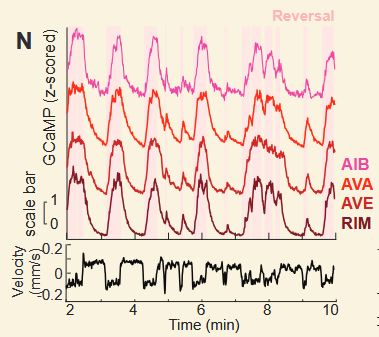

In [ ]:
def plot_lines_neural_activity(calcium_df, n_col_ls,
                               beh_col,hl_col = "forward_sel",hl_color='lightgrey', num_bins=5, title="", color_map='inferno',
                               fs=25, x_bin=0.2, time_range_sel=[],axis_invisible = False,
                               color='#2878B5', x_label='', y_label='',sigma = 5,
                               strip_color='#9AC9DB', p_value=None, r_value=None, p_f=None):
    
    '''
    如果需要高亮事件背景
    hl_col = 'forward_sel'
    '''
    if beh_col not in calcium_df.columns:
        print(f"错误: 行为变量 '{beh_col}' 不存在于数据中。")

    # 提取神经信号
    col_ls  = list(n_col_ls).copy()
    col_ls.append(beh_col)
    col_ls.append('Vol_Time')
    if hl_col:
        col_ls.append(hl_col)
    temp_df = calcium_df[col_ls].copy()
    temp_df.dropna(inplace=True)

    if temp_df.empty:
        print(f"警告: 神经元 '{neuron_name}' 和行为 '{beh_col}' 没有有效数据点可用于绘图。")  
    # 打印时间范围和裁剪时间
    time_range = [calcium_df.Vol_Time.min(), calcium_df.Vol_Time.max()]
    print(f'总的时间范围：{time_range}')
    if len(time_range_sel):
        df = temp_df[(temp_df["Vol_Time"]>=time_range_sel[0])&(temp_df["Vol_Time"]<=time_range_sel[1])]
    else:
        df = temp_df.copy()
    n_row = len(n_col_ls)+1
#     fig,ax = plt.subplots(n_row, 1, figsize = (10, 2.5*n_row))
    fig, ax = plt.subplots(figsize = (10, 1.5*n_row))
    fig.set_constrained_layout(False)
    gs = GridSpec(n_row, 1, height_ratios=[1.5]*n_row, wspace=0.3, hspace=0, figure=fig)
    # 可能画多个折线图
    ax_neu = fig.add_subplot(gs[0:n_row-1], sharex=ax)
    ax_beh = fig.add_subplot(gs[-1], sharex=ax)
    # 神经元trace颜色
    cmap = plt.cm.get_cmap(color_map)
    color_positions = np.linspace(0, 0.8, len(n_col_ls))
    colors = [cmap(pos) for pos in color_positions]
    neuron_to_color = dict(zip(n_col_ls, colors))
    print(df.columns)
    
    # 画神经元Z-score线图
    for i, n_col in enumerate(n_col_ls):
        cal_n = df[n_col].values
        mean = np.nanmean(cal_n)
        std = np.nanstd(cal_n)
        cal_n_z = (cal_n-mean)/std
        # 高斯平滑
        cal_n_z_smoothed = gaussian_filter1d(cal_n_z, sigma=sigma)
        ax_neu.plot(df['Vol_Time'], cal_n_z_smoothed+(i*3), lw = 2,color=neuron_to_color[n_col],label = n_col)
    ax_neu.legend(bbox_to_anchor = (1.0,0.8))
    
    # 画高亮矩形
    if hl_col:
        mask = df[hl_col].values == 1
        # 将值为1的部分高亮
        indices = np.where(mask)[0]
        if len(indices) > 0:
            splits = np.where(np.diff(indices) != 1)[0] + 1
            intervals = np.split(indices, splits)

            for interval in intervals:
                start_idx, end_idx = interval[0], interval[-1]
                start_time, end_time = df['Vol_Time'].iloc[start_idx], df['Vol_Time'].iloc[end_idx]
                ax_neu.axvspan(start_time, end_time, color=hl_color, alpha=0.5)
                ax_beh.axvspan(start_time, end_time, color=hl_color, alpha=0.5)
    
    
    df[beh_col+'smhed'] = gaussian_filter1d(df[beh_col], sigma=sigma)
    ax_beh.plot(df['Vol_Time'], df[beh_col+'smhed'], lw = 2, color='black', label = n_col)
    ax_beh.set_ylabel(beh_col)
    ax_neu.set_title(title, fontsize=fs, pad = fs)
    ax.axis('off')
    if axis_invisible:
        
        # 去掉神经元trace子图边框
        for spine in ax_neu.spines.values():
            spine.set_visible(False)
        ax_neu.tick_params(left=False, right=False, labelleft=False, bottom=False, top=False, labelbottom=False)
        ax_beh.spines['top'].set_visible(False)
        ax_beh.spines['right'].set_visible(False)
    
    plt.show()
        
    

CTX

In [ ]:
beh_col = 'Event'
event_col = [ 'head_velocity']
# df = df_PC_p_cor
# df = df_neu_p_cor
df = df_neu_p_cor
df_cal = df_cal_motion_PCA
ylabel = ''
p_f = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\fdr_bh'
for e_col in event_col:
    df_e = df[df[beh_col]==e_col]  # 找到对应行为的
    sign_neuron_col = df_e[(df_e['p_cor']<0.05) & (df_e['true_r'].abs()>0.3)]['Neuron'].unique()
    print(sign_neuron_col)
    
    plot_lines_neural_activity(df_cal,sign_neuron_col,
                               e_col,color_map='viridis', hl_col='forward_sel',hl_color= '#e0e0e0', axis_invisible=False,num_bins=5, title=f"Significant traces corr {e_col}",)

头部速度

In [ ]:
df_neu_p_cor['Event'].unique()

In [ ]:
beh_col = 'Event'
event_col = ['head_speed']
# df = df_PC_p_cor
# df = df_neu_p_cor
df = df_neu_p_cor
df_cal = df_cal_motion_PCA
ylabel = ''
p_f = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\fdr_bh'
for e_col in event_col:
    df_e = df[df[beh_col]==e_col]  # 找到对应行为的
    sign_neuron_col = df_e[(df_e['p_cor']<0.05) & (df_e['true_r'].abs()>0.3)]['Neuron'].unique()
    print(sign_neuron_col)
    
    plot_lines_neural_activity(df_cal,sign_neuron_col,
                               e_col,hl_col='forward_sel', axis_invisible=True,num_bins=5, title=f"Significant traces corr {e_col}",)

In [ ]:
e_col = "head_velocity"
sign_neuron_col = ['neuron8','neuron14', 'neuron15','neuron37','neuron40']
hl_color_ls = ['#fff7b2','#e0e0e0','#b2d9ff','#d4b2ff', '#ffb2d9']
plot_lines_neural_activity(df_cal,sign_neuron_col,
                               e_col,sigma=4,hl_color ='#e0e0e0',axis_invisible=True, num_bins=5, title=f"Significant traces corr {e_col}")

### 离散变量可视化

In [ ]:

def plot_event_aligned_eve_and_response(calcium_df, event_indices_ls, sel_neuron_col,beh_col,p_val=None,r_val=None,
                                       pre_window=30, post_window=60,sort_by='event',beh_col_title=None,event='',
                                        lc = 'white',heat_cmap='RdBu_r',heat_cb_ylabel = None,
                                       sort_window=None,ctx_sort_window=10,  frame_interval=1.0,test_window = 20,
                                       cmap='jet', unify_yaxis=True, save_path=None, fs=20):
    """
    将所有神经元的事件对齐热图和均值曲线绘制在一张大图中。
    每组图：热图（6列）+ colorbar（1列）+ 均值曲线 + 空白行。
    event_indices_ls: 事件列表，第一维为一个事件，第二维为事件索引
    event_ls: 事件名称列表，应该与event_indices_ls第一个维度对应
    beh_col = 'angle_m'
    sort_by = 'pre'  # or 'post'or 'ctx'
    sort_window = 10  # 如果按照活动排序：排序窗口大小：多少帧
    ctx_sort_window = 10 # 按照CTX变化幅度排序
    test_window = 10 # 显著性检验窗口大小
    """

    if isinstance(calcium_df, np.ndarray):
        calcium_df = pd.DataFrame(calcium_df)

    # 时间轴定义
    time_axis = np.round(np.arange(-pre_window, post_window + 1) * frame_interval, 2)
    # 时间轴上选择7个等间距点，确定刻度位置
    xticks = np.linspace(0, len(time_axis) - 1, 7).astype(int)
    xtick_lbls = time_axis[xticks]
    
    # 统一 y 轴范围
    ymin = ymax = None
#     if unify_yaxis and all_means:
#         ymin = np.nanmin(all_means)*0.5
#         ymax = np.nanmax(all_means)*1.1
    if not len(sel_neuron_col):
        # 打印所有神经元的结果
        sel_neuron_col = [col for col in calcium_df.columns if 'neuron' in col]
#     else:
#         sel_neuron_col = ['neuron'+str(i) for i in sel_neuron_idx]
    print(sel_neuron_col)
    for n_col in sel_neuron_col:
        df_n = calcium_df.loc[:,n_col]
        df_beh = calcium_df[beh_col]
        
        # 对于单个神经元，生成一个列表，每个元素是一个event的traces
        arr = []      # 放入所有事件的trace
        ctx_arr = []  # ctx traces
        
        # 一个行为列可以画多个事件起始，根据事件起始列表的元素数量
        for event_indices in event_indices_ls:
            traces,ctx_traces = [],[]
            print(event_indices)
            for evt in event_indices:
                
                # evt:时间发生的行index
                # start和end找到头和尾的index
                start_idx = evt - pre_window
                end_idx = evt + post_window
                if start_idx >= df_n.index[0] and end_idx <= df_n.index[-1]:
                    trace = df_n.loc[start_idx:end_idx].values
                    traces.append(trace)
                    ctx_traces.append(df_beh.iloc[start_idx:end_idx + 1].values)
                else:
                    print(f'神经元{n_col}在开始索引为{beh_col}事件前后window超出范围')
            if len(traces)>1:
                # 只有事件数量超过2次才保留
                arr_1 = np.array(traces)
                ctx_a = np.array(ctx_traces)
                print(f'神经元{n_col}的事件相关活动对齐矩阵大小为(事次*timestamp){arr_1.shape}')
            else:
                print('足够计算的事件数量不足')

            # 排序
            if sort_by == 'pre':
                if not sort_window:
                    sort_window = pre_window
                print(f'根据时间发生前{pre_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window - sort_window: pre_window], axis=1)
            elif sort_by == 'post':
                if not sort_window:
                    sort_window = post_window
                print(f'根据时间发生后{post_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window: pre_window + sort_window], axis=1)
            elif sort_by == 'event':
                pre = pre_window - ctx_sort_window
                post = pre_window
                print('根据事件变化值排序')
                sort_vals = np.nanmean(ctx_a[:, post:post + ctx_sort_window], axis=1) - \
                           np.nanmean(ctx_a[:, pre:pre + ctx_sort_window], axis=1)

            sorted_indices = np.argsort(-sort_vals)  # 高到低排序
            arr_1 = arr_1[sorted_indices]
            ctx_a = ctx_a[sorted_indices]
            arr.append(arr_1)
            ctx_arr.append(ctx_a)


        # 对每个神经元画图
        fig = plt.figure(figsize=(6, 6*len(event_idx_ls)))  # 每个 neuron 高度小一点
        gs = GridSpec(nrows=8*len(event_idx_ls), ncols=8,  # 每个神经元占3行（热图、线图、空白）
           height_ratios=[3,3,3,3,3,1,1,1]*len(event_idx_ls),
           width_ratios=[0.15, 1,1, 1, 1, 1, 1, 0.1],  # 第7列窄一些用于 colorbar
           hspace=0.1, wspace=0.2)
        for i,  arr_i in enumerate(arr):
            row_base = i*8
            ax_ctx = fig.add_subplot(gs[row_base:row_base+3, 1:4])   # ctx热图
            ax_cb_ctx = fig.add_subplot(gs[row_base:row_base+3, 0])
            ax_h = fig.add_subplot(gs[row_base:row_base+3, 4:7])     # 热图：3行高
            ax_cb = fig.add_subplot(gs[row_base:row_base+3, 7])      # colorbar：3行高，0.1列
            ax_m = fig.add_subplot(gs[row_base+3:row_base+5, 4:7])   # 均值线图：2行高
            ax_blank = fig.add_subplot(gs[row_base+5:row_base+8, 0:7])  # 空白：3行
            ax_blank.axis('off')
            
            # 热图：ctx
            sns.heatmap(ctx_arr[i], cmap=heat_cmap, ax=ax_ctx, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb_ctx, vmin=np.nanmin(ctx_arr[i]), vmax=np.nanmax(ctx_arr[i]))
            ax_ctx.axvline(pre_window, color=lc, ls='--', lw = 2)
#             ax_ctx.set_ylabel('Events')
            if beh_col_title:
                ax_ctx.set_title(beh_col_title,fontsize =fs)
            else:
                ax_ctx.set_title(beh_col,fontsize =fs)
            ax_cb_ctx.yaxis.set_ticks_position('left')
            ax_cb_ctx.yaxis.set_label_position('left')
            ax_cb_ctx.set_ylabel(heat_cb_ylabel, fontsize=fs)

            # 热图：钙信号
            sns.heatmap(arr_i, cmap=cmap, ax=ax_h, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb,
                        vmin=np.nanmin(arr_i), vmax=np.nanmax(arr_i))
            ax_h.axvline(pre_window, color=lc, ls='--', lw = 2)
            ax_cb.set_ylabel("ΔR/R", fontsize=fs*0.85)
#             ax_h.set_ylabel([])
            ax_h.set_xlabel('')
            ax_h.set_title(n_col, fontsize =fs)

            # 均值线图，sns绘图
            df_long = pd.DataFrame(arr_i, columns=time_axis)
            df_long['Trial'] = np.arange(len(df_long))  # 每一行为一个trial
            # 宽表格转为长表格，原本每个时间点为一列，改成合并为Time列，另外每一个element的活动值转为Activity列值
            df_long = df_long.melt(id_vars='Trial', var_name='Time', value_name='Activity')

#             sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
#                  ci='sd', color='grey', label='Mean ± STD', alpha=0.3)
            sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
                 ci='sd', color='grey', alpha=0.3, lw = 2)
            sns.set_style('white')  # 设置白色背景
            ax_m.set_facecolor("white")  # 背景白色
            ax_m.axvline(0, color='red', ls='--', lw = 2)

            if ymin is not None and ymax is not None:
                ax_m.set_ylim(ymin, ymax)
            # 避免 x 轴范围包含 nan
            mean_trace = np.mean(arr_i, axis = 0)
            x_valid = ~np.isnan(time_axis) & ~np.isnan(mean_trace)
            if x_valid.any():
                ax_m.set_xlim(time_axis[x_valid][0], time_axis[x_valid][-1])
            ax_m.set_xlabel(f'Time (s){event} at t=0',fontsize =fs*0.85)
            ax_m.set_ylabel('ΔR/R',fontsize =fs*0.85)
            ax_m.yaxis.tick_right()           # 把 y 轴的刻度移到右边
            ax_m.yaxis.set_label_position("right")  # 把 y 轴标签也移到右边
            ax_m.axvline(0, color='red', ls='--', lw = 2)
            ax_m.spines['left'].set_visible(False)
            ax_m.spines['right'].set_visible(False)

#             ax_m.legend(loc='upper right', fontsize=8)

#             # 加入配对t检验，结果显示在曲线上方
#             # 提取事件前后的平均值（每行是一个 trial 的平均）
#             pre_vals = np.nanmean(arr_i[:, pre_window - test_window : pre_window], axis=1)
#             post_vals = np.nanmean(arr_i[:, pre_window : pre_window + test_window], axis=1)

#             # 进行配对 t 检验
#             t_stat, p_val = ttest_rel(post_vals, pre_vals, nan_policy='omit')
            if p_val:
                # 显著性标记（可自定义阈值）
                if p_val < 0.001:
                    sig_label = '***'
                elif p_val < 0.01:
                    sig_label = '**'
                elif p_val < 0.05:
                    sig_label = '*'
                else:
                    sig_label = 'n.s.'

                # 将显著性结果写在均值图中间上方
                # 坐标轴右上角（与 legend 靠近）
#                 x_max = time_axis[x_valid][-1] if x_valid.any() else time_axis[-1]
#                 y_mean = np.nanmean(df_long['Activity'])

#                 ax_m.text(x_max*0.95, y_mean*1.2, f'p = {p_val:.3g} ({sig_label})',
#                           ha='right', va='bottom', fontsize=9, color='black')
            if r_val:
                # 标记相关性
                x_min, x_max = ax_m.get_xlim()
                y_min, y_max = ax_m.get_ylim()
                ax_m.text(x_min + 0.05*(x_max - x_min),  # x坐标：离左边一点
                  y_max - 0.05*(y_max - y_min),  # y坐标：离顶部一点
                  f'r = {r_val:.3g}({sig_label})',
                  ha='left', va='top', fontsize=12, color='red')

#                 ax_m.text(x_max*0.95, y_mean*0.75, f'r = {r_val:.3g}',
#                           ha='right', va='bottom', fontsize=9, color='red')

        plt.tight_layout()

        if save_path:
            os.makedirs(save_path, exist_ok=True)
#             event_list_joined = ''.join(event_ls)
            out_path = os.path.join(save_path, f'Neuron{beh_col}{n_col}Alg{event}.png')
            plt.savefig(out_path, dpi=150)
            plt.show()
            plt.close()
        else:
            plt.show()
    

In [ ]:
plot_event_aligned_eve_and_response(df_cal_motion_PCA, [rev_start_vol_idx], ['neuron41'],'cos_m',0.0001,0.52,
                                       pre_window=30, post_window=30,sort_by='event',beh_col_title='heading direction',event='reverse start',
                                            lc = 'white',heat_cmap='RdBu',heat_cb_ylabel = 'cosθ',
                                       sort_window=None,ctx_sort_window=10,  frame_interval=1.0,test_window = 20,
                                       cmap='jet', unify_yaxis=True, save_path=p_f, fs=20)

In [ ]:
# 事件对齐作图希望显示的变量列
beh_col = 'cos_m'

# 显著性检验df
df = df_neu_p_cor
# 显著性检验df中存放行为事件的列名
event_col = 'Event'
# 行为事件的名称，长度与行为索引列表对应
# event_list = ['rev_start', 'rev_end']
# 行为索引列表
event_indices_dict = beh_onset_idx_dict


# df = df_neu_p_cor
ylabel = ''
p_f = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\fdr_bh'
for i,(e_col,e_idx_ls) in enumerate(event_indices_dict.items()):
    df_e = df[df[event_col]==e_col]  # 找到对应事件的切片
    sign_neuron_col = df_e[(df_e['p_cor']<0.05) & (df_e['true_r'].abs()>0.1)]['Neuron'].unique()
    print(sign_neuron_col)
    # 对应事件的事件索引列表
    for n_col in sign_neuron_col:
        p_val = df_e[df_e['Neuron']==n_col]['p_cor'].values[0]
        r = df_e[df_e['Neuron']==n_col]['true_r'].values[0]
        plot_event_aligned_eve_and_response(df_cal_motion_PCA, [e_idx_ls], [n_col],beh_col,p_val,r,
                                       pre_window=30, post_window=30,sort_by='event',beh_col_title='heading direction',event=e_col,
                                            lc = 'white',heat_cmap='RdBu_r',heat_cb_ylabel = 'cosθ',
                                       sort_window=None,ctx_sort_window=10,  frame_interval=1.0,test_window = 20,
                                       cmap='jet', unify_yaxis=True, save_path=p_f, fs=20)
        # lc = 'white'  热图线的颜色

In [ ]:
def plot_event_aligned_response_2(calcium_df, event_indices_ls, sel_neuron_col,beh_col,p_val=None,r_val=None,
                                       pre_window=30, post_window=60,sort_by='event',beh_col_title=None,event='',
                                        lc = 'white',heat_cmap='RdBu_r',heat_cb_ylabel = None,
                                       sort_window=None,ctx_sort_window=10,  frame_interval=1.0,test_window = 20,
                                       cmap='jet', unify_yaxis=True, save_path=None, fs=20):
    """
    将所有神经元的事件对齐热图和均值曲线绘制在一张大图中。
    每组图：热图（6列）+ colorbar（1列）+ 均值曲线 + 空白行。
    event_indices_ls: 事件列表，第一维为一个事件，第二维为事件索引
    event_ls: 事件名称列表，应该与event_indices_ls第一个维度对应
    beh_col = 'angle_m'
    sort_by = 'pre'  # or 'post'or 'ctx'
    sort_window = 10  # 如果按照活动排序：排序窗口大小：多少帧
    ctx_sort_window = 10 # 按照CTX变化幅度排序
    test_window = 10 # 显著性检验窗口大小
    """

    if isinstance(calcium_df, np.ndarray):
        calcium_df = pd.DataFrame(calcium_df)

    # 时间轴定义
    time_axis = np.round(np.arange(-pre_window, post_window + 1) * frame_interval, 2)
    # 时间轴上选择7个等间距点，确定刻度位置
    xticks = np.linspace(0, len(time_axis) - 1, 7).astype(int)
    xtick_lbls = time_axis[xticks]
    
    # 统一 y 轴范围
    ymin = ymax = None
#     if unify_yaxis and all_means:
#         ymin = np.nanmin(all_means)*0.5
#         ymax = np.nanmax(all_means)*1.1
    if not len(sel_neuron_col):
        # 打印所有神经元的结果
        sel_neuron_col = [col for col in calcium_df.columns if 'neuron' in col]
#     else:
#         sel_neuron_col = ['neuron'+str(i) for i in sel_neuron_idx]
    print(sel_neuron_col)
    for n_col in sel_neuron_col:
        df_n = calcium_df.loc[:,n_col]
        df_beh = calcium_df[beh_col]
        
        # 对于单个神经元，生成一个列表，每个元素是一个event的traces
        arr = []      # 放入所有事件的trace
        ctx_arr = []  # ctx traces
        
        # 一个行为列可以画多个事件起始，根据事件起始列表的元素数量
        for event_indices in event_indices_ls:
            traces,ctx_traces = [],[]
            print(event_indices)
            for evt in event_indices:
                
                # evt:时间发生的行index
                # start和end找到头和尾的index
                start_idx = evt - pre_window
                end_idx = evt + post_window
                if start_idx >= df_n.index[0] and end_idx <= df_n.index[-1]:
                    trace = df_n.loc[start_idx:end_idx].values
                    traces.append(trace)
                    ctx_traces.append(df_beh.iloc[start_idx:end_idx + 1].values)
                else:
                    print(f'神经元{n_col}在开始索引为{beh_col}事件前后window超出范围')
            if len(traces)>1:
                # 只有事件数量超过2次才保留
                arr_1 = np.array(traces)
                ctx_a = np.array(ctx_traces)
                print(f'神经元{n_col}的事件相关活动对齐矩阵大小为(事次*timestamp){arr_1.shape}')
            else:
                print('足够计算的事件数量不足')

            # 排序
            if sort_by == 'pre':
                if not sort_window:
                    sort_window = pre_window
                print(f'根据时间发生前{pre_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window - sort_window: pre_window], axis=1)
            elif sort_by == 'post':
                if not sort_window:
                    sort_window = post_window
                print(f'根据时间发生后{post_window}帧的活动从高到低排序')
                sort_vals = np.nanmean(arr_1[:, pre_window: pre_window + sort_window], axis=1)
            elif sort_by == 'event':
                pre = pre_window - ctx_sort_window
                post = pre_window
                print('根据事件变化值排序')
                sort_vals = np.nanmean(ctx_a[:, post:post + ctx_sort_window], axis=1) - \
                           np.nanmean(ctx_a[:, pre:pre + ctx_sort_window], axis=1)

            sorted_indices = np.argsort(-sort_vals)  # 高到低排序
            arr_1 = arr_1[sorted_indices]
            ctx_a = ctx_a[sorted_indices]
            arr.append(arr_1)
            ctx_arr.append(ctx_a)


        # 对每个神经元画图
#         fig = plt.figure(figsize=(6, 6*len(event_idx_ls)))  # 每个 neuron 高度小一点
#         gs = GridSpec(nrows=8*len(event_idx_ls), ncols=8,  # 每个神经元占3行（热图、线图、空白）
#            height_ratios=[3,3,3,3,3,1,1,1]*len(event_idx_ls),
#            width_ratios=[0.15, 1,1, 1, 1, 1, 1, 0.1],  # 第7列窄一些用于 colorbar
#            hspace=0.1, wspace=0.2)
        fig = plt.figure(figsize=(18, 6))  # 宽一些
        gs = GridSpec(
            nrows=1, ncols=9,  # 1行9列
            width_ratios=[0.15, 1, 1, 1, 1, 1, 1,0.15, 3],  # 根据需要微调
            wspace=0.3, hspace=0.05, figure=fig
        )
        for i,  arr_i in enumerate(arr):
            row_base = i*8
            ax_ctx = fig.add_subplot(gs[row_base:row_base+3, 1:4])   # ctx热图
            ax_cb_ctx = fig.add_subplot(gs[row_base:row_base+3, 0])
            ax_h = fig.add_subplot(gs[row_base:row_base+3, 4:7])     # 热图：3行高
            ax_cb = fig.add_subplot(gs[row_base:row_base+3, 7])      # colorbar：3行高，0.1列
            ax_m = fig.add_subplot(gs[row_base:row_base+3, 8])   # 均值线图：2行高
#             ax_blank = fig.add_subplot(gs[row_base+5:row_base+8, 0:7])  # 空白：3行
#             ax_blank.axis('off')
            
            # 热图：ctx
            sns.heatmap(ctx_arr[i], cmap=heat_cmap, ax=ax_ctx, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb_ctx, vmin=np.nanmin(ctx_arr[i]), vmax=np.nanmax(ctx_arr[i]))
            ax_ctx.axvline(pre_window, color=lc, ls='--', lw = 2)
#             ax_ctx.set_ylabel('Events')
            if beh_col_title:
                ax_ctx.set_title(beh_col_title,fontsize =fs)
            else:
                ax_ctx.set_title(beh_col,fontsize =fs)
            ax_cb_ctx.yaxis.set_ticks_position('left')
            ax_cb_ctx.yaxis.set_label_position('left')
            ax_cb_ctx.set_ylabel(heat_cb_ylabel, fontsize=fs)

            # 热图：钙信号
            sns.heatmap(arr_i, cmap=cmap, ax=ax_h, xticklabels=False, yticklabels=False,
                        cbar=True, cbar_ax=ax_cb,
                        vmin=np.nanmin(arr_i), vmax=np.nanmax(arr_i))
            ax_h.axvline(pre_window, color=lc, ls='--', lw = 2)
            ax_cb.set_ylabel("ΔR/R", fontsize=fs*0.85)
#             ax_h.set_ylabel([])
            ax_h.set_xlabel('')
            ax_h.set_title(n_col, fontsize =fs)

            # 均值线图，sns绘图
            df_long = pd.DataFrame(arr_i, columns=time_axis)
            df_long['Trial'] = np.arange(len(df_long))  # 每一行为一个trial
            # 宽表格转为长表格，原本每个时间点为一列，改成合并为Time列，另外每一个element的活动值转为Activity列值
            df_long = df_long.melt(id_vars='Trial', var_name='Time', value_name='Activity')

#             sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
#                  ci='sd', color='grey', label='Mean ± STD', alpha=0.3)
            sns.lineplot(data=df_long, x='Time', y='Activity', ax=ax_m, 
                 ci='sd', color='grey', alpha=0.3, lw = 2)
            sns.set_style('white')  # 设置白色背景
            ax_m.set_facecolor("white")  # 背景白色
            ax_m.axvline(0, color='red', ls='--', lw = 2)

            if ymin is not None and ymax is not None:
                ax_m.set_ylim(ymin, ymax)
            # 避免 x 轴范围包含 nan
            mean_trace = np.mean(arr_i, axis = 0)
            x_valid = ~np.isnan(time_axis) & ~np.isnan(mean_trace)
            if x_valid.any():
                ax_m.set_xlim(time_axis[x_valid][0], time_axis[x_valid][-1])
            ax_m.set_xlabel(f'Time (s){event} at t=0',fontsize =fs*0.85)
            ax_m.set_ylabel('ΔR/R',fontsize =fs*0.85)
            ax_m.yaxis.tick_right()           # 把 y 轴的刻度移到右边
            ax_m.yaxis.set_label_position("right")  # 把 y 轴标签也移到右边
            ax_m.axvline(0, color='red', ls='--', lw = 2)
            ax_m.spines['left'].set_visible(False)
            ax_m.spines['right'].set_visible(False)

#             ax_m.legend(loc='upper right', fontsize=8)

#             # 加入配对t检验，结果显示在曲线上方
#             # 提取事件前后的平均值（每行是一个 trial 的平均）
#             pre_vals = np.nanmean(arr_i[:, pre_window - test_window : pre_window], axis=1)
#             post_vals = np.nanmean(arr_i[:, pre_window : pre_window + test_window], axis=1)

#             # 进行配对 t 检验
#             t_stat, p_val = ttest_rel(post_vals, pre_vals, nan_policy='omit')
            if p_val:
                # 显著性标记（可自定义阈值）
                if p_val < 0.001:
                    sig_label = '***'
                elif p_val < 0.01:
                    sig_label = '**'
                elif p_val < 0.05:
                    sig_label = '*'
                else:
                    sig_label = 'n.s.'

                # 将显著性结果写在均值图中间上方
                # 坐标轴右上角（与 legend 靠近）
#                 x_max = time_axis[x_valid][-1] if x_valid.any() else time_axis[-1]
#                 y_mean = np.nanmean(df_long['Activity'])

#                 ax_m.text(x_max*0.95, y_mean*1.2, f'p = {p_val:.3g} ({sig_label})',
#                           ha='right', va='bottom', fontsize=9, color='black')
            if r_val:
                # 标记相关性
                x_min, x_max = ax_m.get_xlim()
                y_min, y_max = ax_m.get_ylim()
                ax_m.text(x_min + 0.05*(x_max - x_min),  # x坐标：离左边一点
                  y_max - 0.05*(y_max - y_min),  # y坐标：离顶部一点
                  f'r = {r_val:.3g}({sig_label})',
                  ha='left', va='top', fontsize=12, color='red')

#                 ax_m.text(x_max*0.95, y_mean*0.75, f'r = {r_val:.3g}',
#                           ha='right', va='bottom', fontsize=9, color='red')

        plt.tight_layout()

        if save_path:
            os.makedirs(save_path, exist_ok=True)
#             event_list_joined = ''.join(event_ls)
            out_path = os.path.join(save_path, f'Neuron{beh_col}{n_col}Alg{event}.png')
            plt.savefig(out_path, dpi=150)
            plt.show()
            plt.close()
        else:
            plt.show()
    

In [ ]:
# 事件对齐作图希望显示的变量列
beh_col = 'cos_m'

# 显著性检验df
df = df_neu_p_cor
# 显著性检验df中存放行为事件的列名
event_col = 'Event'
# 行为事件的名称，长度与行为索引列表对应
# event_list = ['rev_start', 'rev_end']
# 行为索引列表
event_indices_dict = beh_onset_idx_dict


# df = df_neu_p_cor
ylabel = ''
p_f = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06\Figs\fdr_bh'
for i,(e_col,e_idx_ls) in enumerate(event_indices_dict.items()):
    df_e = df[df[event_col]==e_col]  # 找到对应事件的切片
    sign_neuron_col = df_e[(df_e['p_cor']<0.05) & (df_e['true_r'].abs()>0.1)]['Neuron'].unique()
    print(sign_neuron_col)
    # 对应事件的事件索引列表
    for n_col in sign_neuron_col:
        p_val = df_e[df_e['Neuron']==n_col]['p_cor'].values[0]
        r = df_e[df_e['Neuron']==n_col]['true_r'].values[0]
        plot_event_aligned_response_2(df_cal_motion_PCA, [e_idx_ls], [n_col],beh_col,p_val,r,
                                       pre_window=30, post_window=30,sort_by='event',beh_col_title='heading direction',event=e_col,
                                            lc = 'white',heat_cmap='RdBu_r',heat_cb_ylabel = 'cosθ',
                                       sort_window=None,ctx_sort_window=10,  frame_interval=1.0,test_window = 20,
                                       cmap='jet', unify_yaxis=True, save_path=p_f, fs=20)
        # lc = 'white'  热图线的颜色

In [ ]:
# 选择显著的神经元进行分组箱线图可视化
def plot_binned_neural_activity(calcium_df, neuron_col,
                                beh_col, num_bins=5, title="",
                                fs=25,x_bin = 0.2,
                               color='#2878B5',x_label = '',y_label = 'ΔR/R',
                               strip_color ='#9AC9DB',p_value=None,r_value=None, p_f = None):
    """
    根据行为变量的分箱，绘制神经活动的箱线图。
    calcium_df: 包含行为变量曲线的df
    neuron_idx: 神经元索引
    beh_col:变量列名
    """
    if beh_col not in calcium_df.columns:
        print(f"错误: 行为变量 '{beh_col}' 不存在于数据中。")
        return
#     neuron_name = 'neuron'+str(neuron_idx)
    neuron_name = neuron_col
    # 提取神经信号
    temp_df = calcium_df[[neuron_name, beh_col]].copy()
    temp_df.dropna(inplace=True)

    if temp_df.empty:
        print(f"警告: 神经元 '{neuron_name}' 和行为 '{beh_col}' 没有有效数据点可用于绘图。")
        return
    
    # 求出行为变量的上下界
    min_beh_val = temp_df[beh_col].min()
    max_beh_val = temp_df[beh_col].max()
    
    # 将行为变量分箱
    temp_df['beh_bin'], bins = pd.cut(
        temp_df[beh_col],
        bins=num_bins,
        labels=False,
        include_lowest=True,
        retbins=True,
        duplicates='drop'
    )

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    temp_df['bin_center'] = temp_df['beh_bin'].map(lambda x: bin_centers[int(x)] if pd.notna(x) else np.nan)
    sorted_temp_df = temp_df.sort_values(by='bin_center', ascending=True)

    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    sns.boxplot(
        x='bin_center',
        y=neuron_name,
        data=sorted_temp_df,
        showcaps=True,
        color = color,
        boxprops=dict(facecolor='none', edgecolor='grey', linewidth=2),
        whiskerprops=dict(color='grey', linewidth=2),
        capprops=dict(color='grey', linewidth=2),
        medianprops=dict(color='black', linewidth=5),
        showfliers=False
    )
     # 叠加散点图
    sns.stripplot(
        x='bin_center',
        y=neuron_name,
        data=sorted_temp_df,
        color=strip_color,
        size=10,
        alpha=0.1,
        jitter=True
    )
    if title:
        plt.title(f"#{neuron_name} {title}",
                  fontsize=fs, pad=fs)
    else:
        plt.title(f"#{neuron_name} Activity over {beh_col}",
                  fontsize=fs, pad=fs)
    if x_label:
        plt.xlabel(f"{x_label}", fontsize=fs*0.75, labelpad=fs*0.75)
    else:
        plt.xlabel(f"{beh_col}", fontsize=fs*0.75, labelpad=fs*0.75)
    plt.axhline(y=0, ls='dashed', color='black', linewidth=2)
    plt.ylabel(y_label, fontsize=fs*0.75)
    
    # 手动设置标签
    ax.set_xticklabels([]) # Clear existing labels
    
    bin_center = list(sorted_temp_df['bin_center'].unique())
    print(bin_center)
    custom_labels_sparse =  [f"{x:.1f}" for x in bin_center]

#     ax.set_xticks(custom_positions)
    ax.set_xticklabels(custom_labels_sparse, rotation=45, ha='right')
    ax.tick_params(axis='x', labelsize=fs*0.75)
    ax.tick_params(axis='y', labelsize=fs*0.75)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 添加p值和相关性系数信息
        
    stat_text = ""
    if r_value is not None:
        stat_text += f"$r$ = {r_value:.2f}  "
    if p_value is not None:
        if p_value < 0.001:
            stat_text += f"\n$p$ < 0.001"
        else:
            stat_text += f"\n$p$ = {p_value:.3f}"
    if stat_text:
        plt.text(0.5, 0.9, stat_text, fontsize=fs*0.7, ha='center', va='center',color='red', transform=ax.transAxes)
    if p_f:
        os.makedirs(p_f, exist_ok=True)
        file_path = os.path.join(p_f, f'bin{beh_col}_{neuron_name}_{x_label}_activity.png')
        plt.savefig(file_path, bbox_inches='tight')
        
    
    plt.tight_layout()
    plt.show()

In [ ]:
neuron_idx_ls = [60,63,64,73,86]
beh_col_show = 'smoothed_CTX'
title = 'over CTX'
# df_p_result中保存了以上神经元检验的所有信息
df_p = df_p_result.copy()
for n_id in neuron_idx_ls:
#     p_value = df_p[(df_p['Neuron']==n_id)&(df_p['Behavior']==beh_col_show)]['p_cor'].values[0]
    r_value = df_p[(df_p['Neuron']==str(n_id))&(df_p['Behavior']==beh_col_show)]['true_r'].values[0]
    
    plot_binned_neural_activity(df_cal_motion, n_id, beh_col_show, num_bins=9,
                                title=title, x_label = 'CTX_left',fs=25,
                                r_value=r_value
                               )

## PCA结果可视化

In [ ]:
# 浅色背景

fig, ax = plt.subplots()
label = 'forward_sel'
# 绘制散点图，并返回散点图对象
sc = ax.scatter(df_cal_motion_PCA['PC1'], df_cal_motion_PCA['PC2'], c = df_cal_motion_PCA[label].map({1:'red',0:'blue'}),s=1)
df_reo = df_cal_motion_PCA[df_cal_motion_PCA['Reorientation']==1]
# start = ax.scatter(df_reo['PC1'], df_reo['PC2'], s=10, marker='*', c = 'r')
# sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=df_nt.X.max(), vmax=df_nt.X.min()))
# sm.set_array([])  # 需要设置数组，即使它是空的
fig.patch.set_facecolor('white')  # 浅蓝色背景（整个图）
#  #303030， #444444
# ax.set_facecolor('#2b2b3c')         # 浅蓝色背景（坐标区）
# 添加颜色条，并设置标签
# plt.colorbar(sc, label=label)
plt.axis('off')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:


fig, ax = plt.subplots(figsize=(6,6))
label = 'forward_sel'
# 按时间排序
df_cal_motion_PCA_sorted = df_cal_motion_PCA.sort_values('Time')

x = df_cal_motion_PCA_sorted['PC1'].values
y = df_cal_motion_PCA_sorted['PC2'].values
labels = df_cal_motion_PCA_sorted[label].values
# 可选：用Savitzky-Golay滤波平滑轨迹
window_size = 15  # 必须是奇数且小于数据点数量
poly_order = 3
x_smooth = savgol_filter(x, window_size, poly_order)
y_smooth = savgol_filter(y, window_size, poly_order)

# 遍历相邻点对，根据label绘制线段
for i in range(len(x_smooth)-1):
    xi, yi = x_smooth[i], y_smooth[i]
    xj, yj = x_smooth[i+1], y_smooth[i+1]
    li = labels[i]
    color = 'red' if li == 1 else 'blue'
    ax.plot([xi, xj], [yi, yj], color=color, linewidth=1.2, alpha=0.7)

# 高亮reorientation点
# df_reo = df_cal_motion_PCA_sorted[df_cal_motion_PCA_sorted['Reorientation']==1]
# ax.scatter(df_reo['PC1'], df_reo['PC2'], s=30, marker='*', c='yellow', label='Reorientation')

fig.patch.set_facecolor('white')
ax.set_facecolor('white') 
plt.axis('off')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper right', frameon=False)
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

# 按时间排序
df_sorted = df_cal_motion_PCA.sort_values('Time')

# 提取并可选平滑
x = df_sorted['PC1'].values
y = df_sorted['PC2'].values
time = df_sorted['Time'].values/60

# 可选平滑
window_size = 15
poly_order = 3
x_smooth = savgol_filter(x, window_size, poly_order)
y_smooth = savgol_filter(y, window_size, poly_order)

# 构建 segments：相邻点对连成的线段
points = np.array([x_smooth, y_smooth]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# 归一化时间到0-1区间
# norm_time = (time - time.min()) / (time.max() - time.min())

# 创建连续渐变颜色映射
norm = mcolors.Normalize(vmin=time.min(), vmax=time.max())
cmap = plt.get_cmap('viridis')

lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1.5)
lc.set_array(time)  # 使用归一化时间作为渐变依据

line = ax.add_collection(lc)

# 可选：添加颜色条表示时间
# cb = plt.colorbar(lc, ax=ax, label='Time (min)')
cb = fig.colorbar(lc, ax=ax, orientation='horizontal', pad=0.15, label='Time(min)')
cb.ax.tick_params(labelsize=14)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.set_label('Time(min)', fontsize=16, labelpad=10)

fig.patch.set_facecolor('white')
ax.set_facecolor('white') 
ax.autoscale()
# ax.set_aspect('equal')
plt.axis('off')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper right', frameon=False)
plt.show()

In [ ]:
# 深色背景

fig, ax = plt.subplots()
label = 'forward_sel'
# 绘制散点图，并返回散点图对象
sc = ax.scatter(df_cal_motion_PCA['PC1'], df_cal_motion_PCA['PC2'], c = df_cal_motion_PCA[label].map({1:'yellow',0:'lightgrey'}),s=1)
df_reo = df_cal_motion_PCA[df_cal_motion_PCA['Reorientation']==1]
# start = ax.scatter(df_reo['PC1'], df_reo['PC2'], s=10, marker='*', c = 'r')
# sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=df_nt.X.max(), vmax=df_nt.X.min()))
# sm.set_array([])  # 需要设置数组，即使它是空的
fig.patch.set_facecolor('#303030')  # 浅蓝色背景（整个图）
#  #303030， #444444
# ax.set_facecolor('#2b2b3c')         # 浅蓝色背景（坐标区）
# 添加颜色条，并设置标签
# plt.colorbar(sc, label=label)
plt.axis('off')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Reorientation事件可视化

In [ ]:
# 可视化重定向的位置，找到索引
vector = df_PCA_motion.Reorientation.values
remove_event = False

# 将一维向量扩展为二维（例如 1 行或 1 列）
heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
# Define two colors
colors = ['green', 'red']
# Create a ListedColormap
two_color_cmap = ListedColormap(colors)

if remove_event:
    # Define the size of the structuring element
    structure_size = 5
    # Perform opening
    opened_vector = grey_opening(heatmap_data, size=structure_size)
    structure_size = 13
    # Perform closing
    vector = grey_closing(opened_vector, size=structure_size)

    plt.figure(figsize=(20, 1))  # 设置热图大小
    plt.imshow(opened_vector, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
    plt.colorbar(label='Value')  # 添加颜色条
    plt.title('Removed small turnings')
    plt.xticks()  # 设置x轴刻度
    plt.yticks([])  # 隐藏y轴刻度
    # plt.title("Heatmap of 1D Vector")
    plt.show()
else:
    # 绘制热图
    plt.figure(figsize=(20, 1))  # 设置热图大小
    plt.imshow(heatmap_data, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
    plt.colorbar(label='Value')  # 添加颜色条
    plt.xticks([])  # 设置x轴刻度
    plt.yticks([])  # 隐藏y轴刻度
    # plt.title("Heatmap of 1D Vector")
    plt.show()


# 找到Reorientation分隔的起始点
# np.diff计算临近点的差值，随后返回索引
start_indices = np.where(np.diff(np.insert(vector, 0, 0)) == 1)[0]
end_indices = np.where(np.diff(np.append(vector, 0)) == -1)[0]
print('start_indices', start_indices)
print('end_indices', end_indices)

In [ ]:
df_cut = df_PCA_motion.loc[500:1000,:]
plt.scatter(df_cut['X'], df_cut['Y'], s = 0.8, c = df_cut['Vol_Time'],cmap = 'Blues')
plt.axis("equal")
plt.colorbar()

In [ ]:

df_cut = df_PCA_motion
prob_1 = 0.03
rand_list = np.random.choice([0, 1], size=len(df_cut), p=[1 - prob_1, prob_1])
df_cut['rand'] = rand_list

fig,ax = plt.subplots(2,1,figsize = (20,8))
a0 = ax[0].scatter(df_cut['X'], df_cut['Y'], s = 0.8, c = df_cut['smoothed_angle_m'],cmap = 'jet')
df_rand = df_cut[df_cut['rand'] == 1].copy()
df_rand['Int_Time'] = df_rand['Vol_Time'].astype(int)
for i, row in df_rand.iterrows():
    ax[0].scatter(row['X'], row['Y'], s=20, marker='*', color='black')
    ax[0].text(row['X'], row['Y']+0.1, s=row['Int_Time'], fontsize=12, color='black')
ax[0].axis("equal")
plt.colorbar(a0, ax = ax[0])
a1 = ax[1].scatter(df_cut['X'], df_cut['Y'], s = 0.8, c = df_cut['Vol_Time'],cmap = 'Blues')
ax[1].axis("equal")
plt.colorbar(a1, ax=ax[1])

In [ ]:
# 画所有PC和行为组合的相关性

fs = 20
folder = r'Z:\data space+\C. elegans chemotaxis\20241223_WBI\121906fig'
pc_cols = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
x_cols = ['X','Vol_time', 'speed', 'agl_speed','CTX_left','Reorientation']
for i,pc in enumerate(pc_cols):
    for j, x_col in enumerate(x_cols):
        plt.figure(figsize = (20,5))
        plt.scatter(df_nt_mx[x_col], df_nt_mx[pc])
        plt.xlabel(x_col, fontsize = fs)
        plt.ylabel(pc, fontsize = fs)
        filename = pc+'-'+x_col
        plt.savefig(os.path.join(folder,filename))

In [ ]:
df_PCA_motion['angle_m'].hist()

In [ ]:
file = '20241219_4.5g-ov_06_mot_vid_mid.csv'
p_f = r"Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06"
df = pd.read_csv(os.path.join(p_f, file))

In [ ]:
df['angle_m'].hist()

In [ ]:
p_f = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\good_WBI\20241219_4.5g-ov_06'
f = 'output-0516.npz'
npz_data = np.load(os.path.join(p_f,f), allow_pickle=True)
data = npz_data['arr_0'].item()
data_keys = list(data.keys())   # 存储的符合条件的帧数
rows = []
for key in data_keys:
    item = data[key]
    row = {
        'key': key,   # 对应视频帧
        'angle_m': item['angle_m'],  # 头部朝向与运动方向夹角
        'all_paths':item['all_paths']  # 完整的骨架信息
    }
    rows.append(row)
df = pd.DataFrame(rows).set_index('key')

In [ ]:
df['angle_m'].hist()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(figsize = (20,15))
fs = 30
label = 'Vol_time'
# 绘制散点图，并返回散点图对象
sc = ax.scatter(df_nt_mx['PC1'], df_nt_mx['PC2'], c=df_nt_mx.index,cmap='jet', s=0.8)
df_nt_start = df_nt_mx.loc[start_indices]

ls_all_idx = list(df_nt_mx.index)
str_all_ls_idx = list(map(str,ls_all_idx))

for x, y, text in zip(df_nt_mx['PC1'], df_nt_mx['PC2'], str_all_ls_idx):
    plt.text(x, y, text, color='k', fontsize=fs*0.5)

df_nt_end = df_nt_mx.loc[end_indices]
ls_s_idx = list(df_nt_start.index)
str_s_ls_idx = list(map(str,ls_s_idx))
for x, y, text in zip(df_nt_start['PC1'], df_nt_start['PC2'], str_s_ls_idx):
    plt.text(x, y, text, color='r', fontsize=fs)

ls_e_idx = list(df_nt_end.index)
str_e_ls_idx = list(map(str,ls_e_idx))
for x, y, text in zip(df_nt_end['PC1'], df_nt_end['PC2'], str_e_ls_idx):
    plt.text(x, y, text, color='g', fontsize=fs)    

start = ax.scatter(df_nt_start['PC1'], df_nt_start['PC2'], s=fs, marker='>', c = 'r')
end = ax.scatter(df_nt_end['PC1'], df_nt_end['PC2'], s=fs, marker='<', c = 'g')
# sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=df_nt.X.max(), vmax=df_nt.X.min()))
# sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
plt.colorbar(sc, label=label)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [ ]:

fig, ax = plt.subplots()
label = 'Vol_time'
# 绘制散点图，并返回散点图对象
sc = ax.scatter(df_nt_mx['PC1'], df_nt_mx['PC2'], c=df_nt_mx[label],cmap='Reds', s=0.8)
df_nt_start = df_nt_mx.loc[start_indices]
df_nt_end = df_nt_mx.loc[end_indices]
start = ax.scatter(df_nt_start['PC1'], df_nt_start['PC2'], s=10, marker='*', c = 'b')
end = ax.scatter(df_nt_end['PC1'], df_nt_end['PC2'], s=10, marker='*', c = 'g')
# sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=df_nt.X.max(), vmax=df_nt.X.min()))
# sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
plt.colorbar(sc, label=label)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
import matplotlib.colors as mcolors
# PC可视化
# pos_col = 'CTX_left'
nt_col = 'CTX_left'
x_label = pos_col
fs = 25
start = 3000
end=4000
df_nt_t = df_nt.loc[start:end,:]
# 可视化 PC1，颜色根据归一化 'X' 值设置
plt.figure(figsize=(15, 10), dpi=1000)
scatter = plt.scatter(df_nt_t.X, df_nt_t.Y,c = df_nt_t[nt_col], cmap='jet', s=2)
bar = plt.colorbar(scatter)  # 添加 colorbar 和标签
bar.ax.tick_params(labelsize=fs*0.5)
bar.set_label(label=nt_col, fontsize=fs*0.75)
plt.title(f'Trajectory label with{nt_col}from{start}to{end} ', fontsize=fs, pad = 20)
plt.xticks(fontsize=fs*0.5)
plt.yticks(fontsize=fs*0.5)
plt.xlabel('X(mm)', fontsize=fs*0.85)
ax = plt.gca()
ax.set_aspect(1)
plt.ylabel('Y(mm)', fontsize=fs*0.85)
plt.grid(True, linestyle='dashed', alpha=0.5)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
# colors = np.linspace(0, 1, 4001)
# cmap = ListedColormap(['red', 'blue'])
cmp=plt.get_cmap('jet') 
lin=np.linspace(0, 1, calcium_intensity.shape[1])
colors=cmp(lin)
t=calcium_intensity.shape[1]

fig, ax = plt.subplots()

# 绘制散点图，并返回散点图对象
sc = ax.scatter(xn[:t, 0], xn[:t, 1], c=colors[:t], s=0.8)
sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
cbar = fig.colorbar(sm, ax=ax, label='Time')
plt.xlabel('PC1')
plt.ylabel('PC2')
# cbar.set_ticks(np.linspace(0, 1, 20))  # 设置颜色条的刻度
# cbar.set_ticklabels(np.linspace(0, 1, 20)) 
# plt.colorbar(ax.collections[0],label='Time')
# plt.savefig(f'{save_p}/2d_pca.png')
plt.show()


In [ ]:
plt.plot(xn[:t,0])
plt.xlabel('Timestamp')
plt.ylabel('PC1')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

col = 'Vol_time'
x = xn[:t, 0]
y = xn[:t, 1]
z = xn[:t, 2]
color_values = lin[:t]  # 获取对应的颜色值

# 绘图
fig = plt.figure(dpi=500)
ax = fig.add_subplot(projection='3d')

# 使用 scatter 绘制带颜色的 3D 点
scatter = ax.scatter(x, y, z, c=color_values, cmap='jet', marker='o', s=0.8)

# 添加 colorbar
cbar = plt.colorbar(scatter, ax=ax, pad = 0.12)
cbar.set_label('Time(s)')

# 设置标题和标签
ax.set_title(f'3D Plot with {col} Mapping', pad=20)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')